In [1354]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import scipy.stats as sp
from arch import arch_model
from arch.univariate import ZeroMean,GARCH,Normal,EWMAVariance
import matplotlib.ticker as mtick
import warnings
import edhec_risk_kit_206 as erk
import seaborn as sns
plt.style.use('seaborn')
warnings.filterwarnings("ignore")

In [1355]:
df=pd.read_excel("data.xlsx" ,index_col=0, parse_dates=True)

In [1356]:
df

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
date,,,,,,
1986-10-31,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000
1986-11-03,100.62100,100.35069,100.16988,99.88800,101.29676,96.39344
1986-11-04,100.85343,100.21005,100.33684,100.06980,101.74564,98.68852
1986-11-05,101.08641,100.70316,100.50379,100.61618,101.05985,97.90164
1986-11-06,100.86503,100.13887,100.48036,100.71478,101.88279,98.88525
...,...,...,...,...,...,...
2021-10-25,4081.42025,152.12864,1029.07941,1609.59357,450.18703,555.01639
2021-10-26,4083.05281,152.26849,1031.34355,1600.35451,445.27431,561.57377
2021-10-27,4052.02161,153.53410,1038.84479,1589.93620,447.69327,542.03279


# Creating Returns and Analysing results

In [1357]:
df_d_ret=df/df.shift(1)-1
df_d_ret.dropna(inplace=True)
df_d_ret

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
date,,,,,,
1986-11-03,0.00621,0.00351,0.00170,-0.00112,0.01297,-0.03607
1986-11-04,0.00231,-0.00140,0.00167,0.00182,0.00443,0.02381
1986-11-05,0.00231,0.00492,0.00166,0.00546,-0.00674,-0.00797
1986-11-06,-0.00219,-0.00560,-0.00023,0.00098,0.00814,0.01005
1986-11-07,0.00001,-0.00558,-0.00230,0.00252,-0.00086,0.00464
...,...,...,...,...,...,...
2021-10-25,0.00580,0.00184,0.00144,-0.00630,-0.00166,0.00130
2021-10-26,0.00040,0.00092,0.00220,-0.00574,-0.01091,0.01181
2021-10-27,-0.00760,0.00831,0.00727,-0.00651,0.00543,-0.03480


In [1358]:
df_d_ret_2=df_d_ret+1
df_monthly_ret=df_d_ret_2.groupby(pd.Grouper(freq='M')).prod()-1
df_monthly_ret

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
date,,,,,,
1986-11-30,0.01578,0.01340,0.01731,0.01552,-0.02868,-0.01639
1986-12-31,-0.02803,-0.00566,0.01117,0.01371,-0.00193,0.19533
1987-01-31,0.12883,0.00349,0.01592,-0.02239,0.03023,0.04462
1987-02-28,0.04856,-0.00073,0.00726,-0.05745,0.01336,-0.12173
1987-03-31,0.02071,-0.02220,-0.00506,0.05316,0.03733,0.14407
...,...,...,...,...,...,...
2021-06-30,0.02736,0.01202,0.01683,-0.07292,-0.07200,0.10873
2021-07-31,0.01248,0.01968,0.01207,0.02242,0.03550,0.00558
2021-08-31,0.02917,-0.00565,-0.00196,-0.01420,-0.00597,-0.07439


In [1359]:
weights=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.5,0.25,0.05,0.12,0.05,0.03]])
weights_aug=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.4,0.2,0.05,0.2,0.15,0.0]])

In [1360]:
(weights*100).applymap('{:,.1f}%'.format)

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
weights,50.0%,25.0%,5.0%,12.0%,5.0%,3.0%


In [1361]:
portfolio_ret_d=pd.DataFrame(index=df_d_ret.index,columns=["ret"], data=np.dot(df_d_ret,weights.T)).dropna()
portfolio_ret_m=pd.DataFrame(index=df_monthly_ret.index,columns=["ret"], data=np.dot(df_monthly_ret,weights.T))

portfolio_ret_d_aug=pd.DataFrame(index=df_d_ret.index,columns=["ret"], data=np.dot(df_d_ret,weights_aug.T)).dropna()
portfolio_ret_m_aug=pd.DataFrame(index=df_monthly_ret.index,columns=["ret"], data=np.dot(df_monthly_ret,weights_aug.T))

# ----------------------- DAILY DEFAULT ----------------------- 

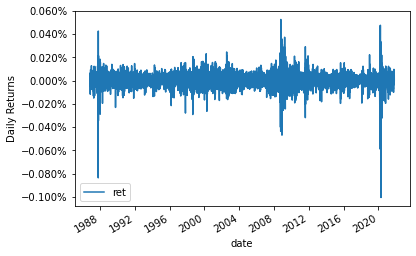

In [9]:
ax = portfolio_ret_d.plot()
plt.ylabel('Daily Returns')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

array([[<AxesSubplot:title={'center':'ret'}>]], dtype=object)

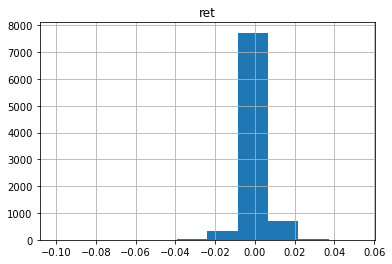

In [10]:
portfolio_ret_d.hist()

In [11]:
mean=portfolio_ret_d['ret'].mean()
std=portfolio_ret_d['ret'].std()
max_ = portfolio_ret_d['ret'].max()
min_ = portfolio_ret_d['ret'].min()
kurt = sp.kurtosis(portfolio_ret_d['ret'])
skew = sp.skew(portfolio_ret_d['ret'])

In [12]:
normalized_portfolio_ret=(portfolio_ret_d-mean)/std

In [13]:
normalized_portfolio_ret.applymap('{:,.2f}'.format)

,ret
date,
1986-11-03,0.55
1986-11-04,0.30
1986-11-05,0.39
1986-11-06,-0.35
1986-11-07,-0.25
...,...
2021-10-25,0.40
2021-10-26,-0.12
2021-10-27,-0.56


In [14]:
mean_norm = normalized_portfolio_ret['ret'].mean()
std_norm = normalized_portfolio_ret['ret'].std()
max_norm = normalized_portfolio_ret['ret'].max()
min_norm = normalized_portfolio_ret['ret'].min()
kurt_norm = sp.kurtosis(normalized_portfolio_ret['ret'])
skew_norm = sp.skew(normalized_portfolio_ret['ret'])

# Fitting Garch Model

In [15]:
model_garch = arch_model(y=portfolio_ret_d['ret']*100, rescale=True, mean='Zero')
res_garch = model_garch.fit(backcast=(portfolio_ret_d['ret'][0]*100)**2)
res_garch

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5464917.954032017
Iteration:      2,   Func. Count:     12,   Neg. LLF: 7826827.554791728
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5743.547727391124
Iteration:      4,   Func. Count:     22,   Neg. LLF: 5784.426637120938
Iteration:      5,   Func. Count:     28,   Neg. LLF: 5769.213106955727
Iteration:      6,   Func. Count:     34,   Neg. LLF: 5699.04868435102
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5699.047202513793
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5699.047197721575
Iteration:      9,   Func. Count:     45,   Neg. LLF: 5699.047197722101
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5699.047197721575
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5699.05
Distribution:                  Normal   AIC:                           11404.1
Method:            Maximum Likelihood   BIC:                           11425.3
                                        No. Observations:                 8820
Date:                Tue, Feb 08 2022   Df Residuals:                     8820
Time:                        04:16:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.1164e-03  1.239e-03      4.129  3.648e-05 [2.

In [16]:
scale = res_garch.scale
scale

1.0

In [17]:
forecasts_garch = res_garch.forecast(horizon=1, reindex=True)

In [18]:
vol_garch_for = (forecasts_garch.variance.iloc[-1]/10000)**0.5

In [19]:
std

0.005752715159760153

In [20]:
vol_garch_for[0]

0.0037579108994936082

# Fitting EWMA Model

In [21]:
am = ZeroMean(portfolio_ret_d['ret']*100)
am.volatility = EWMAVariance(None)
am.distribution = Normal()
res = am.fit(backcast=(portfolio_ret_d['ret'][0]*100)**2)
res

Iteration:      1,   Func. Count:      3,   Neg. LLF: 130239472.05939245
Iteration:      2,   Func. Count:      7,   Neg. LLF: 5803.657530560248
Iteration:      3,   Func. Count:      9,   Neg. LLF: 5803.648831495593
Iteration:      4,   Func. Count:     11,   Neg. LLF: 5803.648775668398
Iteration:      5,   Func. Count:     12,   Neg. LLF: 5803.648775668036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5803.648775668398
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 5


                  Zero Mean - EWMA/RiskMetrics Model Results                  
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:               -5803.65
Distribution:                  Normal   AIC:                           11609.3
Method:            Maximum Likelihood   BIC:                           11616.4
                                        No. Observations:                 8820
Date:                Tue, Feb 08 2022   Df Residuals:                     8820
Time:                        04:16:16   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
lam            0.9343  7.427e-03    125.792      0.000 [  0.920,  0.94

In [22]:
forecasts_res = res.forecast(horizon=1, reindex=True)
vol_ewma_for = (forecasts_res.variance.iloc[-1]/10000)**0.5

vol_ewma_for[0]

0.0037000564126949266

# Definging Garch and Emwa Volatilities
# Definging Forecast Parameters: Omega, Alpha, Beta, Lambda

In [23]:
forc_vol_emwa = (forecasts_res.variance.iloc[-1]/10000)**0.5

In [24]:
forc_vol_garch = (forecasts_garch.variance.iloc[-1]/10000)**0.5

In [25]:
omega = res_garch.params[0]/10000
alpha = res_garch.params[1]
beta = res_garch.params[2]
lamb = res.params[0]

In [26]:
lt_var = omega/(1-alpha-beta)
lt_vol = lt_var**(1/2)

In [27]:
obsv_vol = portfolio_ret_d['ret'].std()

obsv_vol

0.005752715159760153

In [28]:
L1 = [alpha.round(4), beta.round(4), (omega*10000).round(4), lamb.round(4)]
L2 = [np.round(obsv_vol, 4), forc_vol_garch[0].round(4), forc_vol_emwa[0].round(4), lt_vol.round(4)]

In [29]:
est_patam = pd.DataFrame(columns=['Alpha', 'Beta', 'Omega', 'Lamda'])
vols = pd.DataFrame(columns=['Obsv. Vola', 'Vola GARCH', 'Vola EWMA', 'LT Vola GARCH'])

In [30]:
est_patam.loc['Values'] = L1

est_patam.applymap('{:,.2f}'.format)

,Alpha,Beta,Omega,Lamda
Values,0.09,0.89,0.01,0.93


In [31]:
vols.loc['Values'] = L2

(vols*100).applymap('{:,.2f}%'.format)

,Obsv. Vola,Vola GARCH,Vola EWMA,LT Vola GARCH
Values,0.58%,0.38%,0.37%,0.53%


## Cerating DataFrame with EWMA weights

In [32]:
L_weights_emwa = []

In [33]:
for t in range(0, len(portfolio_ret_d)):
    L_weights_emwa.append((lamb**t)*(1-lamb))

In [34]:
L_weights_emwa.reverse()

In [35]:
weights_emwa = pd.DataFrame(columns=['weights', 'acum_weights'])
weights_emwa['weights'] = L_weights_emwa

In [ ]:
for y in range(0, len(weights_emwa)):
    if y==0:
        weights_emwa.iloc[y, 1] = weights_emwa.iloc[y, 0]
    else: weights_emwa.iloc[y, 1] = weights_emwa.iloc[y-1, 1] + weights_emwa.iloc[y, 0]

In [37]:
weights_emwa.index=portfolio_ret_d.index
weights_emwa

,weights,acum_weights
date,,
1986-11-03,4.019696e-262,0.0
1986-11-04,4.302286e-262,0.0
1986-11-05,4.604741e-262,0.0
1986-11-06,4.928460e-262,0.0
1986-11-07,5.274936e-262,0.0
...,...,...
2021-10-25,5.005326e-02,0.762037
2021-10-26,5.357206e-02,0.815609
2021-10-27,5.733824e-02,0.872947


# Preparing DataFrame to generate data (portfolio_ret_d)

### Columns: Returns, Conditional Var Garch, Conditional Var Emwa, Conditional Vol Garch, Conditonal Vol Emwa, Model Vol Garch, Model Emwa, Z-Garch, Z-Emwa, Returns Garch, Returns Emwa

In [38]:
portfolio_ret_d['cond_var_garch'] = 0
portfolio_ret_d['cond_var_emwa'] = 0
portfolio_ret_d['cond_vol_garch'] = 0
portfolio_ret_d['cond_vol_emwa'] = 0
portfolio_ret_d['model_vol_garch'] = 0
portfolio_ret_d['model_vol_emwa'] = 0
portfolio_ret_d['z_garch'] = 0
portfolio_ret_d['z_emwa'] = 0
portfolio_ret_d['resc_r_garch'] = 0
portfolio_ret_d['resc_r_emwa'] = 0

# Looping on data to generate Rescaled Returns on Garch and Emwa

In [39]:
for i in range(0,len(portfolio_ret_d)):
    if i == 0:
        portfolio_ret_d.iloc[i,1] = portfolio_ret_d.iloc[i,0]**2
    else: portfolio_ret_d.iloc[i,1] = omega + alpha*portfolio_ret_d.iloc[i-1,0]**2  + beta*portfolio_ret_d.iloc[i-1,1] 

In [40]:
for z in range(0,len(portfolio_ret_d)):
    if z == 0:
        portfolio_ret_d.iloc[z, 2] = portfolio_ret_d.iloc[z, 0]**2
    else: portfolio_ret_d.iloc[z, 2] = (1 - lamb)*portfolio_ret_d.iloc[z-1, 0]**2 + lamb*portfolio_ret_d.iloc[z-1, 2]

In [41]:
portfolio_ret_d['cond_vol_garch'] = portfolio_ret_d['cond_var_garch']**(1/2)
portfolio_ret_d['cond_vol_emwa'] = portfolio_ret_d['cond_var_emwa']**(1/2)

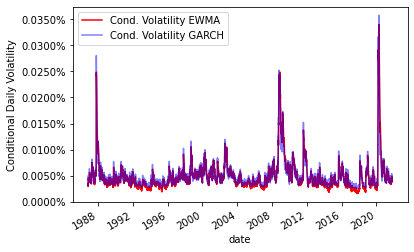

In [42]:
ax = portfolio_ret_d['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
ax = portfolio_ret_d['cond_vol_garch'].plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

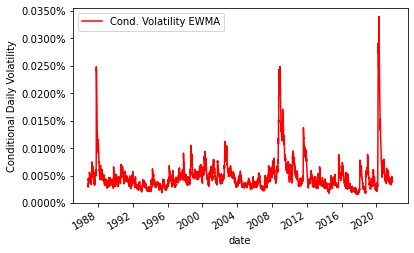

In [43]:
ax = portfolio_ret_d['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

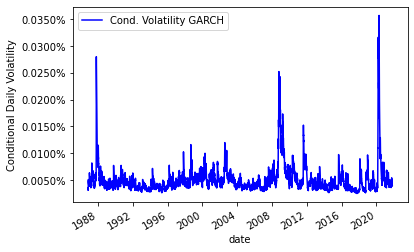

In [44]:
ax = portfolio_ret_d['cond_vol_garch'].plot(c='blue', label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

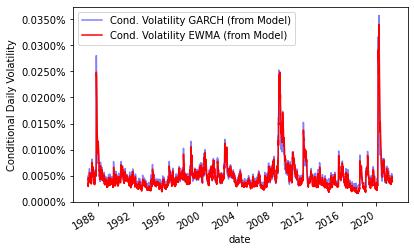

In [45]:
ax = (((res_garch.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH (from Model)')
ax = (((res.conditional_volatility**2)/10000)**0.5).plot(c='red', label = 'Cond. Volatility EWMA (from Model)')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

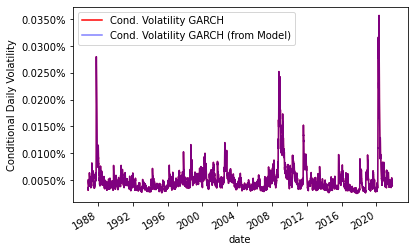

In [46]:
ax = portfolio_ret_d['cond_vol_garch'].plot(c='red', label = 'Cond. Volatility GARCH')
ax = (((res_garch.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH (from Model)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Conditional Daily Volatility')
plt.legend()

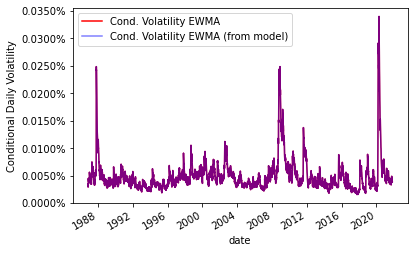

In [47]:
ax = portfolio_ret_d['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
ax = (((res.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA (from model)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Conditional Daily Volatility')
plt.legend()

In [48]:
portfolio_ret_d['model_vol_garch']=((res_garch.conditional_volatility**2)/10000)**0.5
portfolio_ret_d['model_vol_emwa']=((res.conditional_volatility**2)/10000)**0.5

In [49]:
portfolio_ret_d['z_garch'] = portfolio_ret_d['ret']/portfolio_ret_d['cond_vol_garch']
portfolio_ret_d['z_emwa'] = portfolio_ret_d['ret']/portfolio_ret_d['cond_vol_emwa']

In [50]:
for g in range(0, len(portfolio_ret_d)-1):
    portfolio_ret_d.iloc[g, 9] = portfolio_ret_d.iloc[g,7] * forc_vol_emwa

In [51]:
for h in range(0, len(portfolio_ret_d)-1):
    portfolio_ret_d.iloc[h, 10] = portfolio_ret_d.iloc[h,8] * forc_vol_garch

In [52]:
portfolio_ret_d

,ret,cond_var_garch,cond_var_emwa,cond_vol_garch,cond_vol_emwa,model_vol_garch,model_vol_emwa,z_garch,z_emwa,resc_r_garch,resc_r_emwa
date,,,,,,,,,,,
1986-11-03,0.003499,0.000012,0.000012,0.003499,0.003499,0.003540,0.003499,1.000000,1.000000,0.003700,0.003758
1986-11-04,0.002042,0.000013,0.000012,0.003540,0.003499,0.003576,0.003499,0.576962,0.583707,0.002135,0.002194
1986-11-05,0.002547,0.000012,0.000012,0.003471,0.003422,0.003504,0.003422,0.733908,0.744391,0.002716,0.002797
1986-11-06,-0.001681,0.000012,0.000011,0.003440,0.003372,0.003469,0.003372,-0.488822,-0.498687,-0.001809,-0.001874
1986-11-07,-0.001107,0.000011,0.000011,0.003362,0.003287,0.003389,0.003287,-0.329310,-0.336799,-0.001218,-0.001266
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.002631,0.000017,0.000016,0.004125,0.004053,0.004125,0.004053,0.637968,0.649163,0.002361,0.002439
2021-10-26,-0.000340,0.000016,0.000016,0.004036,0.003976,0.004036,0.003976,-0.084276,-0.085559,-0.000312,-0.000322
2021-10-27,-0.002912,0.000015,0.000015,0.003876,0.003844,0.003876,0.003844,-0.751175,-0.757544,-0.002779,-0.002847


In [53]:
mean_garch = portfolio_ret_d['z_garch'].mean()
std_garch = portfolio_ret_d['z_garch'].std()
max_garch = portfolio_ret_d['z_garch'].max() 
min_garch = portfolio_ret_d['z_garch'].min()
kurt_garch = sp.kurtosis(portfolio_ret_d['z_garch'])
skew_garch = sp.skew(portfolio_ret_d['z_garch'])

In [54]:
mean_ewma = portfolio_ret_d['z_emwa'].mean()
std_ewma = portfolio_ret_d['z_emwa'].std()
max_ewma = portfolio_ret_d['z_emwa'].max() 
min_ewma = portfolio_ret_d['z_emwa'].min()
kurt_ewma = sp.kurtosis(portfolio_ret_d['z_emwa'])
skew_ewma = sp.skew(portfolio_ret_d['z_emwa'])

## Statistics Table

In [55]:
df_stats = pd.DataFrame(index=['min', 'max', 'mean', 'kurtosis', 'skewness'])

In [56]:
df_stats['Returns'] = [min_, max_, mean, kurt, skew]
df_stats['Normalized Returns'] = [min_norm, max_norm, mean_norm, kurt_norm, skew_norm]
df_stats['Garch z-scores'] = [min_garch, max_garch, mean_garch, kurt_garch, skew_garch]
df_stats['Ewma z-scores'] = [min_ewma, max_ewma, mean_ewma, kurt_ewma, skew_ewma]

df_stats.round(3).applymap('{:,.2f}'.format)

,Returns,Normalized Returns,Garch z-scores,Ewma z-scores
min,-0.10,-17.55,-8.29,-9.17
max,0.05,9.08,4.16,4.46
mean,0.00,-0.00,0.07,0.08
kurtosis,26.61,26.61,2.33,2.96
skewness,-1.37,-1.37,-0.50,-0.57


# Prepating new DataFrame to generate risk measures

In [57]:
df_returns = pd.DataFrame()

In [58]:
df_returns['Returns'] = portfolio_ret_d['ret']
df_returns['Returns_Garch'] = portfolio_ret_d['resc_r_garch']
df_returns['Returns_Emwa'] = portfolio_ret_d['resc_r_emwa']

df_returns

,Returns,Returns_Garch,Returns_Emwa
date,,,
1986-11-03,0.003499,0.003700,0.003758
1986-11-04,0.002042,0.002135,0.002194
1986-11-05,0.002547,0.002716,0.002797
1986-11-06,-0.001681,-0.001809,-0.001874
1986-11-07,-0.001107,-0.001218,-0.001266
...,...,...,...
2021-10-25,0.002631,0.002361,0.002439
2021-10-26,-0.000340,-0.000312,-0.000322
2021-10-27,-0.002912,-0.002779,-0.002847


## Generating Risk Measures for each Look-back Period

In [59]:
df_risk_measures = pd.DataFrame(index=['VaR_PreC','VaR_PostC','ES_PreC','ES_PostC'], columns=['Param', 'Hist', 'Fhist_G', 'Fhist_E', 'Whist'])

In [60]:
df_505 = df_returns.iloc[-505:,:]

df_505

,Returns,Returns_Garch,Returns_Emwa
date,,,
2019-10-30,0.001384,0.001523,0.001542
2019-10-31,0.000226,0.000255,0.000259
2019-11-01,0.006176,0.007194,0.007322
2019-11-04,0.002479,0.002546,0.002701
2019-11-05,-0.001856,-0.001933,-0.002056
...,...,...,...
2021-10-25,0.002631,0.002361,0.002439
2021-10-26,-0.000340,-0.000312,-0.000322
2021-10-27,-0.002912,-0.002779,-0.002847


In [61]:
lb_505_vol= ((df_505['Returns']**2).mean())**0.5

In [62]:
var_505_param = sp.norm.ppf(0.95)*lb_505_vol

In [63]:
es_505_param = sp.norm.pdf(sp.norm.ppf(0.95))*lb_505_vol/0.05

In [64]:
var_505_hist = df_505['Returns'].quantile(q=0.05)

In [65]:
es_505_hist = (df_505['Returns'][(df_505['Returns']<df_505['Returns'].quantile(q=0.05))]).mean()

In [66]:
var_505_fhist_g = df_505['Returns_Garch'].quantile(q=0.05)

In [67]:
es_505_fhist_g = (df_505['Returns_Garch'][(df_505['Returns_Garch']<df_505['Returns_Garch'].quantile(q=0.05))]).mean()

In [68]:
var_505_fhist_e = df_505['Returns_Emwa'].quantile(q=0.05)

In [69]:
es_505_fhist_e = (df_505['Returns_Emwa'][(df_505['Returns_Emwa']<df_505['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1106]:
weights_emwa_505=weights_emwa.loc[df_505.index,:].copy()
adj=lamb**505
n_w=weights_emwa_505['weights']/(1-adj)
df_505['weights']=n_w
df_505['weights'].sum()

1.0

In [71]:
df_505.sort_values('Returns', inplace=True)
df_505['acum_weights'] = 0

for y in range(0, len(df_505.index)):
    if y==0:
        df_505.iloc[y, 4] = df_505.iloc[y, 3]
    else: df_505.iloc[y, 4] = df_505.iloc[y-1, 4] + df_505.iloc[y, 3]

In [72]:
w_hist_df=df_505[df_505['acum_weights']<=0.05]

hr_=df_505.iloc[len(w_hist_df),0]
hw_=df_505.iloc[len(w_hist_df),4]
lr_=w_hist_df.iloc[-1,0]
lw_=w_hist_df.iloc[-1,4]

w_hist_VaR=lr_+(0.05-lw_)*(hr_-lr_)/(hw_-lw_)
w_hist_ES=(w_hist_df['Returns']*w_hist_df['weights']).sum()/0.05

In [73]:
VaR_505 = [var_505_param, -var_505_hist, -var_505_fhist_g, -var_505_fhist_e, -w_hist_VaR]
ES_505 = [es_505_param, -es_505_hist, -es_505_fhist_g, -es_505_fhist_e, -w_hist_ES]

In [74]:
df_risk_measures.loc['VaR_PreC']=VaR_505
df_risk_measures.loc['ES_PreC']=ES_505

In [75]:
df_risk_measures

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,0.016628,0.010853,0.006315,0.006742,0.005403
VaR_PostC,NaN,NaN,NaN,NaN,NaN
ES_PreC,0.020853,0.027481,0.010376,0.010843,0.006532
ES_PostC,NaN,NaN,NaN,NaN,NaN


### PostCovid

In [1107]:
df_252 = df_returns.iloc[-252:,:].copy()

df_252

,Returns,Returns_Garch,Returns_Emwa
date,,,
2020-10-30,-0.00626,-0.00310,-0.00324
2020-11-02,0.00874,0.00441,0.00456
2020-11-03,0.00976,0.00485,0.00502
2020-11-04,0.00943,0.00456,0.00473
2020-11-05,0.01244,0.00591,0.00613
...,...,...,...
2021-10-25,0.00263,0.00236,0.00244
2021-10-26,-0.00034,-0.00031,-0.00032
2021-10-27,-0.00291,-0.00278,-0.00285


In [77]:
lb_252_vol= ((df_252['Returns']**2).mean())**0.5

In [78]:
var_252_param = sp.norm.ppf(0.95)*lb_252_vol

In [79]:
es_252_param = sp.norm.pdf(sp.norm.ppf(0.95))*lb_252_vol/0.05

In [80]:
var_252_hist = df_252['Returns'].quantile(q=0.05)

In [81]:
es_252_hist = (df_252['Returns'][(df_252['Returns']<df_252['Returns'].quantile(q=0.05))]).mean()

In [82]:
var_252_fhist_g = df_252['Returns_Garch'].quantile(q=0.05)

In [83]:
es_252_fhist_g = (df_252['Returns_Garch'][(df_252['Returns_Garch']<df_252['Returns_Garch'].quantile(q=0.05))]).mean()

In [84]:
var_252_fhist_e = df_252['Returns_Emwa'].quantile(q=0.05)

In [85]:
es_252_fhist_e = (df_252['Returns_Emwa'][(df_252['Returns_Emwa']<df_252['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1108]:
weights_emwa_252=weights_emwa.loc[df_252.index,:].copy()
adj=lamb**252
n_w=weights_emwa_252['weights']/(1-adj)
df_252['weights']=n_w
df_252['weights'].sum()

0.9999999999999999

In [87]:
df_252.sort_values('Returns', inplace=True)
df_252['acum_weights'] = 0

for y in range(0, len(df_252.index)):
    if y==0:
        df_252.iloc[y, 4] = df_252.iloc[y, 3]
    else: df_252.iloc[y, 4] = df_252.iloc[y-1, 4] + df_252.iloc[y, 3]

In [88]:
w_hist_df=df_252[df_252['acum_weights']<=0.05]

hr_=df_252.iloc[len(w_hist_df),0]
hw_=df_252.iloc[len(w_hist_df),4]
lr_=w_hist_df.iloc[-1,0]
lw_=w_hist_df.iloc[-1,4]

w_hist_VaR=lr_+(0.05-lw_)/(hw_-lw_)*(hr_-lr_)
w_hist_ES=(w_hist_df['Returns']*w_hist_df['weights']).sum()/0.05

In [89]:
VaR_252 = [var_252_param, -var_252_hist, -var_252_fhist_g, -var_252_fhist_e, -w_hist_VaR]
ES_252 = [es_252_param, -es_252_hist, -es_252_fhist_g, -es_252_fhist_e, -w_hist_ES]

In [90]:
df_risk_measures.loc['VaR_PostC']=VaR_252
df_risk_measures.loc['ES_PostC']=ES_252

In [1798]:
(df_risk_measures*100).applymap('{:,.2f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,1.66%,1.09%,0.63%,0.67%,0.54%
VaR_PostC,0.75%,0.62%,0.54%,0.56%,0.54%
ES_PreC,2.09%,2.75%,1.04%,1.08%,0.65%
ES_PostC,0.95%,0.90%,0.80%,0.83%,0.65%


# Evaluation of volatility

In [92]:
df_eval = portfolio_ret_d.iloc[504:,:]
bias_garch =  df_eval['z_garch'].std()
bias_ewma =  df_eval['z_emwa'].std()

df_bias = pd.DataFrame(index=['Stdv'], columns=['Garch', 'EWMA'], data= [[bias_garch,bias_ewma]])
df_bias.applymap('{:,.2f}'.format)

,Garch,EWMA
Stdv,0.99,1.05


In [93]:
low_interval_confidence = 1-(2/((len(portfolio_ret_d)-505)))**0.5
high_interval_confidence = 1+(2/((len(portfolio_ret_d)-505)))**0.5

df_bias_int = pd.DataFrame(index=['95% Confidence Intervals'], columns=['Low Interval', 'High Interval'], data= [[low_interval_confidence, high_interval_confidence]])
df_bias_int.applymap('{:,.2f}'.format)

,Low Interval,High Interval
95% Confidence Intervals,0.98,1.02


In [94]:
df_eval[['garch_std','ewma_std']] = 5
z = []

for i in range(0,len(df_eval)):
    z.append(portfolio_ret_d.iloc[i:504+i,7].std())
    
df_eval['garch_std'] = z

In [95]:
y = []

for i in range(0,len(df_eval)):
    y.append(portfolio_ret_d.iloc[i:504+i,8].std())
    
df_eval['ewma_std'] = y

In [96]:
bias_garch_2 = abs((df_eval['garch_std']-1).mean())
bias_ewma_2 = abs((df_eval['ewma_std']-1).mean())

df_MRAD = pd.DataFrame(index=['MRAD'], columns=['Garch', 'EWMA'], data= [[bias_garch_2,bias_ewma_2]])
df_MRAD.applymap('{:,.2f}'.format)

,Garch,EWMA
MRAD,0.01,0.05


In [97]:
skew_garch =  sp.skew(df_eval['z_garch'])
skew_ewma =  sp.skew(df_eval['z_emwa'])
skew_ret =  sp.skew(df_eval['ret'])
kurt_garch =  sp.kurtosis(df_eval['z_garch'])
kurt_ewma =  sp.kurtosis(df_eval['z_emwa'])
kurt_ret =  sp.kurtosis(df_eval['ret'])

zg_mn=df_eval['z_garch'].mean()
ze_mn=df_eval['z_garch'].mean()
r_mn=df_eval['ret'].mean()
zg_mdn=df_eval['z_emwa'].median()
ze_mdn=df_eval['z_emwa'].median()
r_mdn=df_eval['ret'].median()

r_skew_garch =  (zg_mn-zg_mdn)/bias_garch
r_skew_ewma =  (ze_mn-ze_mdn)/bias_ewma
r_skew_r = (r_mn-r_mdn)/df_eval['ret'].std()

df_dist = pd.DataFrame(index=['Skew','Robust Skew','Kurtosis'], columns=['Ret','Garch', 'EWMA'], data= [[skew_ret,skew_garch,skew_ewma],[r_skew_r,r_skew_garch,r_skew_ewma],[kurt_ret,kurt_garch,kurt_ewma]])
df_dist.applymap('{:,.2f}'.format)

,Ret,Garch,EWMA
Skew,-1.15,-0.46,-0.52
Robust Skew,-0.03,-0.06,-0.05
Kurtosis,23.99,1.87,2.41


In [98]:
df_eval[['QL_G','QL_E','d']] = 5

df_eval['QL_G']=np.log(df_eval['z_garch']**2)-df_eval['z_garch']**2
df_eval['QL_E']=np.log(df_eval['z_emwa']**2)-df_eval['z_emwa']**2
df_eval['d'] = df_eval['QL_G'] - df_eval['QL_E']

mean_d = df_eval['d'].mean()
std_d = df_eval['d'].std()/((len(portfolio_ret_d)-505)**0.5)
t_d = mean_d/std_d

df_QL = pd.DataFrame(index=['Sum_QL','Avg_d','t_d'], columns=['Garch', 'EWMA', 'A-B'], data= [[df_eval['QL_G'].sum(),df_eval['QL_E'].sum(),''],['','',mean_d],['','',t_d]])
df_QL

,Garch,EWMA,A-B
Sum_QL,-20457.167429,-20634.418246,
Avg_d,,,0.021314
t_d,,,3.218224


# Evaluation of VaR

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
df_eval[['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t']] = 5

In [101]:
a = []
for i in range(0,len(df_eval)):
    v= portfolio_ret_d.iloc[i:504+i,0].std()
    a.append(-sp.norm.ppf(0.95)*v)
    
df_eval['p_VaR_t'] = a

b = []
for i in range(0,len(df_eval)):
    b.append(portfolio_ret_d.iloc[i:504+i,0].quantile(q=0.05))
    
df_eval['h_VaR_t'] = b

c = []
for i in range(0,len(df_eval)):
    if i < len(df_eval)-1:
        c.append((portfolio_ret_d.iloc[i:504+i,0]*portfolio_ret_d.iloc[504+i+1,3]/portfolio_ret_d.iloc[i:504+i,3]).quantile(q=0.05))
    else:
        c.append((portfolio_ret_d.iloc[i:504+i,0]*forc_vol_garch[0]/portfolio_ret_d.iloc[i:504+i,3]).quantile(q=0.05))
    
df_eval['fhg_VaR_t'] = c

d = []
for i in range(0,len(df_eval)):
    if i < len(df_eval)-1:
        d.append((portfolio_ret_d.iloc[i:504+i,0]*portfolio_ret_d.iloc[504+i+1,4]/portfolio_ret_d.iloc[i:504+i,4]).quantile(q=0.05))
    else:
        d.append((portfolio_ret_d.iloc[i:504+i,0]*forc_vol_emwa[0]/portfolio_ret_d.iloc[i:504+i,4]).quantile(q=0.05))
    
df_eval['fhe_VaR_t'] = d

In [102]:
e = []
for i in range(0,len(df_eval)):
    weights_temp=[]
    temp=[]
    w_temp_df=[]
    s=0
    
    weights_temp = weights_emwa.iloc[i:504+i,0]
    s = weights_temp.sum()
    weights_temp = weights_temp/s 
    temp = pd.DataFrame(portfolio_ret_d.iloc[i:504+i,0])
    temp['w'] = weights_temp
    temp.sort_values('ret', inplace=True)
    temp['acum_weights'] = 0
    for y in range(0, len(temp.index)):
        if y==0:
            temp.iloc[y, 2] = temp.iloc[y, 1]
        else: temp.iloc[y, 2] = temp.iloc[y-1, 2] + temp.iloc[y, 1]
    w_temp_df=temp.loc[temp['acum_weights']<=0.05,['ret','w','acum_weights']]
    hr_t=temp.iloc[len(w_temp_df),0]
    hw_t=temp.iloc[len(w_temp_df),2]
    if len(w_temp_df.index) > 0:
        lr_t=w_temp_df.iloc[-1,0]
        lw_t=w_temp_df.iloc[-1,2]
        e.append(lr_t+(0.05-lw_t)/(hw_t-lw_t)*(hr_t-lr_t))
    else:
        e.append(temp.iloc[0,0])
    
df_eval['wh_VaR_t'] = e

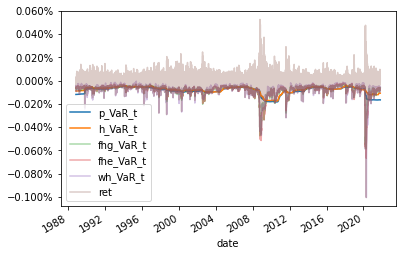

In [103]:
ax = df_eval[['p_VaR_t','h_VaR_t']].plot()
ax = df_eval['fhg_VaR_t'].plot(alpha=0.4)
ax = df_eval['fhe_VaR_t'].plot(alpha=0.4)
ax = df_eval['wh_VaR_t'].plot(alpha=0.4)
ax = df_eval['ret'].plot(alpha=0.3)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [104]:
VaR_t=pd.DataFrame(index=df_eval.index, columns= ['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t'])

VaR_t['p_VaR_t']= df_eval['ret']<df_eval['p_VaR_t']
VaR_t['h_VaR_t']= df_eval['ret']<df_eval['h_VaR_t']
VaR_t['fhg_VaR_t']= df_eval['ret']<df_eval['fhg_VaR_t']
VaR_t['fhe_VaR_t']= df_eval['ret']<df_eval['fhe_VaR_t']
VaR_t['wh_VaR_t']= df_eval['ret']<df_eval['wh_VaR_t']

VaR_t_2=VaR_t.groupby(pd.Grouper(freq='Y')).sum()
pd.DataFrame(columns=['Average Number of Excedences per Year'],data=VaR_t_2.mean().round(2))

,Average Number of Excedences per Year
p_VaR_t,11.12
h_VaR_t,13.00
fhg_VaR_t,9.79
fhe_VaR_t,10.88
wh_VaR_t,15.88


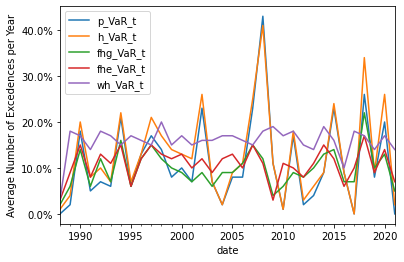

In [105]:
ax = VaR_t_2.plot()
plt.ylabel('Average Number of Excedences per Year')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

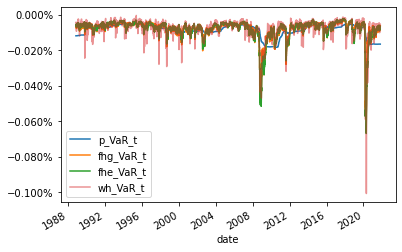

In [106]:
ax = df_eval[['p_VaR_t','fhg_VaR_t','fhe_VaR_t']].plot()
ax = df_eval['wh_VaR_t'].plot(alpha=0.5)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ----------------------- DAILY AUGMENTED ----------------------- 

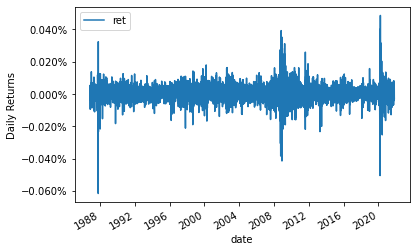

In [107]:
ax = portfolio_ret_d_aug.plot()
plt.ylabel('Daily Returns')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

array([[<AxesSubplot:title={'center':'ret'}>]], dtype=object)

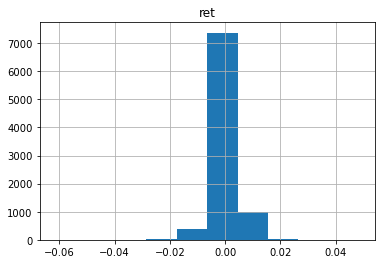

In [108]:
portfolio_ret_d_aug.hist()

In [109]:
mean_aug=portfolio_ret_d_aug['ret'].mean()
std_aug=portfolio_ret_d_aug['ret'].std()
max_aug = portfolio_ret_d_aug['ret'].max()
min_aug = portfolio_ret_d_aug['ret'].min()
kurt_aug = sp.kurtosis(portfolio_ret_d_aug['ret'])
skew_aug = sp.skew(portfolio_ret_d_aug['ret'])

In [110]:
normalized_portfolio_ret_aug=(portfolio_ret_d_aug-mean_aug)/std_aug

In [111]:
normalized_portfolio_ret_aug.applymap('{:,.2f}'.format)

,ret
date,
1986-11-03,1.02
1986-11-04,0.31
1986-11-05,0.38
1986-11-06,-0.20
1986-11-07,-0.26
...,...
2021-10-25,0.20
2021-10-26,-0.58
2021-10-27,-0.40


In [112]:
mean_norm_aug = normalized_portfolio_ret_aug['ret'].mean()
std_norm_aug = normalized_portfolio_ret_aug['ret'].std()
max_norm_aug = normalized_portfolio_ret_aug['ret'].max()
min_norm_aug = normalized_portfolio_ret_aug['ret'].min()
kurt_norm_aug = sp.kurtosis(normalized_portfolio_ret_aug['ret'])
skew_norm_aug = sp.skew(normalized_portfolio_ret_aug['ret'])

# Fitting Garch Model

In [113]:
model_garch_aug = arch_model(y=portfolio_ret_d_aug['ret']*100, rescale=True, mean='Zero')
res_garch_aug = model_garch_aug.fit(backcast=(portfolio_ret_d_aug['ret'][0]*100)**2)
res_garch_aug

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4874085943.933154
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6285.900941964205
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2284792472.541962
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3992.379666008216
Iteration:      5,   Func. Count:     29,   Neg. LLF: 3965.1210805690735
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3958.7336350547293
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3958.670325754945
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3958.669138308541
Iteration:      9,   Func. Count:     46,   Neg. LLF: 3958.6691383117345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3958.669138308541
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3958.67
Distribution:                  Normal   AIC:                           7923.34
Method:            Maximum Likelihood   BIC:                           7944.59
                                        No. Observations:                 8820
Date:                Tue, Feb 08 2022   Df Residuals:                     8820
Time:                        04:54:37   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.5998e-03  1.029e-03      3.498  4.681e-04 [1.

In [114]:
scale_aug = res_garch_aug.scale
scale_aug

1.0

In [115]:
forecasts_garch_aug = res_garch_aug.forecast(horizon=1, reindex=True)

In [116]:
vol_garch_for_aug = (forecasts_garch_aug.variance.iloc[-1]/10000)**0.5

In [117]:
std_aug

0.004585005756661709

In [118]:
vol_garch_for_aug[0]

0.0034416977120345672

# Fitting EWMA Model

In [119]:
am_aug = ZeroMean(portfolio_ret_d_aug['ret']*100)
am_aug.volatility = EWMAVariance(None)
am_aug.distribution = Normal()
res_aug = am_aug.fit(backcast=(portfolio_ret_d_aug['ret'][0]*100)**2)
res_aug

Iteration:      1,   Func. Count:      3,   Neg. LLF: 5715.25172578939
Iteration:      2,   Func. Count:      7,   Neg. LLF: 4048.0619543263774
Iteration:      3,   Func. Count:      9,   Neg. LLF: 4048.061953290436
Iteration:      4,   Func. Count:     10,   Neg. LLF: 4048.0619532904266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4048.061953290436
            Iterations: 4
            Function evaluations: 10
            Gradient evaluations: 4


                  Zero Mean - EWMA/RiskMetrics Model Results                  
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:               -4048.06
Distribution:                  Normal   AIC:                           8098.12
Method:            Maximum Likelihood   BIC:                           8105.21
                                        No. Observations:                 8820
Date:                Tue, Feb 08 2022   Df Residuals:                     8820
Time:                        04:54:38   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
lam            0.9431  7.649e-03    123.297      0.000 [  0.928,  0.95

In [120]:
forecasts_res_aug = res_aug.forecast(horizon=1, reindex=True)
vol_ewma_for_aug = (forecasts_res_aug.variance.iloc[-1]/10000)**0.5

vol_ewma_for_aug[0]

0.003477439184432551

# Definging Garch and Emwa Volatilities
# Definging Forecast Parameters: Omega, Alpha, Beta, Lambda

In [121]:
forc_vol_emwa_aug = (forecasts_res_aug.variance.iloc[-1]/10000)**0.5

In [122]:
forc_vol_garch_aug = (forecasts_garch_aug.variance.iloc[-1]/10000)**0.5

In [123]:
omega_aug = res_garch_aug.params[0]/10000
alpha_aug = res_garch_aug.params[1]
beta_aug = res_garch_aug.params[2]
lamb_aug = res_aug.params[0]

In [124]:
lt_var_aug = omega_aug/(1-alpha_aug-beta_aug)
lt_vol_aug = lt_var_aug**(1/2)

In [125]:
obsv_vol_aug = portfolio_ret_d_aug['ret'].std()

obsv_vol_aug

0.004585005756661709

In [126]:
L1_aug = [alpha_aug.round(4), beta_aug.round(4), (omega_aug*10000).round(4), lamb_aug.round(4)]
L2_aug = [np.round(obsv_vol_aug, 4), forc_vol_garch_aug[0].round(4), forc_vol_emwa_aug[0].round(4), lt_vol_aug.round(4)]

In [127]:
est_patam_aug = pd.DataFrame(columns=['Alpha', 'Beta', 'Omega', 'Lamda'])
vols_aug = pd.DataFrame(columns=['Obsv. Vola', 'Vola GARCH', 'Vola EWMA', 'LT Vola GARCH'])

In [128]:
est_patam_aug.loc['Values'] = L1_aug

est_patam_aug.applymap('{:,.2f}'.format)

,Alpha,Beta,Omega,Lamda
Values,0.08,0.90,0.00,0.94


In [129]:
vols_aug.loc['Values'] = L2_aug

(vols_aug*100).applymap('{:,.2f}%'.format)

,Obsv. Vola,Vola GARCH,Vola EWMA,LT Vola GARCH
Values,0.46%,0.34%,0.35%,0.42%


## Cerating DataFrame with Emua weights

In [130]:
L_weights_emwa_aug = []

In [131]:
for t in range(0, len(portfolio_ret_d_aug)):
    L_weights_emwa_aug.append((lamb_aug**t)*(1-lamb_aug))

In [132]:
L_weights_emwa_aug.reverse()

In [133]:
weights_emwa_aug = pd.DataFrame(columns=['weights', 'acum_weights'])
weights_emwa_aug['weights'] = L_weights_emwa_aug

In [134]:
for y in range(0, len(weights_emwa_aug)):
    if y==0:
        weights_emwa_aug.iloc[y, 1] = weights_emwa_aug.iloc[y, 0]
    else: weights_emwa_aug.iloc[y, 1] = weights_emwa_aug.iloc[y-1, 1] + weights_emwa_aug.iloc[y, 0]

In [135]:
weights_emwa_aug.index=portfolio_ret_d_aug.index
weights_emwa_aug

,weights,acum_weights
date,,
1986-11-03,2.400860e-226,0.0
1986-11-04,2.545711e-226,0.0
1986-11-05,2.699301e-226,0.0
1986-11-06,2.862157e-226,0.0
1986-11-07,3.034839e-226,0.0
...,...,...
2021-10-25,4.501347e-02,0.7911
2021-10-26,4.772926e-02,0.838829
2021-10-27,5.060890e-02,0.889438


# Preparing DataFrame to generate data (portfolio_ret_d)

### Columns: Returns, Conditional Var Garch, Conditional Var Emwa, Conditional Vol Garch, Conditonal Vol Emwa, Model Vol Garch, Model Emwa, Z-Garch, Z-Emwa, Returns Garch, Returns Emwa

In [136]:
portfolio_ret_d_aug['cond_var_garch'] = 0
portfolio_ret_d_aug['cond_var_emwa'] = 0
portfolio_ret_d_aug['cond_vol_garch'] = 0
portfolio_ret_d_aug['cond_vol_emwa'] = 0
portfolio_ret_d_aug['model_vol_garch'] = 0
portfolio_ret_d_aug['model_vol_emwa'] = 0
portfolio_ret_d_aug['z_garch'] = 0
portfolio_ret_d_aug['z_emwa'] = 0
portfolio_ret_d_aug['resc_r_garch'] = 0
portfolio_ret_d_aug['resc_r_emwa'] = 0

# Looping on data to generate Rescaled Returns on Garch and Emwa

In [137]:
for i in range(0,len(portfolio_ret_d_aug)):
    if i == 0:
        portfolio_ret_d_aug.iloc[i,1] = portfolio_ret_d_aug.iloc[i,0]**2
    else: portfolio_ret_d_aug.iloc[i,1] = omega_aug + alpha_aug*portfolio_ret_d_aug.iloc[i-1,0]**2  + beta_aug*portfolio_ret_d_aug.iloc[i-1,1] 

In [138]:
for z in range(0,len(portfolio_ret_d_aug)):
    if z == 0:
        portfolio_ret_d_aug.iloc[z, 2] = portfolio_ret_d_aug.iloc[z, 0]**2
    else: portfolio_ret_d_aug.iloc[z, 2] = (1 - lamb_aug)*portfolio_ret_d_aug.iloc[z-1, 0]**2 + lamb_aug*portfolio_ret_d_aug.iloc[z-1, 2]

In [139]:
portfolio_ret_d_aug['cond_vol_garch'] = portfolio_ret_d_aug['cond_var_garch']**(1/2)
portfolio_ret_d_aug['cond_vol_emwa'] = portfolio_ret_d_aug['cond_var_emwa']**(1/2)

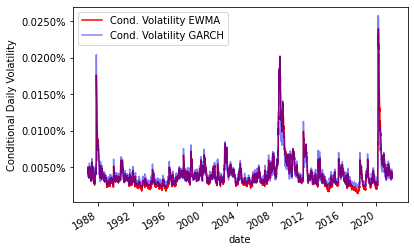

In [140]:
ax = portfolio_ret_d_aug['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
ax = portfolio_ret_d_aug['cond_vol_garch'].plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

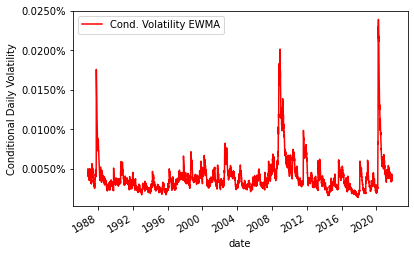

In [141]:
ax = portfolio_ret_d_aug['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

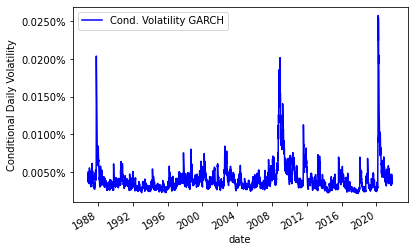

In [142]:
ax = portfolio_ret_d_aug['cond_vol_garch'].plot(c='blue', label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

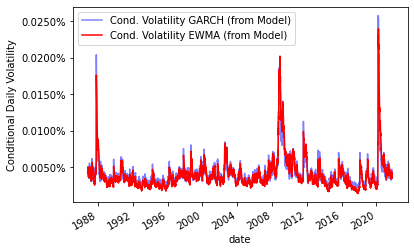

In [143]:
ax = (((res_garch_aug.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH (from Model)')
ax = (((res_aug.conditional_volatility**2)/10000)**0.5).plot(c='red', label = 'Cond. Volatility EWMA (from Model)')
plt.ylabel('Conditional Daily Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

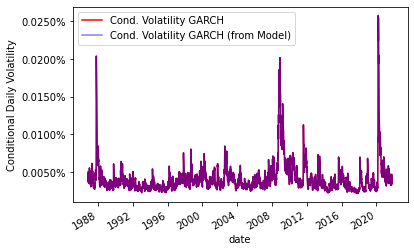

In [144]:
ax = portfolio_ret_d_aug['cond_vol_garch'].plot(c='red', label = 'Cond. Volatility GARCH')
ax = (((res_garch_aug.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH (from Model)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Conditional Daily Volatility')
plt.legend()

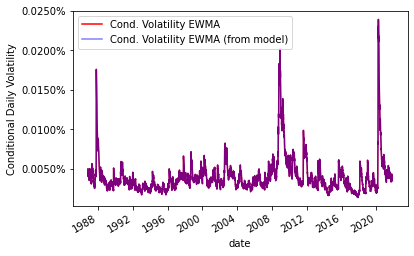

In [145]:
ax = portfolio_ret_d_aug['cond_vol_emwa'].plot(c='red', label = 'Cond. Volatility EWMA')
ax = (((res_aug.conditional_volatility**2)/10000)**0.5).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA (from model)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Conditional Daily Volatility')
plt.legend()

In [146]:
portfolio_ret_d_aug['model_vol_garch']=((res_garch_aug.conditional_volatility**2)/10000)**0.5
portfolio_ret_d_aug['model_vol_emwa']=((res_aug.conditional_volatility**2)/10000)**0.5

In [147]:
portfolio_ret_d_aug['z_garch'] = portfolio_ret_d_aug['ret']/portfolio_ret_d_aug['cond_vol_garch']
portfolio_ret_d_aug['z_emwa'] = portfolio_ret_d_aug['ret']/portfolio_ret_d_aug['cond_vol_emwa']

In [148]:
for g in range(0, len(portfolio_ret_d_aug)-1):
    portfolio_ret_d_aug.iloc[g, 9] = portfolio_ret_d_aug.iloc[g,7] * forc_vol_emwa_aug

In [149]:
for h in range(0, len(portfolio_ret_d_aug)-1):
    portfolio_ret_d_aug.iloc[h, 10] = portfolio_ret_d_aug.iloc[h,8] * forc_vol_garch_aug

In [150]:
portfolio_ret_d_aug

,ret,cond_var_garch,cond_var_emwa,cond_vol_garch,cond_vol_emwa,model_vol_garch,model_vol_emwa,z_garch,z_emwa,resc_r_garch,resc_r_emwa
date,,,,,,,,,,,
1986-11-03,0.004991,0.000025,0.000025,0.004991,0.004991,0.004977,0.004991,1.000000,1.000000,0.003477,0.003442
1986-11-04,0.001756,0.000025,0.000025,0.004977,0.004991,0.004963,0.004991,0.352792,0.351747,0.001227,0.001211
1986-11-05,0.002072,0.000023,0.000024,0.004774,0.004865,0.004762,0.004865,0.434056,0.425927,0.001509,0.001466
1986-11-06,-0.000591,0.000021,0.000023,0.004597,0.004751,0.004585,0.004751,-0.128548,-0.124379,-0.000447,-0.000428
1986-11-07,-0.000852,0.000019,0.000021,0.004394,0.004616,0.004383,0.004616,-0.193979,-0.184656,-0.000675,-0.000636
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.001251,0.000014,0.000014,0.003776,0.003757,0.003776,0.003757,0.331158,0.332863,0.001152,0.001146
2021-10-26,-0.002331,0.000013,0.000013,0.003641,0.003661,0.003641,0.003661,-0.640181,-0.636797,-0.002226,-0.002192
2021-10-27,-0.001501,0.000013,0.000013,0.003562,0.003598,0.003562,0.003598,-0.421419,-0.417199,-0.001465,-0.001436


In [151]:
mean_garch_aug = portfolio_ret_d_aug['z_garch'].mean()
std_garch_aug = portfolio_ret_d_aug['z_garch'].std()
max_garch_aug = portfolio_ret_d_aug['z_garch'].max() 
min_garch_aug = portfolio_ret_d_aug['z_garch'].min()
kurt_garch_aug = sp.kurtosis(portfolio_ret_d_aug['z_garch'])
skew_garch_aug = sp.skew(portfolio_ret_d_aug['z_garch'])

In [152]:
mean_ewma_aug = portfolio_ret_d_aug['z_emwa'].mean()
std_ewma_aug = portfolio_ret_d_aug['z_emwa'].std()
max_ewma_aug = portfolio_ret_d_aug['z_emwa'].max() 
min_ewma_aug = portfolio_ret_d_aug['z_emwa'].min()
kurt_ewma_aug = sp.kurtosis(portfolio_ret_d_aug['z_emwa'])
skew_ewma_aug = sp.skew(portfolio_ret_d_aug['z_emwa'])

## Statistics Table

In [153]:
df_stats_aug = pd.DataFrame(index=['min', 'max', 'mean', 'kurtosis', 'skewness'])

In [154]:
df_stats_aug['Returns'] = [min_aug, max_aug, mean_aug, kurt_aug, skew_aug]
df_stats_aug['Normalized Returns'] = [min_norm_aug, max_norm_aug, mean_norm_aug, kurt_norm_aug, skew_norm_aug]
df_stats_aug['Garch z-scores'] = [min_garch_aug, max_garch_aug, mean_garch_aug, kurt_garch_aug, skew_garch_aug]
df_stats_aug['Ewma z-scores'] = [min_ewma_aug, max_ewma_aug, mean_ewma_aug, kurt_ewma_aug, skew_ewma_aug]

df_stats_aug.round(3).applymap('{:,.2f}'.format)

,Returns,Normalized Returns,Garch z-scores,Ewma z-scores
min,-0.06,-13.52,-8.36,-9.74
max,0.05,10.52,4.53,5.15
mean,0.00,0.00,0.09,0.09
kurtosis,16.32,16.32,2.49,3.32
skewness,-0.56,-0.56,-0.41,-0.49


# Prepating new DataFrame to generate risk measures

In [155]:
df_returns_aug = pd.DataFrame()

In [156]:
df_returns_aug['Returns'] = portfolio_ret_d_aug['ret']
df_returns_aug['Returns_Garch'] = portfolio_ret_d_aug['resc_r_garch']
df_returns_aug['Returns_Emwa'] = portfolio_ret_d_aug['resc_r_emwa']

df_returns_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
1986-11-03,0.004991,0.003477,0.003442
1986-11-04,0.001756,0.001227,0.001211
1986-11-05,0.002072,0.001509,0.001466
1986-11-06,-0.000591,-0.000447,-0.000428
1986-11-07,-0.000852,-0.000675,-0.000636
...,...,...,...
2021-10-25,0.001251,0.001152,0.001146
2021-10-26,-0.002331,-0.002226,-0.002192
2021-10-27,-0.001501,-0.001465,-0.001436


## Generating Risk Measures for each Look-back Period

In [157]:
df_risk_measures_aug = pd.DataFrame(index=['VaR_PreC','VaR_PostC','ES_PreC','ES_PostC'], columns=['Param', 'Hist', 'Fhist_G', 'Fhist_E', 'Whist'])

In [158]:
df_505_aug = df_returns_aug.iloc[-505:,:].copy()

df_505_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
2019-10-30,0.000535,0.000652,0.000651
2019-10-31,0.001607,0.002019,0.002014
2019-11-01,0.004467,0.005694,0.005704
2019-11-04,0.003426,0.004038,0.004172
2019-11-05,-0.003005,-0.003456,-0.003612
...,...,...,...
2021-10-25,0.001251,0.001152,0.001146
2021-10-26,-0.002331,-0.002226,-0.002192
2021-10-27,-0.001501,-0.001465,-0.001436


In [159]:
lb_505_vol_aug= ((df_505_aug['Returns']**2).mean())**0.5

In [160]:
var_param_aug = sp.norm.ppf(0.95)*lb_505_vol_aug

In [161]:
es_param_aug = sp.norm.pdf(sp.norm.ppf(0.95))*lb_505_vol_aug/0.05

In [162]:
var_505_hist_aug = df_505_aug['Returns'].quantile(q=0.05)

In [163]:
es_505_hist_aug = (df_505_aug['Returns'][(df_505_aug['Returns']<df_505_aug['Returns'].quantile(q=0.05))]).mean()

In [164]:
var_505_fhist_g_aug = df_505_aug['Returns_Garch'].quantile(q=0.05)

In [165]:
es_505_fhist_g_aug = (df_505_aug['Returns_Garch'][(df_505_aug['Returns_Garch']<df_505_aug['Returns_Garch'].quantile(q=0.05))]).mean()

In [166]:
var_505_fhist_e_aug = df_505_aug['Returns_Emwa'].quantile(q=0.05)

In [167]:
es_505_fhist_e_aug = (df_505_aug['Returns_Emwa'][(df_505_aug['Returns_Emwa']<df_505_aug['Returns_Emwa'].quantile(q=0.05))]).mean()

In [168]:
weights_emwa_505_aug=weights_emwa_aug.loc[df_505_aug.index,:].copy()
adj_aug=lamb_aug**505
n_w_aug=weights_emwa_505_aug['weights']/(1-adj_aug)
df_505_aug['weights']=n_w_aug
df_505_aug['weights'].sum()

1.0

In [169]:
df_505_aug.sort_values('Returns', inplace=True)
df_505_aug['acum_weights'] = 0

for y in range(0, len(df_505_aug.index)):
    if y==0:
        df_505_aug.iloc[y, 4] = df_505_aug.iloc[y, 3]
    else: df_505_aug.iloc[y, 4] = df_505_aug.iloc[y-1, 4] + df_505_aug.iloc[y, 3]

In [170]:
w_hist_df_aug=df_505_aug[df_505_aug['acum_weights']<=0.05]

hr_aug=df_505_aug.iloc[len(w_hist_df_aug),0]
hw_aug=df_505_aug.iloc[len(w_hist_df_aug),4]
lr_aug=w_hist_df_aug.iloc[-1,0]
lw_aug=w_hist_df_aug.iloc[-1,4]

w_hist_VaR_aug=lr_aug+(0.05-lw_aug)*(hr_aug-lr_aug)/(hw_aug-lw_aug)
w_hist_ES_aug=(w_hist_df_aug['Returns']*w_hist_df_aug['weights']).sum()/0.05

In [171]:
VaR_505_aug = [var_param_aug, -var_505_hist_aug, -var_505_fhist_g_aug, -var_505_fhist_e_aug, -w_hist_VaR_aug]
ES_505_aug = [es_param_aug, -es_505_hist_aug, -es_505_fhist_g_aug, -es_505_fhist_e_aug, -w_hist_ES_aug]

In [172]:
df_risk_measures_aug.loc['VaR_PreC']=VaR_505_aug
df_risk_measures_aug.loc['ES_PreC']=ES_505_aug

In [173]:
df_risk_measures_aug

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,0.012684,0.009991,0.005578,0.00538,0.005026
VaR_PostC,NaN,NaN,NaN,NaN,NaN
ES_PreC,0.015907,0.018659,0.008766,0.008909,0.006117
ES_PostC,NaN,NaN,NaN,NaN,NaN


### PostCovid

In [174]:
df_252_aug = df_returns_aug.iloc[-252:,:].copy()

df_252_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
2020-10-30,-0.002659,-0.001448,-0.001456
2020-11-02,0.008175,0.004646,0.004586
2020-11-03,0.008049,0.004452,0.004418
2020-11-04,0.000810,0.000439,0.000437
2020-11-05,0.013483,0.007676,0.007481
...,...,...,...
2021-10-25,0.001251,0.001152,0.001146
2021-10-26,-0.002331,-0.002226,-0.002192
2021-10-27,-0.001501,-0.001465,-0.001436


In [175]:
lb_252_vol_aug= ((df_252_aug['Returns']**2).mean())**0.5

In [176]:
var_param_aug = sp.norm.ppf(0.95)*lb_252_vol_aug

In [177]:
es_param_aug = sp.norm.pdf(sp.norm.ppf(0.95))*lb_252_vol_aug/0.05

In [178]:
var_252_hist_aug = df_252_aug['Returns'].quantile(q=0.05)

In [179]:
es_252_hist_aug = (df_252_aug['Returns'][(df_252_aug['Returns']<df_252_aug['Returns'].quantile(q=0.05))]).mean()

In [180]:
var_252_fhist_g_aug = df_252_aug['Returns_Garch'].quantile(q=0.05)

In [181]:
es_252_fhist_g_aug = (df_252_aug['Returns_Garch'][(df_252_aug['Returns_Garch']<df_252_aug['Returns_Garch'].quantile(q=0.05))]).mean()

In [182]:
var_252_fhist_e_aug = df_252_aug['Returns_Emwa'].quantile(q=0.05)

In [183]:
es_252_fhist_e_aug = (df_252_aug['Returns_Emwa'][(df_252_aug['Returns_Emwa']<df_252_aug['Returns_Emwa'].quantile(q=0.05))]).mean()

In [184]:
weights_emwa_252_aug=weights_emwa_aug.loc[df_252_aug.index,:].copy()
adj_aug=lamb_aug**252
n_w_aug=weights_emwa_252_aug['weights']/(1-adj_aug)
df_252_aug['weights']=n_w_aug
df_252_aug['weights'].sum()

1.0000000000000002

In [185]:
df_252_aug.sort_values('Returns', inplace=True)
df_252_aug['acum_weights'] = 0

for y in range(0, len(df_252_aug.index)):
    if y==0:
        df_252_aug.iloc[y, 4] = df_252_aug.iloc[y, 3]
    else: df_252_aug.iloc[y, 4] = df_252_aug.iloc[y-1, 4] + df_252_aug.iloc[y, 3]

In [186]:
w_hist_df_aug=df_252_aug[df_252_aug['acum_weights']<=0.05]

hr_aug=df_252_aug.iloc[len(w_hist_df_aug),0]
hw_aug=df_252_aug.iloc[len(w_hist_df_aug),4]
lr_aug=w_hist_df_aug.iloc[-1,0]
lw_aug=w_hist_df_aug.iloc[-1,4]

w_hist_VaR_aug=lr_aug+(0.05-lw_aug)/(hw_aug-lw_aug)*(hr_aug-lr_aug)
w_hist_ES_aug=(w_hist_df_aug['Returns']*w_hist_df_aug['weights']).sum()/0.05

In [187]:
VaR_252_aug = [var_param_aug, -var_252_hist_aug, -var_252_fhist_g_aug, -var_252_fhist_e_aug, -w_hist_VaR_aug]
ES_252_aug = [es_param_aug, -es_252_hist_aug, -es_252_fhist_g_aug, -es_252_fhist_e_aug, -w_hist_ES_aug]

In [188]:
df_risk_measures_aug.loc['VaR_PostC']=VaR_252_aug
df_risk_measures_aug.loc['ES_PostC']=ES_252_aug

In [1799]:
(df_risk_measures_aug*100).applymap('{:,.2f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,1.27%,1.00%,0.56%,0.54%,0.50%
VaR_PostC,0.70%,0.61%,0.52%,0.50%,0.50%
ES_PreC,1.59%,1.87%,0.88%,0.89%,0.61%
ES_PostC,0.88%,0.79%,0.70%,0.69%,0.61%


# Evaluation of volatility

In [190]:
df_eval_aug = portfolio_ret_d_aug.iloc[504:,:].copy()
bias_garch_aug =  df_eval_aug['z_garch'].std()
bias_ewma_aug =  df_eval_aug['z_emwa'].std()

df_bias_aug = pd.DataFrame(index=['Stdv'], columns=['Garch', 'EWMA'], data= [[bias_garch_aug,bias_ewma_aug]])
df_bias_aug.applymap('{:,.2f}'.format)

,Garch,EWMA
Stdv,0.99,1.04


In [191]:
low_interval_confidence_aug = 1-(2/((len(portfolio_ret_d_aug)-505)))**0.5
high_interval_confidence_aug = 1+(2/((len(portfolio_ret_d_aug)-505)))**0.5

df_bias_int_aug = pd.DataFrame(index=['95% Confidence Intervals'], columns=['Low Interval', 'High Interval'], data= [[low_interval_confidence_aug, high_interval_confidence_aug]])
df_bias_int_aug.applymap('{:,.2f}'.format)

,Low Interval,High Interval
95% Confidence Intervals,0.98,1.02


In [192]:
df_eval_aug[['garch_std','ewma_std']] = 5
z = []

for i in range(0,len(df_eval_aug)):
    z.append(portfolio_ret_d_aug.iloc[i:504+i,7].std())
    
df_eval_aug['garch_std'] = z

In [193]:
y = []

for i in range(0,len(df_eval_aug)):
    y.append(portfolio_ret_d_aug.iloc[i:504+i,8].std())
    
df_eval_aug['ewma_std'] = y

In [194]:
bias_garch_2_aug = abs((df_eval_aug['garch_std']-1).mean())
bias_ewma_2_aug = abs((df_eval_aug['ewma_std']-1).mean())

df_MRAD_aug = pd.DataFrame(index=['MRAD'], columns=['Garch', 'EWMA'], data= [[bias_garch_2_aug,bias_ewma_2_aug]])
df_MRAD_aug.applymap('{:,.2f}'.format)

,Garch,EWMA
MRAD,0.01,0.04


In [195]:
skew_garch_aug =  sp.skew(df_eval_aug['z_garch'])
skew_ewma_aug =  sp.skew(df_eval_aug['z_emwa'])
skew_ret_aug =  sp.skew(df_eval_aug['ret'])
kurt_garch_aug =  sp.kurtosis(df_eval_aug['z_garch'])
kurt_ewma_aug =  sp.kurtosis(df_eval_aug['z_emwa'])
kurt_ret_aug =  sp.kurtosis(df_eval_aug['ret'])

zg_mn_aug=df_eval_aug['z_garch'].mean()
ze_mn_aug=df_eval_aug['z_garch'].mean()
r_mn_aug=df_eval_aug['ret'].mean()
zg_mdn_aug=df_eval_aug['z_emwa'].median()
ze_mdn_aug=df_eval_aug['z_emwa'].median()
r_mdn_aug=df_eval_aug['ret'].median()

r_skew_garch_aug =  (zg_mn_aug-zg_mdn_aug)/bias_garch_aug
r_skew_ewma_aug =  (ze_mn_aug-ze_mdn_aug)/bias_ewma_aug
r_skew_r_aug = (r_mn_aug-r_mdn_aug)/df_eval_aug['ret'].std()

df_dist_aug = pd.DataFrame(index=['Skew','Robust Skew','Kurtosis'], columns=['Ret','Garch', 'EWMA'], data= [[skew_ret_aug,skew_garch_aug,skew_ewma_aug],[r_skew_r_aug,r_skew_garch_aug,r_skew_ewma_aug],[kurt_ret_aug,kurt_garch_aug,kurt_ewma_aug]])
df_dist_aug.applymap('{:,.2f}'.format)

,Ret,Garch,EWMA
Skew,-0.33,-0.36,-0.43
Robust Skew,-0.02,-0.03,-0.03
Kurtosis,13.76,2.09,2.78


In [196]:
df_eval_aug[['QL_G','QL_E','d']] = 5

df_eval_aug['QL_G']=np.log(df_eval_aug['z_garch']**2)-df_eval_aug['z_garch']**2
df_eval_aug['QL_E']=np.log(df_eval_aug['z_emwa']**2)-df_eval_aug['z_emwa']**2
df_eval_aug['d'] = df_eval_aug['QL_G'] - df_eval_aug['QL_E']

mean_d_aug = df_eval_aug['d'].mean()
std_d_aug = df_eval_aug['d'].std()/((len(portfolio_ret_d_aug)-505)**0.5)
t_d_aug = mean_d_aug/std_d_aug

df_QL_aug = pd.DataFrame(index=['Sum_QL','Avg_d','t_d'], columns=['Garch', 'EWMA', 'A-B'], data= [[df_eval_aug['QL_G'].sum(),df_eval_aug['QL_E'].sum(),''],['','',mean_d_aug],['','',t_d_aug]])
df_QL_aug

,Garch,EWMA,A-B
Sum_QL,-20050.390718,-20195.679614,
Avg_d,,,0.017471
t_d,,,2.922584


# Evaluation of VaR

In [197]:
df_eval_aug[['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t']] = 5

In [198]:
a_aug = []
for i in range(0,len(df_eval_aug)):
    v= portfolio_ret_d_aug.iloc[i:504+i,0].std()
    a_aug.append(-sp.norm.ppf(0.95)*v)
    
df_eval_aug['p_VaR_t'] = a_aug

b_aug = []
for i in range(0,len(df_eval_aug)):
    b_aug.append(portfolio_ret_d_aug.iloc[i:504+i,0].quantile(q=0.05))
    
df_eval_aug['h_VaR_t'] = b_aug

c_aug = []
for i in range(0,len(df_eval_aug)):
    if i < len(df_eval_aug)-1:
        c_aug.append((portfolio_ret_d_aug.iloc[i:504+i,0]*portfolio_ret_d_aug.iloc[504+i+1,3]/portfolio_ret_d_aug.iloc[i:504+i,3]).quantile(q=0.05))
    else:
        c_aug.append((portfolio_ret_d_aug.iloc[i:504+i,0]*forc_vol_garch_aug[0]/portfolio_ret_d_aug.iloc[i:504+i,3]).quantile(q=0.05))
    
df_eval_aug['fhg_VaR_t'] = c_aug

d_aug = []
for i in range(0,len(df_eval_aug)):
    if i < len(df_eval_aug)-1:
        d_aug.append((portfolio_ret_d_aug.iloc[i:504+i,0]*portfolio_ret_d_aug.iloc[504+i+1,4]/portfolio_ret_d_aug.iloc[i:504+i,4]).quantile(q=0.05))
    else:
        d_aug.append((portfolio_ret_d_aug.iloc[i:504+i,0]*forc_vol_emwa_aug[0]/portfolio_ret_d_aug.iloc[i:504+i,4]).quantile(q=0.05))
    
df_eval_aug['fhe_VaR_t'] = d_aug

In [199]:
e_aug = []
for i in range(0,len(df_eval_aug)):
    weights_temp_aug=[]
    temp_aug=[]
    w_temp_df_aug=[]
    s_aug=0
    
    weights_temp_aug = weights_emwa_aug.iloc[i:504+i,0]
    s_aug = weights_temp_aug.sum()
    weights_temp_aug = weights_temp_aug/s_aug 
    temp_aug = pd.DataFrame(portfolio_ret_d_aug.iloc[i:504+i,0])
    temp_aug['w'] = weights_temp_aug
    temp_aug.sort_values('ret', inplace=True)
    temp_aug['acum_weights'] = 0
    for y in range(0, len(temp_aug.index)):
        if y==0:
            temp_aug.iloc[y, 2] = temp_aug.iloc[y, 1]
        else: temp_aug.iloc[y, 2] = temp_aug.iloc[y-1, 2] + temp_aug.iloc[y, 1]
    w_temp_df_aug=temp_aug.loc[temp_aug['acum_weights']<=0.05,['ret','w','acum_weights']]
    hr_t_aug=temp_aug.iloc[len(w_temp_df_aug),0]
    hw_t_aug=temp_aug.iloc[len(w_temp_df_aug),2]
    if len(w_temp_df_aug.index) > 0:
        lr_t_aug=w_temp_df_aug.iloc[-1,0]
        lw_t_aug=w_temp_df_aug.iloc[-1,2]
        e_aug.append(lr_t_aug+(0.05-lw_t_aug)/(hw_t_aug-lw_t_aug)*(hr_t_aug-lr_t_aug))
    else:
        e_aug.append(temp_aug.iloc[0,0])
    
df_eval_aug['wh_VaR_t'] = e_aug

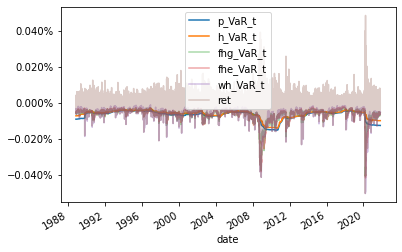

In [200]:
ax = df_eval_aug[['p_VaR_t','h_VaR_t']].plot()
ax = df_eval_aug['fhg_VaR_t'].plot(alpha=0.4)
ax = df_eval_aug['fhe_VaR_t'].plot(alpha=0.4)
ax = df_eval_aug['wh_VaR_t'].plot(alpha=0.4)
ax = df_eval_aug['ret'].plot(alpha=0.3)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [201]:
VaR_t_aug=pd.DataFrame(index=df_eval_aug.index, columns= ['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t'])

VaR_t_aug['p_VaR_t']= df_eval_aug['ret']<df_eval_aug['p_VaR_t']
VaR_t_aug['h_VaR_t']= df_eval_aug['ret']<df_eval_aug['h_VaR_t']
VaR_t_aug['fhg_VaR_t']= df_eval_aug['ret']<df_eval_aug['fhg_VaR_t']
VaR_t_aug['fhe_VaR_t']= df_eval_aug['ret']<df_eval_aug['fhe_VaR_t']
VaR_t_aug['wh_VaR_t']= df_eval_aug['ret']<df_eval_aug['wh_VaR_t']

VaR_t_2_aug=VaR_t_aug.groupby(pd.Grouper(freq='Y')).sum()
pd.DataFrame(columns=['Average Number of Excedences per Year'],data=VaR_t_2_aug.mean().round(2))

,Average Number of Excedences per Year
p_VaR_t,10.38
h_VaR_t,12.85
fhg_VaR_t,10.50
fhe_VaR_t,11.59
wh_VaR_t,15.24


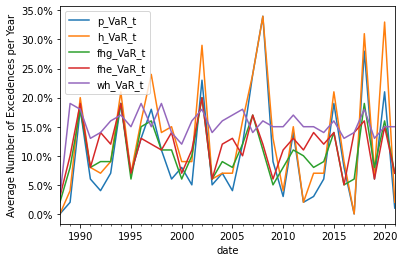

In [202]:
ax = VaR_t_2_aug.plot()
plt.ylabel('Average Number of Excedences per Year')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

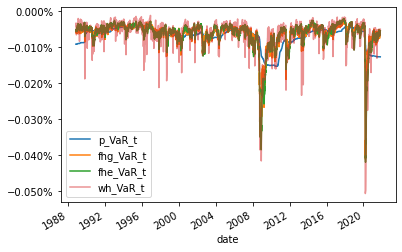

In [203]:
ax = df_eval_aug[['p_VaR_t','fhg_VaR_t','fhe_VaR_t']].plot()
ax = df_eval_aug['wh_VaR_t'].plot(alpha=0.5)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Tracking Error

In [204]:
## Computing the Tracking Error - Comparision: After rebal and before rebal


# computing portf. returns before rebalancing
weights_init=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.5,0.25,0.05,0.12,0.5,0.03]])
portfolio_ret_d_init=pd.DataFrame(index=df_d_ret.index,columns=["ret"], data=np.dot(df_d_ret,weights_init.T))

# computing Tracking Error
tracking_error_daily = pd.DataFrame(portfolio_ret_d_aug['ret'] - portfolio_ret_d_init['ret'])
tracking_error_daily.columns = ['TE']

avg_TE_daily = np.average(tracking_error_daily)

avg_TE_daily

-0.00010460162018579001

# -----------------------  MONTHLY DEFAULT ----------------------- 

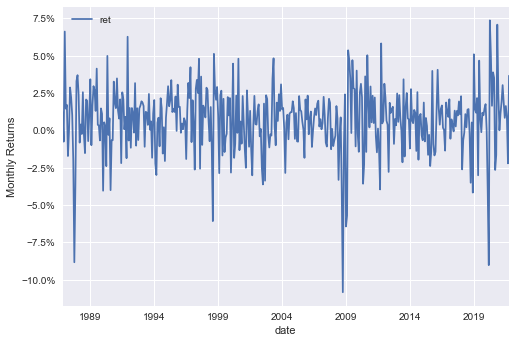

In [1362]:
ax = (portfolio_ret_m*100).plot()
plt.ylabel('Monthly Returns')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

array([[<AxesSubplot:title={'center':'ret'}>]], dtype=object)

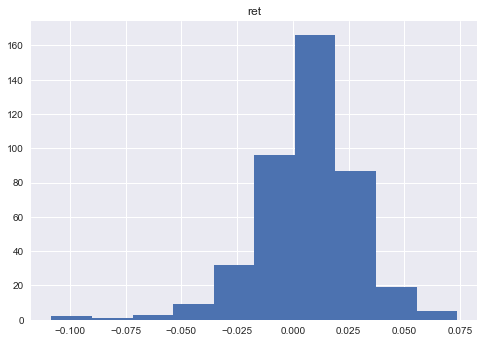

In [1363]:
ax = portfolio_ret_m.hist()
ax

In [1364]:
mean_m=portfolio_ret_m['ret'].mean()
std_m=portfolio_ret_m['ret'].std()
max_m = portfolio_ret_m['ret'].max()
min_m = portfolio_ret_m['ret'].min()
kurt_m = sp.kurtosis(portfolio_ret_m['ret'])
skew_m = sp.skew(portfolio_ret_m['ret'])

In [1365]:
normalized_portfolio_ret_m=(portfolio_ret_m-mean_m)/std_m

In [1366]:
normalized_portfolio_ret_m

,ret
date,
1986-11-30,0.22959
1986-12-31,-0.64863
1987-01-31,2.66965
1987-02-28,0.34387
1987-03-31,0.45816
...,...
2021-06-30,0.06734
2021-07-31,0.42561
2021-08-31,0.08542


In [1367]:
mean_norm_m = normalized_portfolio_ret_m['ret'].mean()
std_norm_m = normalized_portfolio_ret_m['ret'].std()
max_norm_m = normalized_portfolio_ret_m['ret'].max()
min_norm_m = normalized_portfolio_ret_m['ret'].min()
kurt_norm_m = sp.kurtosis(normalized_portfolio_ret_m['ret'])
skew_norm_m = sp.skew(normalized_portfolio_ret_m['ret'])

# Fitting Garch Model

In [1368]:
model_garch = arch_model(y=portfolio_ret_m['ret']*100, rescale=True, mean='Zero')
res_garch_m = model_garch.fit(backcast=(portfolio_ret_m['ret'][0]*100)**2)
res_garch_m

Iteration:      1,   Func. Count:      5,   Neg. LLF: 954.557172141135
Iteration:      2,   Func. Count:     12,   Neg. LLF: 974.0626539252892
Iteration:      3,   Func. Count:     17,   Neg. LLF: 951.8334661871922
Iteration:      4,   Func. Count:     22,   Neg. LLF: 938.6876714712744
Iteration:      5,   Func. Count:     27,   Neg. LLF: 935.0786491810272
Iteration:      6,   Func. Count:     31,   Neg. LLF: 935.0292177018316
Iteration:      7,   Func. Count:     35,   Neg. LLF: 935.0265683825637
Iteration:      8,   Func. Count:     39,   Neg. LLF: 935.0256978115256
Iteration:      9,   Func. Count:     43,   Neg. LLF: 935.0256111130335
Iteration:     10,   Func. Count:     47,   Neg. LLF: 935.0256076136076
Iteration:     11,   Func. Count:     50,   Neg. LLF: 935.0256076134956
Optimization terminated successfully    (Exit mode 0)
            Current function value: 935.0256076136076
            Iterations: 11
            Function evaluations: 50
            Gradient evaluations: 11


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -935.026
Distribution:                  Normal   AIC:                           1876.05
Method:            Maximum Likelihood   BIC:                           1888.17
                                        No. Observations:                  420
Date:                Tue, Feb 08 2022   Df Residuals:                      420
Time:                        16:06:35   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.8340      1.375      1.334      0.182    [ -

In [1369]:
scale = res_garch_m.scale
scale

1.0

In [1370]:
forecasts_garch_m = res_garch_m.forecast(horizon=1, reindex=True)

In [1371]:
vol_garch_for_m = (forecasts_garch_m.variance.iloc[-1]/10000)**0.5

In [1372]:
std_m

0.022213872372445213

In [1373]:
vol_garch_for_m[0]

0.026527082830613457

# Fitting EWMA Model

In [1374]:
am_m = ZeroMean(portfolio_ret_m['ret']*100)
am_m.volatility = EWMAVariance(None)
am_m.distribution = Normal()
res_m = am_m.fit(backcast=(portfolio_ret_m['ret'][0]*100)**2)
res_m

Iteration:      1,   Func. Count:      3,   Neg. LLF: 47653.21767479356
Iteration:      2,   Func. Count:      6,   Neg. LLF: 954.4531126837683
Iteration:      3,   Func. Count:      8,   Neg. LLF: 954.2726232795674
Iteration:      4,   Func. Count:     10,   Neg. LLF: 954.2532246740832
Iteration:      5,   Func. Count:     12,   Neg. LLF: 954.2528592010128
Iteration:      6,   Func. Count:     14,   Neg. LLF: 954.2528585921989
Optimization terminated successfully    (Exit mode 0)
            Current function value: 954.2528585921989
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 6


                  Zero Mean - EWMA/RiskMetrics Model Results                  
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:               -954.253
Distribution:                  Normal   AIC:                           1910.51
Method:            Maximum Likelihood   BIC:                           1914.55
                                        No. Observations:                  420
Date:                Tue, Feb 08 2022   Df Residuals:                      420
Time:                        16:06:37   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
lam            0.8798  4.301e-02     20.454  5.524e-93 [  0.795,  0.96

In [1375]:
forecasts_res_m = res_m.forecast(horizon=1, reindex=True)
vol_ewma_for_m = (forecasts_res_m.variance.iloc[-1]/10000)**0.5

vol_ewma_for_m[0]

0.028584797409204377

# Definging Garch and Emwa Volatilities
# Definging Forecast Parameters: Omega, Alpha, Beta, Lambda

In [1376]:
forc_vol_emwa_m = (forecasts_res_m.variance.iloc[-1]/10000)**0.5

In [1377]:
forc_vol_garch_m = (forecasts_garch_m.variance.iloc[-1]/10000)**0.5

In [1378]:
omega_m = res_garch_m.params[0]/10000
alpha_m = res_garch_m.params[1]
beta_m = res_garch_m.params[2]
lamb_m = res_m.params[0]

In [1379]:
lt_var_m = omega_m/(1-alpha_m-beta_m)
lt_vol_m = lt_var_m**(1/2)

In [1380]:
obsv_vol_m = portfolio_ret_m['ret'].std()

obsv_vol_m

0.022213872372445213

In [1381]:
L1_m = [alpha_m.round(4), beta_m.round(4), (omega_m*10000).round(4), lamb_m.round(4)]
L2_m = [np.round(obsv_vol_m, 4), forc_vol_garch_m[0].round(4), forc_vol_emwa_m[0].round(4), lt_vol_m.round(4)]

In [1382]:
est_patam_m = pd.DataFrame(columns=['Alpha', 'Beta', 'Omega', 'Lamda'])
vols_m = pd.DataFrame(columns=['Obsv. Vola', 'Vola GARCH', 'Vola EWMA', 'LT Vola GARCH'])

In [1390]:
est_patam_m.loc['Values'] = L1_m

est_patam_m.applymap('{:,.4f}'.format)

,Alpha,Beta,Omega,Lamda
Values,0.2369,0.4328,1.8340,0.8798


In [1392]:
vols_m.loc['Values'] = L2_m

(vols_m*100).applymap('{:,.2f}%'.format)

,Obsv. Vola,Vola GARCH,Vola EWMA,LT Vola GARCH
Values,2.22%,2.65%,2.86%,2.36%


## Cerating DataFrame with EWMA weights

In [1393]:
L_weights_emwa_m = []

In [1394]:
for t in range(0, len(portfolio_ret_m)):
    L_weights_emwa_m.append((lamb_m**t)*(1-lamb_m))

In [1395]:
L_weights_emwa_m.reverse()

In [1396]:
weights_emwa_m = pd.DataFrame(columns=['weights', 'acum_weights'])
weights_emwa_m['weights'] = L_weights_emwa_m

In [1397]:
for y in range(0, len(weights_emwa_m)):
    if y==0:
        weights_emwa_m.iloc[y, 1] = weights_emwa_m.iloc[y, 0]
    else: weights_emwa_m.iloc[y, 1] = weights_emwa_m.iloc[y-1, 1] + weights_emwa_m.iloc[y, 0]

In [1398]:
weights_emwa_m.index=portfolio_ret_m.index
weights_emwa_m.tail(15)

,weights,acum_weights
date,,
2020-08-31,0.02001,0.16641
2020-09-30,0.02274,0.18915
2020-10-31,0.02585,0.215
2020-11-30,0.02938,0.24438
2020-12-31,0.03340,0.27777
2021-01-31,0.03796,0.31573
2021-02-28,0.04315,0.35888
2021-03-31,0.04905,0.40793
2021-04-30,0.05575,0.46368


# Preparing DataFrame to generate data (portfolio_ret_m)

### Columns: Returns, Conditional Var Garch, Conditional Var Emwa, Conditional Vol Garch, Conditonal Vol Emwa, Model Vol Garch, Model Emwa, Z-Garch, Z-Emwa, Returns Garch, Returns Emwa

In [1399]:
portfolio_ret_m['cond_var_garch'] = 0
portfolio_ret_m['cond_var_emwa'] = 0
portfolio_ret_m['cond_vol_garch'] = 0
portfolio_ret_m['cond_vol_emwa'] = 0
portfolio_ret_m['model_vol_garch'] = 0
portfolio_ret_m['model_vol_emwa'] = 0
portfolio_ret_m['z_garch'] = 0
portfolio_ret_m['z_emwa'] = 0
portfolio_ret_m['resc_r_garch'] = 0
portfolio_ret_m['resc_r_emwa'] = 0

# Looping on data to generate Rescaled Returns on Garch and Emwa

In [1400]:
for i in range(0,len(portfolio_ret_m)):
    if i == 0:
        portfolio_ret_m.iloc[i,1] = portfolio_ret_m.iloc[i,0]**2
    else: portfolio_ret_m.iloc[i,1] = omega_m + alpha_m*portfolio_ret_m.iloc[i-1,0]**2  + beta_m*portfolio_ret_m.iloc[i-1,1] 

In [1401]:
for z in range(0,len(portfolio_ret_m)):
    if z == 0:
        portfolio_ret_m.iloc[z, 2] = portfolio_ret_m.iloc[z, 0]**2
    else: portfolio_ret_m.iloc[z, 2] = (1 - lamb_m)*portfolio_ret_m.iloc[z-1, 0]**2 + lamb_m*portfolio_ret_m.iloc[z-1, 2]

In [1402]:
portfolio_ret_m['cond_vol_garch'] = portfolio_ret_m['cond_var_garch']**(1/2)
portfolio_ret_m['cond_vol_emwa'] = portfolio_ret_m['cond_var_emwa']**(1/2)

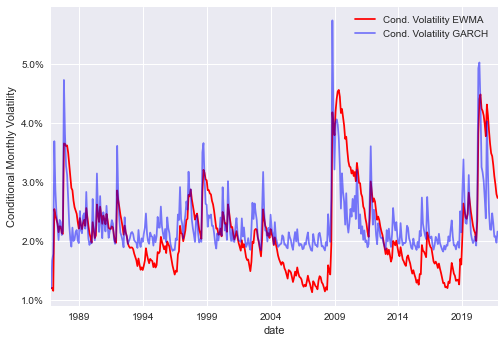

In [1403]:
ax = (portfolio_ret_m['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA')
ax = (portfolio_ret_m['cond_vol_garch']*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Monthly Volatility')
plt.legend(si)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

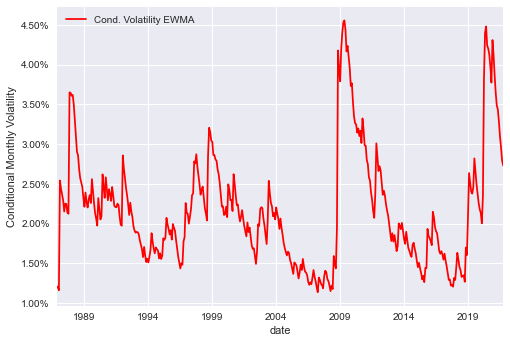

In [1404]:
ax = (portfolio_ret_m['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA')
plt.ylabel('Conditional Monthly Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

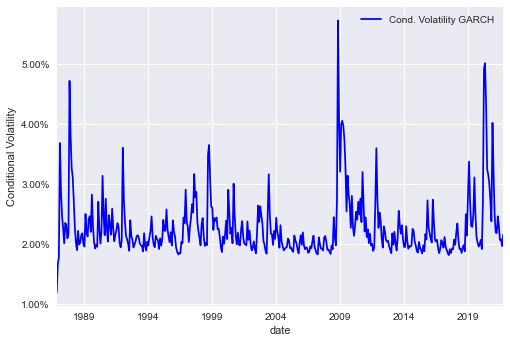

In [1405]:
ax = (portfolio_ret_m['cond_vol_garch']*100).plot(c='blue', label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

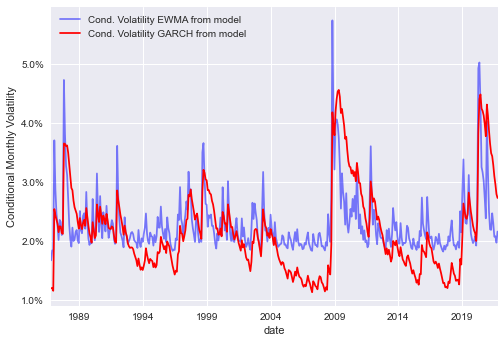

In [1406]:
ax = ((((res_garch_m.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA from model')
ax = ((((res_m.conditional_volatility**2)/10000)**0.5)*100).plot(c='red', label = 'Cond. Volatility GARCH from model')
plt.ylabel('Conditional Monthly Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

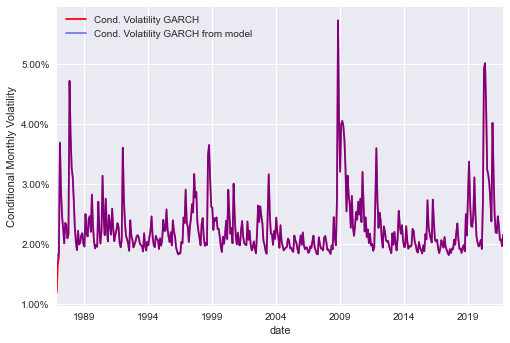

In [1407]:
ax = (portfolio_ret_m['cond_vol_garch']*100).plot(c='red', label = 'Cond. Volatility GARCH')
ax = ((((res_garch_m.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH from model')
plt.ylabel('Conditional Monthly Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

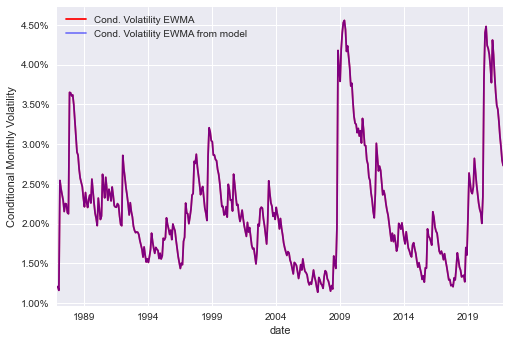

In [1408]:
ax = (portfolio_ret_m['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA')
ax = ((((res_m.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA from model')
plt.ylabel('Conditional Monthly Volatility')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1409]:
portfolio_ret_m['model_vol_garch']=((res_garch_m.conditional_volatility**2)/10000)**0.5
portfolio_ret_m['model_vol_emwa']=((res_m.conditional_volatility**2)/10000)**0.5

In [1410]:
portfolio_ret_m['z_garch'] = portfolio_ret_m['ret']/portfolio_ret_m['cond_vol_garch']
portfolio_ret_m['z_emwa'] = portfolio_ret_m['ret']/portfolio_ret_m['cond_vol_emwa']

In [1411]:
for g in range(0, len(portfolio_ret_m)-1):
    portfolio_ret_m.iloc[g, 9] = portfolio_ret_m.iloc[g,7] * forc_vol_emwa_m

In [1412]:
for h in range(0, len(portfolio_ret_m)-1):
    portfolio_ret_m.iloc[h, 10] = portfolio_ret_m.iloc[h,8] * forc_vol_garch_m

In [1413]:
portfolio_ret_m

,ret,cond_var_garch,cond_var_emwa,cond_vol_garch,cond_vol_emwa,model_vol_garch,model_vol_emwa,z_garch,z_emwa,resc_r_garch,resc_r_emwa
date,,,,,,,,,,,
1986-11-30,0.01204,0.00015,0.00015,0.01204,0.01204,0.01675,0.01204,1.00000,1.00000,0.02858,0.02653
1986-12-31,-0.00746,0.00028,0.00015,0.01675,0.01204,0.01842,0.01204,-0.44561,-0.61968,-0.01274,-0.01644
1987-01-31,0.06625,0.00032,0.00013,0.01783,0.01159,0.01853,0.01159,3.71491,5.71588,0.10619,0.15163
1987-02-28,0.01458,0.00136,0.00065,0.03689,0.02541,0.03704,0.02541,0.39535,0.57384,0.01130,0.01522
1987-03-31,0.01712,0.00082,0.00059,0.02868,0.02437,0.02876,0.02437,0.59697,0.70267,0.01706,0.01864
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,0.00844,0.00053,0.00108,0.02305,0.03288,0.02305,0.03288,0.36624,0.25669,0.01047,0.00681
2021-07-31,0.01640,0.00043,0.00096,0.02074,0.03098,0.02074,0.03098,0.79069,0.52933,0.02260,0.01404
2021-08-31,0.00884,0.00043,0.00088,0.02082,0.02961,0.02082,0.02961,0.42480,0.29862,0.01214,0.00792


In [1414]:
mean_garch_m = portfolio_ret_m['z_garch'].mean()
std_garch_m = portfolio_ret_m['z_garch'].std()
max_garch_m = portfolio_ret_m['z_garch'].max() 
min_garch_m = portfolio_ret_m['z_garch'].min()
kurt_garch_m = sp.kurtosis(portfolio_ret_m['z_garch'])
skew_garch_m = sp.skew(portfolio_ret_m['z_garch'])

In [1415]:
mean_ewma_m = portfolio_ret_m['z_emwa'].mean()
std_ewma_m = portfolio_ret_m['z_emwa'].std()
max_ewma_m = portfolio_ret_m['z_emwa'].max() 
min_ewma_m = portfolio_ret_m['z_emwa'].min()
kurt_ewma_m = sp.kurtosis(portfolio_ret_m['z_emwa'])
skew_ewma_m = sp.skew(portfolio_ret_m['z_emwa'])

## Statistics Table

In [1416]:
df_stats = pd.DataFrame(index=['min', 'max', 'mean', 'kurtosis', 'skewness'])

In [1417]:
df_stats['Returs'] = [min_m, max_m, mean_m, kurt_m, skew_m]
df_stats['Normalized Returns'] = [min_norm_m, max_norm_m, mean_norm_m, kurt_norm_m, skew_norm_m]
df_stats['Garch z-scores'] = [min_garch_m, max_garch_m, mean_garch_m, kurt_garch_m, skew_garch_m]
df_stats['Ewma z-scores'] = [min_ewma_m, max_ewma_m, mean_ewma_m, kurt_ewma_m, skew_ewma_m]

df_stats.applymap('{:,.8f}'.format)

,Returs,Normalized Returns,Garch z-scores,Ewma z-scores
min,-0.10831409,-5.18859387,-4.06581325,-5.55299440
max,0.07372056,3.00604431,3.71491164,5.71588231
mean,0.00694467,0.00000000,0.29988325,0.31302715
kurtosis,3.16023796,3.16023796,2.39217002,4.25893927
skewness,-0.76351600,-0.76351600,-0.70682239,-0.70234415


# Prepating new DataFrame to generate risk measures

In [1418]:
df_returns_m = pd.DataFrame()

In [1419]:
df_returns_m['Returns'] = portfolio_ret_m['ret']
df_returns_m['Returns_Garch'] = portfolio_ret_m['resc_r_garch']
df_returns_m['Returns_Emwa'] = portfolio_ret_m['resc_r_emwa']

df_returns_m

,Returns,Returns_Garch,Returns_Emwa
date,,,
1986-11-30,0.01204,0.02858,0.02653
1986-12-31,-0.00746,-0.01274,-0.01644
1987-01-31,0.06625,0.10619,0.15163
1987-02-28,0.01458,0.01130,0.01522
1987-03-31,0.01712,0.01706,0.01864
...,...,...,...
2021-06-30,0.00844,0.01047,0.00681
2021-07-31,0.01640,0.02260,0.01404
2021-08-31,0.00884,0.01214,0.00792


## Generating Risk Measures for each Look-back Period

In [1420]:
df_risk_measures_m = pd.DataFrame(index=['VaR_PreC','VaR_PostC','ES_PreC','ES_PostC'], columns=['Param', 'Hist', 'Fhist_G', 'Fhist_E', 'Whist'])

In [1421]:
df_25_m = df_returns_m.iloc[-25:,:].copy()

df_25_m

,Returns,Returns_Garch,Returns_Emwa
date,,,
2019-10-31,0.01018,0.01431,0.01135
2019-11-30,0.01476,0.02146,0.01734
2019-12-31,0.01766,0.02517,0.02150
2020-01-31,0.00052,0.00071,0.00064
2020-02-29,-0.04043,-0.06006,-0.05358
2020-03-31,-0.09016,-0.09534,-0.10208
2020-04-30,0.07372,0.04279,0.05118
2020-05-31,0.05013,0.02855,0.03021
2020-06-30,0.01654,0.01094,0.00979


In [1422]:
lb_25_vol_m= ((df_25_m['Returns']**2).mean())**0.5

In [1423]:
var_param_m = sp.norm.ppf(0.95)*lb_25_vol_m

In [1424]:
es_param_m = sp.norm.pdf(sp.norm.ppf(0.95))*lb_25_vol_m/0.05

In [1425]:
var_25_hist_m = df_25_m['Returns'].quantile(q=0.05)

In [1426]:
es_25_hist_m = (df_25_m['Returns'][(df_25_m['Returns']<df_25_m['Returns'].quantile(q=0.05))]).mean()

In [1427]:
var_25_fhist_g_m = df_25_m['Returns_Garch'].quantile(q=0.05)

In [1428]:
es_25_fhist_g_m = (df_25_m['Returns_Garch'][(df_25_m['Returns_Garch']<df_25_m['Returns_Garch'].quantile(q=0.05))]).mean()

In [1429]:
var_25_fhist_e_m = df_25_m['Returns_Emwa'].quantile(q=0.05)

In [1430]:
es_25_fhist_e_m = (df_25_m['Returns_Emwa'][(df_25_m['Returns_Emwa']<df_25_m['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1431]:
weights_emwa_25_m=weights_emwa_m.loc[df_25_m.index,:].copy()
adj_m=lamb_m**25
n_w_m=weights_emwa_25_m['weights']/(1-adj_m)
df_25_m['weights']=n_w_m
df_25_m['weights'].sum()

1.0

In [1432]:
df_25_m.sort_values('Returns', inplace=True)
df_25_m['acum_weights'] = 0

for y in range(0, len(df_25_m.index)):
    if y==0:
        df_25_m.iloc[y, 4] = df_25_m.iloc[y, 3]
    else: df_25_m.iloc[y, 4] = df_25_m.iloc[y-1, 4] + df_25_m.iloc[y, 3]

In [1433]:
w_hist_df_m=df_25_m[df_25_m['acum_weights']<=0.05]

hr_m=df_25_m.iloc[len(w_hist_df_m),0]
hw_m=df_25_m.iloc[len(w_hist_df_m),4]
lr_m=w_hist_df_m.iloc[-1,0]
lw_m=w_hist_df_m.iloc[-1,4]

w_hist_VaR_m=lr_m+(0.05-lw_m)*(hr_m-lr_m)/(hw_m-lw_m)
w_hist_ES_m=(w_hist_df_m['Returns']*w_hist_df_m['weights']).sum()/0.05

In [1434]:
VaR_25_m = [var_param_m, -var_25_hist_m, -var_25_fhist_g_m, -var_25_fhist_e_m, -w_hist_VaR_m]
ES_25_m = [es_param_m, -es_25_hist_m, -es_25_fhist_g_m, -es_25_fhist_e_m, -w_hist_ES_m]

In [1435]:
df_risk_measures_m.loc['VaR_PreC']=VaR_25_m
df_risk_measures_m.loc['ES_PreC']=ES_25_m

In [1436]:
(df_risk_measures_m*100).applymap('{:,.2f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,5.88%,3.76%,5.44%,4.70%,2.62%
VaR_PostC,nan%,nan%,nan%,nan%,nan%
ES_PreC,7.37%,6.53%,7.77%,7.78%,4.02%
ES_PostC,nan%,nan%,nan%,nan%,nan%


### PostCovid

In [1437]:
df_13_m = df_returns_m.iloc[-13:,:].copy()

df_13_m

,Returns,Returns_Garch,Returns_Emwa
date,,,
2020-10-31,-0.01644,-0.01724,-0.01097
2020-11-30,0.07088,0.08494,0.04983
2020-12-31,0.02361,0.01677,0.01454
2021-01-31,0.00011,0.00010,0.00007
2021-02-28,0.01135,0.01299,0.00778
2021-03-31,0.01915,0.02489,0.01392
2021-04-30,0.03041,0.03969,0.02313
2021-05-31,0.01881,0.02177,0.01452
2021-06-30,0.00844,0.01047,0.00681


In [1438]:
lb_13_vol_m= ((df_13_m['Returns']**2).mean())**0.5

In [1439]:
var_13_param_m = sp.norm.ppf(0.95)*lb_13_vol_m

In [1440]:
es_13_param_m = sp.norm.pdf(sp.norm.ppf(0.95))*lb_13_vol_m/0.05

In [1441]:
var_13_hist_m = df_13_m['Returns'].quantile(q=0.05)

In [1442]:
es_13_hist_m = (df_13_m['Returns'][(df_13_m['Returns']<df_13_m['Returns'].quantile(q=0.05))]).mean()

In [1443]:
var_13_fhist_g_m = df_13_m['Returns_Garch'].quantile(q=0.05)

In [1444]:
es_13_fhist_g_m = (df_13_m['Returns_Garch'][(df_13_m['Returns_Garch']<df_13_m['Returns_Garch'].quantile(q=0.05))]).mean()

In [1445]:
var_13_fhist_e_m = df_13_m['Returns_Emwa'].quantile(q=0.05)

In [1446]:
es_13_fhist_e_m = (df_13_m['Returns_Emwa'][(df_13_m['Returns_Emwa']<df_13_m['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1447]:
weights_emwa_13_m=weights_emwa_m.loc[df_13_m.index,:]
adj_m=lamb_m**13
n_w_m=weights_emwa_13_m['weights']/(1-adj_m)
df_13_m['weights']=n_w_m
df_13_m['weights'].sum()

0.9999999999999999

In [1448]:
df_13_m.sort_values('Returns', inplace=True)
df_13_m['acum_weights'] = 0

for y in range(0, len(df_13_m.index)):
    if y==0:
        df_13_m.iloc[y, 4] = df_13_m.iloc[y, 3]
    else: df_13_m.iloc[y, 4] = df_13_m.iloc[y-1, 4] + df_13_m.iloc[y, 3]

In [1449]:
#w_hist_df_m=df_13_m[df_13_m['acum_weights']<=0.05]

#hr_m=df_13_m.iloc[len(w_hist_df_m),0]
#hw_m=df_13_m.iloc[len(w_hist_df_m),4]
#lr_m=w_hist_df_m.iloc[-1,0]
#lw_m=w_hist_df_m.iloc[-1,4]

#w_hist_VaR_m=lr_m+(0.05-lw_m)/(hw_m-lw_m)*(hr_m-lr_m)
#w_hist_ES_m=(w_hist_df_m['Returns']*w_hist_df_m['weights']).sum()/0.05

# Here VaR and ES are the mimimum because the acumulative weights of the minimum return is already above 5%

w_hist_df_m=pd.DataFrame(df_13_m.iloc[0,:]).copy()
w_hist_VaR_m=w_hist_df_m.loc['Returns']
w_hist_VaR_m=w_hist_VaR_m[0]
w_hist_ES_m=(w_hist_df_m.loc['Returns']*w_hist_df_m.loc['weights']).sum()/0.05

In [1450]:
VaR_13_m = [var_param_m, -var_13_hist_m, -var_13_fhist_g_m, -var_13_fhist_e_m, -w_hist_VaR_m]
ES_13_m = [es_param_m, -es_13_hist_m, -es_13_fhist_g_m, -es_13_fhist_e_m, -w_hist_ES_m]

In [1451]:
df_risk_measures_m.loc['VaR_PostC']=VaR_13_m
df_risk_measures_m.loc['ES_PostC']=ES_13_m

In [1452]:
(df_risk_measures_m*100).applymap('{:,.2f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,5.88%,3.76%,5.44%,4.70%,2.62%
VaR_PostC,5.88%,1.87%,2.31%,1.49%,2.20%
ES_PreC,7.37%,6.53%,7.77%,7.78%,4.02%
ES_PostC,7.37%,2.20%,3.19%,2.09%,5.74%


In [1453]:
df_risk_measures_m.iloc[1,2]

0.023102116891126987

# Evaluation of volatility

In [1454]:
df_eval_m = portfolio_ret_m.iloc[24:,:]
bias_garch_m =  df_eval_m['z_garch'].std()
bias_ewma_m =  df_eval_m['z_emwa'].std()

df_bias_m = pd.DataFrame(index=['Stdv'], columns=['Garch', 'EWMA'], data= [[bias_garch_m,bias_ewma_m]])
df_bias_m.applymap('{:,.2f}'.format) 

,Garch,EWMA
Stdv,0.93,1.04


In [1455]:
low_interval_confidence_m = 1-(2/((len(portfolio_ret_m)-25)))**0.5
high_interval_confidence_m = 1+(2/((len(portfolio_ret_m)-25)))**0.5

df_bias_int_m = pd.DataFrame(index=['95% Confidence Intervals'], columns=['Low Interval', 'High Interval'], data= [[low_interval_confidence_m, high_interval_confidence_m]])
df_bias_int_m.applymap('{:,.2f}'.format)  

,Low Interval,High Interval
95% Confidence Intervals,0.93,1.07


In [1456]:
df_eval_m[['garch_std','ewma_std']] = 5
z_m = []

for i in range(0,len(df_eval_m)):
    z_m.append(portfolio_ret_m.iloc[i:24+i,7].std())
    
df_eval_m['garch_std'] = z_m

In [1457]:
y_m = []

for i in range(0,len(df_eval_m)):
    y_m.append(portfolio_ret_m.iloc[i:24+i,8].std())
    
df_eval_m['ewma_std'] = y_m

In [1458]:
bias_garch_2_m = abs((df_eval_m['garch_std']-1)).mean()
bias_ewma_2_m = abs((df_eval_m['ewma_std']-1)).mean()

df_MRAD_m = pd.DataFrame(index=['MRAD'], columns=['Garch', 'EWMA'], data= [[bias_garch_2_m,bias_ewma_2_m]])
df_MRAD_m.applymap('{:,.2f}'.format)  

,Garch,EWMA
MRAD,0.19,0.17


In [1459]:
skew_garch_m =  sp.skew(df_eval_m['z_garch'])
skew_ewma_m =  sp.skew(df_eval_m['z_emwa'])
skew_ret_m =  sp.skew(df_eval_m['ret'])
kurt_garch_m =  sp.kurtosis(df_eval_m['z_garch'])
kurt_ewma_m =  sp.kurtosis(df_eval_m['z_emwa'])
kurt_ret_m =  sp.kurtosis(df_eval_m['ret'])

zg_mn_m=df_eval_m['z_garch'].mean()
ze_mn_m=df_eval_m['z_garch'].mean()
r_mn_m=df_eval_m['ret'].mean()
zg_mdn_m=df_eval_m['z_emwa'].median()
ze_mdn_m=df_eval_m['z_emwa'].median()
r_mdn_m=df_eval_m['ret'].median()

r_skew_garch_m =  (zg_mn_m-zg_mdn_m)/bias_garch_m
r_skew_ewma_m =  (ze_mn_m-ze_mdn_m)/bias_ewma_m
r_skew_r_m = (r_mn_m-r_mdn_m)/df_eval_m['ret'].std()

df_dist_m = pd.DataFrame(index=['Skew','Robust Skew','Kurtosis'], columns=['Ret','Garch', 'EWMA'], data= [[skew_ret_m,skew_garch_m,skew_ewma_m],[r_skew_r_m,r_skew_garch_m,r_skew_ewma_m],[kurt_ret_m,kurt_garch_m,kurt_ewma_m]])
df_dist_m.applymap('{:,.8f}'.format) 

,Ret,Garch,EWMA
Skew,-0.70077231,-0.68218177,-0.97609555
Robust Skew,-0.07982337,-0.18735393,-0.16794268
Kurtosis,3.00707364,1.69959753,3.14345360


In [1460]:
df_eval_m[['QL_G','QL_E','d']] = 5

df_eval_m['QL_G']=np.log(df_eval_m['z_garch']**2)-df_eval_m['z_garch']**2
df_eval_m['QL_E']=np.log(df_eval_m['z_emwa']**2)-df_eval_m['z_emwa']**2
df_eval_m['d'] = df_eval_m['QL_G'] - df_eval_m['QL_E']

mean_d_m = np.round(df_eval_m['d'].mean(),2)
std_d_m = np.round(df_eval_m['d'].std()/((len(portfolio_ret_m)-25)**0.5),2)
t_d_m = np.round(mean_d_m/std_d_m.round(2),2)
sum_QL1_m = np.round(df_eval_m['QL_G'].sum(),2)
sum_QL2_m = np.round(df_eval_m['QL_E'].sum(),2)


df_QL_m = pd.DataFrame(index=['Sum_QL','Avg_d','t_d'], columns=['Garch', 'EWMA', 'A-B'], data= [[f'{sum_QL1_m:,}',f'{sum_QL2_m:,}',''],['','',mean_d_m],['','',t_d_m]])
df_QL_m

,Garch,EWMA,A-B
Sum_QL,-867.62,-885.41,
Avg_d,,,0.04
t_d,,,0.8


# Evaluation of VaR

In [1461]:
df_eval_m[['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t']] = 5

In [1462]:
a = []
for i in range(0,len(df_eval_m)):
    v= portfolio_ret_m.iloc[i:24+i,0].std()
    a.append(-sp.norm.ppf(0.95)*v)
    
df_eval_m['p_VaR_t'] = a

b = []
for i in range(0,len(df_eval_m)):
    b.append(portfolio_ret_m.iloc[i:24+i,0].quantile(q=0.05))
    
df_eval_m['h_VaR_t'] = b

c = []
for i in range(0,len(df_eval_m)):
    if i < len(df_eval_m)-1:
        c.append((portfolio_ret_m.iloc[i:24+i,0]*portfolio_ret_m.iloc[24+i+1,3]/portfolio_ret_m.iloc[i:24+i,3]).quantile(q=0.05))
    else:
        c.append((portfolio_ret_m.iloc[i:24+i,0]*forc_vol_garch_m[0]/portfolio_ret_m.iloc[i:24+i,3]).quantile(q=0.05))
    
df_eval_m['fhg_VaR_t'] = c

d = []
for i in range(0,len(df_eval_m)):
    if i < len(df_eval_m)-1:
        d.append((portfolio_ret_m.iloc[i:24+i,0]*portfolio_ret_m.iloc[24+i+1,4]/portfolio_ret_m.iloc[i:24+i,4]).quantile(q=0.05))
    else:
        d.append((portfolio_ret_m.iloc[i:24+i,0]*forc_vol_emwa_m[0]/portfolio_ret_m.iloc[i:24+i,4]).quantile(q=0.05))
    
df_eval_m['fhe_VaR_t'] = d

In [1463]:
e = []
for i in range(0,len(df_eval_m)):
    weights_temp=[]
    temp=[]
    w_temp_df=[]
    s=0
    
    weights_temp = weights_emwa_m.iloc[i:24+i,0]
    s = weights_temp.sum()
    weights_temp = weights_temp/s 
    temp = pd.DataFrame(portfolio_ret_m.iloc[i:24+i,0])
    temp['w'] = weights_temp
    temp.sort_values('ret', inplace=True)
    temp['acum_weights'] = 0
    for y in range(0, len(temp.index)):
        if y==0:
            temp.iloc[y, 2] = temp.iloc[y, 1]
        else: temp.iloc[y, 2] = temp.iloc[y-1, 2] + temp.iloc[y, 1]
    w_temp_df=temp.loc[temp['acum_weights']<=0.05,['ret','w','acum_weights']]
    hr_t=temp.iloc[len(w_temp_df),0]
    hw_t=temp.iloc[len(w_temp_df),2]
    if len(w_temp_df.index) > 0:
        lr_t=w_temp_df.iloc[-1,0]
        lw_t=w_temp_df.iloc[-1,2]
        e.append(lr_t+(0.05-lw_t)/(hw_t-lw_t)*(hr_t-lr_t))
    else:
        e.append(temp.iloc[0,0])
    
df_eval_m['wh_VaR_t'] = e

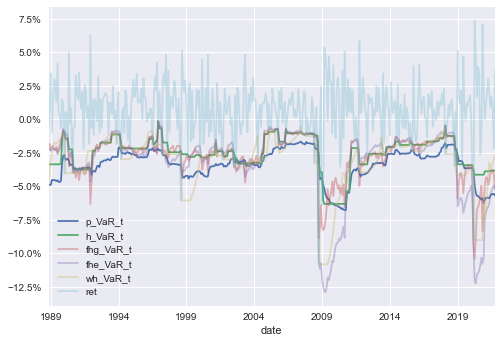

In [1464]:
ax = (df_eval_m[['p_VaR_t','h_VaR_t']]*100).plot()
ax = (df_eval_m['fhg_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m['fhe_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m['wh_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m['ret']*100).plot(alpha=0.3)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1465]:
VaR_t_m=pd.DataFrame(index=df_eval_m.index, columns= ['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t'])

VaR_t_m['p_VaR_t']= df_eval_m['ret']<df_eval_m['p_VaR_t']
VaR_t_m['h_VaR_t']= df_eval_m['ret']<df_eval_m['h_VaR_t']
VaR_t_m['fhg_VaR_t']= df_eval_m['ret']<df_eval_m['fhg_VaR_t']
VaR_t_m['fhe_VaR_t']= df_eval_m['ret']<df_eval_m['fhe_VaR_t']
VaR_t_m['wh_VaR_t']= df_eval_m['ret']<df_eval_m['wh_VaR_t']

VaR_t_2_m=VaR_t_m.groupby(pd.Grouper(freq='Y')).sum()
pd.DataFrame(columns=['Average Number of Excedences per Year'],data=VaR_t_2_m.mean().round(2))

,Average Number of Excedences per Year
p_VaR_t,0.59
h_VaR_t,1.00
fhg_VaR_t,0.88
fhe_VaR_t,1.00
wh_VaR_t,0.79


Text(0, 0.5, 'Average Number of Excedences per Year')

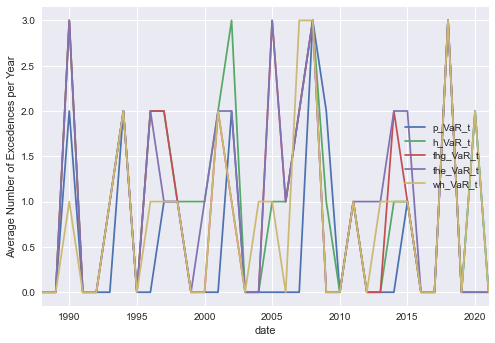

In [1466]:
ax = VaR_t_2_m.plot()
plt.ylabel('Average Number of Excedences per Year')

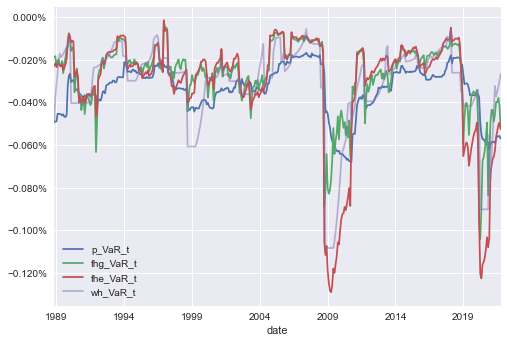

In [1467]:
ax = df_eval_m[['p_VaR_t','fhg_VaR_t','fhe_VaR_t']].plot()
ax = df_eval_m['wh_VaR_t'].plot(alpha=0.5)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ----------------------- MONTHLY AUGMENTED ----------------------- 

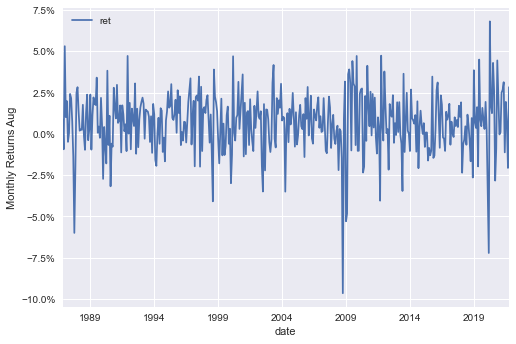

In [1468]:
ax = (portfolio_ret_m_aug*100).plot()
plt.ylabel('Monthly Returns Aug')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

array([[<AxesSubplot:title={'center':'ret'}>]], dtype=object)

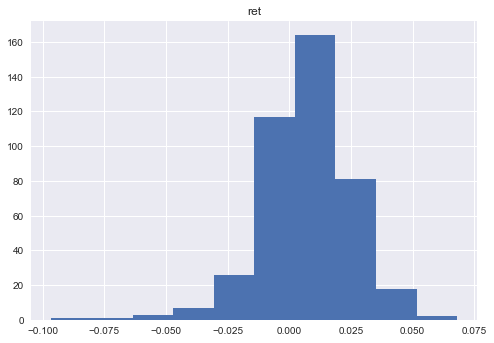

In [1469]:
ax = portfolio_ret_m_aug.hist()
ax

In [1470]:
mean_m_aug = portfolio_ret_m_aug['ret'].mean()
std_m_aug = portfolio_ret_m_aug['ret'].std()
max_m_aug = portfolio_ret_m_aug['ret'].max()
min_m_aug = portfolio_ret_m_aug['ret'].min()
kurt_m_aug = sp.kurtosis(portfolio_ret_m_aug['ret'])
skew_m_aug = sp.skew(portfolio_ret_m_aug['ret'])

In [1471]:
normalized_portfolio_ret_m_aug=(portfolio_ret_m_aug-mean_m_aug)/std_m_aug

In [1472]:
normalized_portfolio_ret_m_aug

,ret
date,
1986-11-30,0.10899
1986-12-31,-0.86856
1987-01-31,2.52215
1987-02-28,0.19011
1987-03-31,0.71538
...,...
2021-06-30,-0.96957
2021-07-31,0.68927
2021-08-31,0.00276


In [1473]:
mean_norm_m_aug = normalized_portfolio_ret_m_aug['ret'].mean()
std_norm_m_aug = normalized_portfolio_ret_m_aug['ret'].std()
max_norm_m_aug = normalized_portfolio_ret_m_aug['ret'].max()
min_norm_m_aug = normalized_portfolio_ret_m_aug['ret'].min()
kurt_norm_m_aug = sp.kurtosis(normalized_portfolio_ret_m_aug['ret'])
skew_norm_m_aug = sp.skew(normalized_portfolio_ret_m_aug['ret'])

# Fitting Garch Model

In [1474]:
model_garch_aug = arch_model(y=portfolio_ret_m_aug['ret']*100, rescale=True, mean='Zero')
res_garch_m_aug = model_garch_aug.fit(backcast=(portfolio_ret_m_aug['ret'][0]*100)**2)
res_garch_m_aug

Iteration:      1,   Func. Count:      5,   Neg. LLF: 928.1627018538229
Iteration:      2,   Func. Count:     12,   Neg. LLF: 877.8222630351756
Iteration:      3,   Func. Count:     18,   Neg. LLF: 880.2302270269513
Iteration:      4,   Func. Count:     24,   Neg. LLF: 870.0320852822867
Iteration:      5,   Func. Count:     29,   Neg. LLF: 869.9898998424794
Iteration:      6,   Func. Count:     33,   Neg. LLF: 869.9866681095808
Iteration:      7,   Func. Count:     37,   Neg. LLF: 869.9863860536977
Iteration:      8,   Func. Count:     41,   Neg. LLF: 869.9856754319256
Iteration:      9,   Func. Count:     45,   Neg. LLF: 869.9856427234755
Iteration:     10,   Func. Count:     48,   Neg. LLF: 869.9856427234313
Optimization terminated successfully    (Exit mode 0)
            Current function value: 869.9856427234755
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 10


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -869.986
Distribution:                  Normal   AIC:                           1745.97
Method:            Maximum Likelihood   BIC:                           1758.09
                                        No. Observations:                  420
Date:                Tue, Feb 08 2022   Df Residuals:                      420
Time:                        16:07:52   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.3217      0.909      1.453      0.146    [ -

In [1475]:
scale_aug = res_garch_m_aug.scale
scale_aug

1.0

In [1476]:
forecasts_garch_m_aug = res_garch_m_aug.forecast(horizon=1, reindex=True)

In [1477]:
vol_garch_for_m_aug = (forecasts_garch_m_aug.variance.iloc[-1]/10000)**0.5

In [1478]:
std_m_aug

0.018408059477582565

In [1479]:
vol_garch_for_m_aug[0]

0.020642583964926953

# Fitting EWMA Model

In [1480]:
am_m_aug = ZeroMean(portfolio_ret_m_aug['ret']*100)
am_m_aug.volatility = EWMAVariance(None)
am_m_aug.distribution = Normal()
res_m_aug = am_m_aug.fit(backcast=(portfolio_ret_m_aug['ret'][0]*100)**2)
res_m_aug

Iteration:      1,   Func. Count:      3,   Neg. LLF: 1395.7972759008592
Iteration:      2,   Func. Count:      6,   Neg. LLF: 899.7530438188779
Iteration:      3,   Func. Count:      9,   Neg. LLF: 899.2797183947242
Iteration:      4,   Func. Count:     11,   Neg. LLF: 899.2780977504908
Iteration:      5,   Func. Count:     13,   Neg. LLF: 899.2780941797025
Iteration:      6,   Func. Count:     14,   Neg. LLF: 899.2780941796323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.2780941797025
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 6


                  Zero Mean - EWMA/RiskMetrics Model Results                  
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:               -899.278
Distribution:                  Normal   AIC:                           1800.56
Method:            Maximum Likelihood   BIC:                           1804.60
                                        No. Observations:                  420
Date:                Tue, Feb 08 2022   Df Residuals:                      420
Time:                        16:07:52   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
lam            0.9605  4.320e-02     22.233 1.640e-109 [  0.876,  1.04

In [1481]:
forecasts_res_m_aug = res_m_aug.forecast(horizon=1, reindex=True)
vol_ewma_for_m_aug = (forecasts_res_m_aug.variance.iloc[-1]/10000)**0.5

vol_ewma_for_m_aug[0]

0.024583528233444438

# Definging Garch and Emwa Volatilities
# Definging Forecast Parameters: Omega, Alpha, Beta, Lambda

In [1482]:
forc_vol_emwa_m_aug = (forecasts_res_m_aug.variance.iloc[-1]/10000)**0.5

In [1483]:
forc_vol_garch_m_aug= (forecasts_garch_m_aug.variance.iloc[-1]/10000)**0.5

In [1484]:
omega_m_aug = res_garch_m_aug.params[0]/10000
alpha_m_aug = res_garch_m_aug.params[1]
beta_m_aug = res_garch_m_aug.params[2]
lamb_m_aug = res_m_aug.params[0]

In [1485]:
lt_var_m_aug = omega_m_aug/(1-alpha_m_aug-beta_m_aug)
lt_vol_m_aug = lt_var_m_aug**(1/2)

In [1486]:
obsv_vol_m_aug = portfolio_ret_m_aug['ret'].std()

obsv_vol_m_aug

0.018408059477582565

In [1487]:
L1_m_aug = [alpha_m_aug.round(4), beta_m_aug.round(4), (omega_m_aug*10000).round(4), lamb_m_aug.round(4)]
L2_m_aug = [np.round(obsv_vol_m_aug, 4), forc_vol_garch_m_aug[0].round(4), forc_vol_emwa_m_aug[0].round(4), lt_vol_m_aug.round(4)]

In [1488]:
est_patam_m_aug = pd.DataFrame(columns=['Alpha', 'Beta', 'Omega', 'Lamda'])
vols_m_aug = pd.DataFrame(columns=['Obsv. Vola', 'Vola GARCH', 'Vola EWMA', 'LT Vola GARCH'])

In [1489]:
est_patam_m_aug.loc['Values'] = L1_m_aug

est_patam_m_aug.applymap('{:,.5f}'.format)

,Alpha,Beta,Omega,Lamda
Values,0.12400,0.52970,1.32170,0.96050


In [1490]:
vols_m_aug.loc['Values'] = L2_m_aug

(vols_m_aug*100).applymap('{:,.2f}%'.format)

,Obsv. Vola,Vola GARCH,Vola EWMA,LT Vola GARCH
Values,1.84%,2.06%,2.46%,1.95%


## Cerating DataFrame with EWMA weights

In [1491]:
L_weights_emwa_m_aug = []

In [1492]:
for t in range(0, len(portfolio_ret_m_aug)):
    L_weights_emwa_m_aug.append((lamb_m_aug**t)*(1-lamb_m_aug))

In [1493]:
L_weights_emwa_m_aug.reverse()

In [1494]:
weights_emwa_m_aug = pd.DataFrame(columns=['weights', 'acum_weights'])
weights_emwa_m_aug['weights'] = L_weights_emwa_m_aug

In [1495]:
for y in range(0, len(weights_emwa_m_aug)):
    if y==0:
        weights_emwa_m_aug.iloc[y, 1] = weights_emwa_m_aug.iloc[y, 0]
    else: weights_emwa_m_aug.iloc[y, 1] = weights_emwa_m_aug.iloc[y-1, 1] + weights_emwa_m_aug.iloc[y, 0]

In [1496]:
weights_emwa_m_aug.index=portfolio_ret_m_aug.index
weights_emwa_m_aug.tail(15)

,weights,acum_weights
date,,
2020-08-31,0.02248,0.56845
2020-09-30,0.02340,0.59185
2020-10-31,0.02437,0.61622
2020-11-30,0.02537,0.64159
2020-12-31,0.02641,0.668
2021-01-31,0.02750,0.69551
2021-02-28,0.02863,0.72414
2021-03-31,0.02981,0.75396
2021-04-30,0.03104,0.785


# Preparing DataFrame to generate data (portfolio_ret_m)

### Columns: Returns, Conditional Var Garch, Conditional Var Emwa, Conditional Vol Garch, Conditonal Vol Emwa, Model Vol Garch, Model Emwa, Z-Garch, Z-Emwa, Returns Garch, Returns Emwa

In [1497]:
portfolio_ret_m_aug['cond_var_garch'] = 0
portfolio_ret_m_aug['cond_var_emwa'] = 0
portfolio_ret_m_aug['cond_vol_garch'] = 0
portfolio_ret_m_aug['cond_vol_emwa'] = 0
portfolio_ret_m_aug['model_vol_garch'] = 0
portfolio_ret_m_aug['model_vol_emwa'] = 0
portfolio_ret_m_aug['z_garch'] = 0
portfolio_ret_m_aug['z_emwa'] = 0
portfolio_ret_m_aug['resc_r_garch'] = 0
portfolio_ret_m_aug['resc_r_emwa'] = 0

# Looping on data to generate Rescaled Returns on Garch and Emwa

In [1498]:
for i in range(0,len(portfolio_ret_m_aug)):
    if i == 0:
        portfolio_ret_m_aug.iloc[i,1] = portfolio_ret_m_aug.iloc[i,0]**2
    else: portfolio_ret_m_aug.iloc[i,1] = omega_m_aug + alpha_m_aug*portfolio_ret_m_aug.iloc[i-1,0]**2  + beta_m_aug*portfolio_ret_m_aug.iloc[i-1,1] 

In [1499]:
for z in range(0,len(portfolio_ret_m_aug)):
    if z == 0:
        portfolio_ret_m_aug.iloc[z, 2] = portfolio_ret_m_aug.iloc[z, 0]**2
    else: portfolio_ret_m_aug.iloc[z, 2] = (1 - lamb_m_aug)*portfolio_ret_m_aug.iloc[z-1, 0]**2 + lamb_m_aug*portfolio_ret_m_aug.iloc[z-1, 2]

In [1500]:
portfolio_ret_m_aug['cond_vol_garch'] = portfolio_ret_m_aug['cond_var_garch']**(1/2)
portfolio_ret_m_aug['cond_vol_emwa'] = portfolio_ret_m_aug['cond_var_emwa']**(1/2)

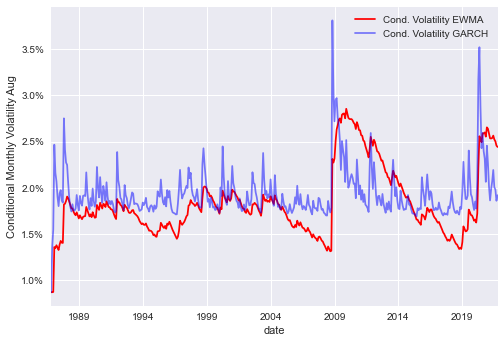

In [1501]:
ax = (portfolio_ret_m_aug['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA')
ax = (portfolio_ret_m_aug['cond_vol_garch']*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH')
plt.ylabel('Conditional Monthly Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

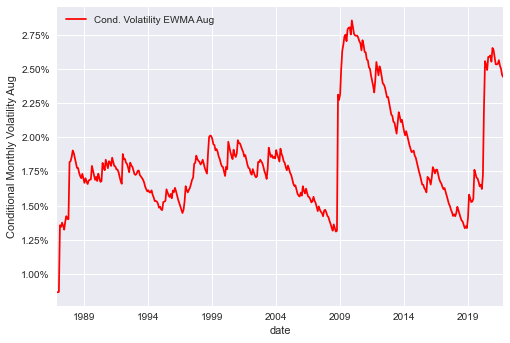

In [1502]:
ax = (portfolio_ret_m_aug['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA Aug')
plt.ylabel('Conditional Monthly Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

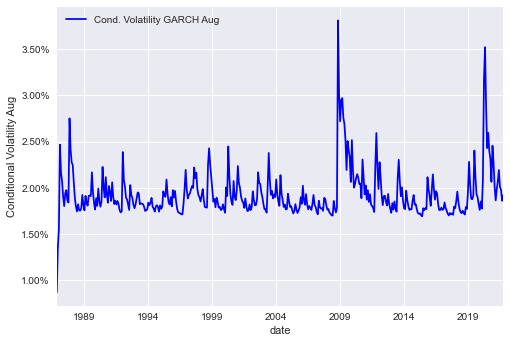

In [1503]:
ax = (portfolio_ret_m_aug['cond_vol_garch']*100).plot(c='blue', label = 'Cond. Volatility GARCH Aug')
plt.ylabel('Conditional Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

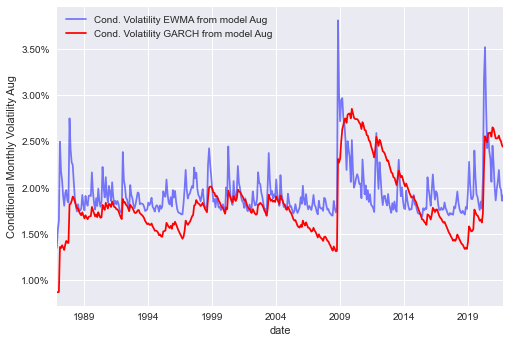

In [1504]:
ax = ((((res_garch_m_aug.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA from model Aug')
ax = ((((res_m_aug.conditional_volatility**2)/10000)**0.5)*100).plot(c='red', label = 'Cond. Volatility GARCH from model Aug')
plt.ylabel('Conditional Monthly Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

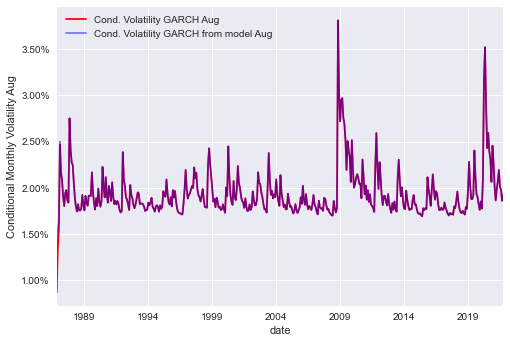

In [1505]:
ax = (portfolio_ret_m_aug['cond_vol_garch']*100).plot(c='red', label = 'Cond. Volatility GARCH Aug')
ax = ((((res_garch_m_aug.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility GARCH from model Aug')
plt.ylabel('Conditional Monthly Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

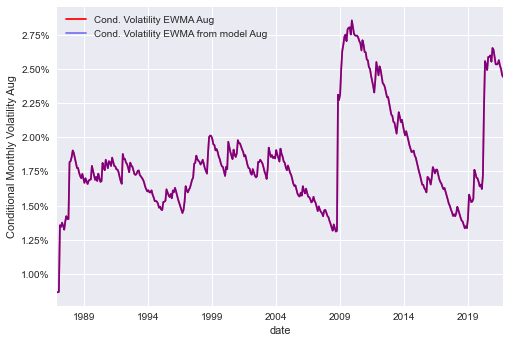

In [1506]:
ax = (portfolio_ret_m_aug['cond_vol_emwa']*100).plot(c='red', label = 'Cond. Volatility EWMA Aug')
ax = ((((res_m_aug.conditional_volatility**2)/10000)**0.5)*100).plot(c='blue', alpha=0.5, label = 'Cond. Volatility EWMA from model Aug')
plt.ylabel('Conditional Monthly Volatility Aug')
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1507]:
portfolio_ret_m_aug['model_vol_garch']=((res_garch_m_aug.conditional_volatility**2)/10000)**0.5
portfolio_ret_m_aug['model_vol_emwa']=((res_m_aug.conditional_volatility**2)/10000)**0.5

In [1508]:
portfolio_ret_m_aug['z_garch'] = portfolio_ret_m_aug['ret']/portfolio_ret_m_aug['cond_vol_garch']
portfolio_ret_m_aug['z_emwa'] = portfolio_ret_m_aug['ret']/portfolio_ret_m_aug['cond_vol_emwa']

In [1509]:
for g in range(0, len(portfolio_ret_m_aug)-1):
    portfolio_ret_m_aug.iloc[g, 9] = portfolio_ret_m_aug.iloc[g,7] * forc_vol_emwa_m_aug

In [1510]:
for h in range(0, len(portfolio_ret_m_aug)-1):
    portfolio_ret_m_aug.iloc[h, 10] = portfolio_ret_m_aug.iloc[h,8] * forc_vol_garch_m_aug

In [1511]:
portfolio_ret_m_aug

,ret,cond_var_garch,cond_var_emwa,cond_vol_garch,cond_vol_emwa,model_vol_garch,model_vol_emwa,z_garch,z_emwa,resc_r_garch,resc_r_emwa
date,,,,,,,,,,,
1986-11-30,0.00866,0.00008,0.00008,0.00866,0.00866,0.01346,0.00866,1.00000,1.00000,0.02458,0.02064
1986-12-31,-0.00933,0.00018,0.00008,0.01346,0.00866,0.01541,0.00866,-0.69329,-1.07749,-0.01704,-0.02224
1987-01-31,0.05308,0.00024,0.00008,0.01546,0.00869,0.01639,0.00869,3.43389,6.10902,0.08442,0.12611
1987-02-28,0.01015,0.00061,0.00018,0.02466,0.01356,0.02498,0.01356,0.41177,0.74875,0.01012,0.01546
1987-03-31,0.01982,0.00047,0.00018,0.02161,0.01344,0.02181,0.01344,0.91723,1.47455,0.02255,0.03044
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,-0.01119,0.00048,0.00066,0.02192,0.02565,0.02192,0.02565,-0.51059,-0.43640,-0.01255,-0.00901
2021-07-31,0.01934,0.00040,0.00064,0.02006,0.02523,0.02006,0.02523,0.96447,0.76658,0.02371,0.01582
2021-08-31,0.00671,0.00039,0.00063,0.01979,0.02503,0.01979,0.02503,0.33887,0.26796,0.00833,0.00553


In [1512]:
mean_garch_m_aug = portfolio_ret_m_aug['z_garch'].mean()
std_garch_m_aug = portfolio_ret_m_aug['z_garch'].std()
max_garch_m_aug = portfolio_ret_m_aug['z_garch'].max() 
min_garch_m_aug = portfolio_ret_m_aug['z_garch'].min()
kurt_garch_m_aug = sp.kurtosis(portfolio_ret_m_aug['z_garch'])
skew_garch_m_aug = sp.skew(portfolio_ret_m_aug['z_garch'])

In [1513]:
mean_ewma_m_aug = portfolio_ret_m_aug['z_emwa'].mean()
std_ewma_m_aug = portfolio_ret_m_aug['z_emwa'].std()
max_ewma_m_aug = portfolio_ret_m_aug['z_emwa'].max() 
min_ewma_m_aug = portfolio_ret_m_aug['z_emwa'].min()
kurt_ewma_m_aug = sp.kurtosis(portfolio_ret_m_aug['z_emwa'])
skew_ewma_m_aug = sp.skew(portfolio_ret_m_aug['z_emwa'])

## Statistics Table

In [1514]:
df_stats_aug = pd.DataFrame(index=['min', 'max', 'mean', 'kurtosis', 'skewness'])

In [1515]:
df_stats_aug['Returs'] = [min_m_aug, max_m_aug, mean_m_aug, kurt_m_aug, skew_m_aug]
df_stats_aug['Normalized Returns'] = [min_norm_m_aug, max_norm_m_aug, mean_norm_m_aug, kurt_norm_m_aug, skew_norm_m_aug]
df_stats_aug['Garch z-scores'] = [min_garch_m_aug, max_garch_m_aug, mean_garch_m_aug, kurt_garch_m_aug, skew_garch_m_aug]
df_stats_aug['Ewma z-scores'] = [min_ewma_m_aug, max_ewma_m_aug, mean_ewma_m_aug, kurt_ewma_m_aug, skew_ewma_m_aug]

df_stats_aug.applymap('{:,.2f}'.format)

,Returs,Normalized Returns,Garch z-scores,Ewma z-scores
min,-0.10,-5.60,-5.42,-7.33
max,0.07,3.34,3.43,6.11
mean,0.01,-0.00,0.34,0.36
kurtosis,3.21,3.21,3.82,8.75
skewness,-0.74,-0.74,-0.88,-0.97


# Prepating new DataFrame to generate risk measures

In [1516]:
df_returns_m_aug = pd.DataFrame()

In [1517]:
df_returns_m_aug['Returns'] = portfolio_ret_m_aug['ret']
df_returns_m_aug['Returns_Garch'] = portfolio_ret_m_aug['resc_r_garch']
df_returns_m_aug['Returns_Emwa'] = portfolio_ret_m_aug['resc_r_emwa']

df_returns_m_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
1986-11-30,0.00866,0.02458,0.02064
1986-12-31,-0.00933,-0.01704,-0.02224
1987-01-31,0.05308,0.08442,0.12611
1987-02-28,0.01015,0.01012,0.01546
1987-03-31,0.01982,0.02255,0.03044
...,...,...,...
2021-06-30,-0.01119,-0.01255,-0.00901
2021-07-31,0.01934,0.02371,0.01582
2021-08-31,0.00671,0.00833,0.00553


## Generating Risk Measures for each Look-back Period

In [1518]:
df_risk_measures_m_aug = pd.DataFrame(index=['VaR_PreC','VaR_PostC','ES_PreC','ES_PostC'], columns=['Param', 'Hist', 'Fhist_G', 'Fhist_E', 'Whist'])

In [1519]:
df_25_m_aug = df_returns_m_aug.iloc[-25:,:].copy()

df_25_m_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
2019-10-31,0.00854,0.01107,0.01038
2019-11-30,0.00295,0.00398,0.00364
2019-12-31,0.01936,0.02707,0.02434
2020-01-31,0.00254,0.00338,0.00317
2020-02-29,-0.03324,-0.04610,-0.04232
2020-03-31,-0.07214,-0.08496,-0.08650
2020-04-30,0.06810,0.05273,0.06348
2020-05-31,0.01747,0.01219,0.01410
2020-06-30,0.01254,0.01071,0.01022


In [1520]:
lb_25_vol_m_aug= ((df_25_m_aug['Returns']**2).mean())**0.5

In [1521]:
var_param_m_aug = sp.norm.ppf(0.95)*lb_25_vol_m_aug

In [1522]:
es_param_m_aug = sp.norm.pdf(sp.norm.ppf(0.95))*lb_25_vol_m_aug/0.05

In [1523]:
var_25_hist_m_aug = df_25_m_aug['Returns'].quantile(q=0.05)

In [1524]:
es_25_hist_m_aug = (df_25_m_aug['Returns'][(df_25_m_aug['Returns']<df_25_m_aug['Returns'].quantile(q=0.05))]).mean()

In [1525]:
var_25_fhist_g_m_aug = df_25_m_aug['Returns_Garch'].quantile(q=0.05)

In [1526]:
es_25_fhist_g_m_aug= (df_25_m_aug['Returns_Garch'][(df_25_m_aug['Returns_Garch']<df_25_m_aug['Returns_Garch'].quantile(q=0.05))]).mean()

In [1527]:
var_25_fhist_e_m_aug = df_25_m_aug['Returns_Emwa'].quantile(q=0.05)

In [1528]:
es_25_fhist_e_m_aug = (df_25_m_aug['Returns_Emwa'][(df_25_m_aug['Returns_Emwa']<df_25_m_aug['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1529]:
weights_emwa_25_m_aug=weights_emwa_m_aug.loc[df_25_m_aug.index,:].copy()
adj_m_aug=lamb_m_aug**25
n_w_m_aug=weights_emwa_25_m_aug['weights']/(1-adj_m_aug)
df_25_m_aug['weights']=n_w_m_aug
df_25_m_aug['weights'].sum()

1.0

In [1530]:
df_25_m_aug.sort_values('Returns', inplace=True)
df_25_m_aug['acum_weights'] = 0

for y in range(0, len(df_25_m_aug.index)):
    if y==0:
        df_25_m_aug.iloc[y, 4] = df_25_m_aug.iloc[y, 3]
    else: df_25_m_aug.iloc[y, 4] = df_25_m_aug.iloc[y-1, 4] + df_25_m_aug.iloc[y, 3]

In [1531]:
w_hist_df_m_aug=df_25_m_aug[df_25_m_aug['acum_weights']<=0.05]

hr_m_aug=df_25_m_aug.iloc[len(w_hist_df_m_aug),0]
hw_m_aug=df_25_m_aug.iloc[len(w_hist_df_m_aug),4]
lr_m_aug=w_hist_df_m_aug.iloc[-1,0]
lw_m_aug=w_hist_df_m_aug.iloc[-1,4]

w_hist_VaR_m_aug=lr_m_aug+(0.05-lw_m_aug)*(hr_m_aug-lr_m_aug)/(hw_m_aug-lw_m_aug)
w_hist_ES_m_aug=(w_hist_df_m_aug['Returns']*w_hist_df_m_aug['weights']).sum()/0.05

In [1532]:
VaR_25_m_aug = [var_param_m_aug, -var_25_hist_m_aug, -var_25_fhist_g_m_aug, -var_25_fhist_e_m_aug, -w_hist_VaR_m_aug]
ES_25_m_aug = [es_param_m_aug, -es_25_hist_m_aug, -es_25_fhist_g_m_aug, -es_25_fhist_e_m_aug, -w_hist_ES_m_aug]

In [1533]:
df_risk_measures_m_aug.loc['VaR_PreC']=VaR_25_m_aug
df_risk_measures_m_aug.loc['ES_PreC']=ES_25_m_aug

In [1534]:
(df_risk_measures_m_aug*100).applymap('{:,.2f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,4.86%,3.23%,4.27%,3.84%,4.26%
VaR_PostC,nan%,nan%,nan%,nan%,nan%
ES_PreC,6.10%,5.27%,6.55%,6.44%,4.17%
ES_PostC,nan%,nan%,nan%,nan%,nan%


### PostCovid

In [1535]:
df_13_m_aug = df_returns_m_aug.iloc[-13:,:].copy()

df_13_m_aug

,Returns,Returns_Garch,Returns_Emwa
date,,,
2020-10-31,-0.00903,-0.00959,-0.00717
2020-11-30,0.04446,0.05296,0.03594
2020-12-31,0.02250,0.02253,0.01750
2021-01-31,-0.00035,-0.00038,-0.00027
2021-02-28,0.00098,0.00120,0.00078
2021-03-31,0.02497,0.03297,0.02033
2021-04-30,0.02660,0.03298,0.02167
2021-05-31,0.03131,0.03720,0.02546
2021-06-30,-0.01119,-0.01255,-0.00901


In [1536]:
lb_13_vol_m_aug= ((df_13_m_aug['Returns']**2).mean())**0.5

In [1537]:
var_13_param_m_aug = sp.norm.ppf(0.95)*lb_13_vol_m_aug

In [1538]:
es_13_param_m_aug = sp.norm.pdf(sp.norm.ppf(0.95))*lb_13_vol_m_aug/0.05

In [1539]:
var_13_hist_m_aug = df_13_m_aug['Returns'].quantile(q=0.05)

In [1540]:
es_13_hist_m_aug = (df_13_m_aug['Returns'][(df_13_m_aug['Returns']<df_13_m_aug['Returns'].quantile(q=0.05))]).mean()

In [1541]:
var_13_fhist_g_m_aug = df_13_m_aug['Returns_Garch'].quantile(q=0.05)

In [1542]:
es_13_fhist_g_m_aug = (df_13_m_aug['Returns_Garch'][(df_13_m_aug['Returns_Garch']<df_13_m_aug['Returns_Garch'].quantile(q=0.05))]).mean()

In [1543]:
var_13_fhist_e_m_aug = df_13_m_aug['Returns_Emwa'].quantile(q=0.05)

In [1544]:
es_13_fhist_e_m_aug = (df_13_m_aug['Returns_Emwa'][(df_13_m_aug['Returns_Emwa']<df_13_m_aug['Returns_Emwa'].quantile(q=0.05))]).mean()

In [1545]:
weights_emwa_13_m_aug=weights_emwa_m_aug.loc[df_13_m_aug.index,:]
adj_m_aug=lamb_m_aug**13
n_w_m_aug=weights_emwa_13_m_aug['weights']/(1-adj_m_aug)
df_13_m_aug['weights']=n_w_m_aug
df_13_m_aug['weights'].sum()

1.0000000000000002

In [1546]:
df_13_m_aug.sort_values('Returns', inplace=True)
df_13_m_aug['acum_weights'] = 0

for y in range(0, len(df_13_m_aug.index)):
    if y==0:
        df_13_m_aug.iloc[y, 4] = df_13_m_aug.iloc[y, 3]
    else: df_13_m_aug.iloc[y, 4] = df_13_m_aug.iloc[y-1, 4] + df_13_m_aug.iloc[y, 3]

In [1547]:
#w_hist_df_m=df_13_m[df_13_m['acum_weights']<=0.05]

#hr_m=df_13_m.iloc[len(w_hist_df_m),0]
#hw_m=df_13_m.iloc[len(w_hist_df_m),4]
#lr_m=w_hist_df_m.iloc[-1,0]
#lw_m=w_hist_df_m.iloc[-1,4]

#w_hist_VaR_m=lr_m+(0.05-lw_m)/(hw_m-lw_m)*(hr_m-lr_m)
#w_hist_ES_m=(w_hist_df_m['Returns']*w_hist_df_m['weights']).sum()/0.05

# Here VaR and ES are the mimimum because the acumulative weights of the minimum return is already above 5%

w_hist_df_m_aug=pd.DataFrame(df_13_m_aug.iloc[0,:])
w_hist_VaR_m_aug=w_hist_df_m_aug.loc['Returns']
w_hist_VaR_m_aug=w_hist_VaR_m_aug[0]
w_hist_ES_m_aug=(w_hist_df_m_aug.loc['Returns']*w_hist_df_m_aug.loc['weights']).sum()/0.05

In [1548]:
VaR_13_m_aug = [var_param_m_aug, -var_13_hist_m_aug, -var_13_fhist_g_m_aug, -var_13_fhist_e_m_aug, -w_hist_VaR_m_aug]
ES_13_m_aug = [es_param_m_aug, -es_13_hist_m_aug, -es_13_fhist_g_m_aug, -es_13_fhist_e_m_aug, -w_hist_ES_m_aug]

In [1549]:
df_risk_measures_m_aug.loc['VaR_PostC']=VaR_13_m_aug
df_risk_measures_m_aug.loc['ES_PostC']=ES_13_m_aug

In [1550]:
(df_risk_measures_m_aug*100).applymap('{:,.8f}%'.format)

,Param,Hist,Fhist_G,Fhist_E,Whist
VaR_PreC,4.86263109%,3.22533016%,4.26837659%,3.83623137%,4.26179792%
VaR_PostC,4.86263109%,1.49667811%,1.84487964%,1.23392894%,2.06282663%
ES_PreC,6.09793557%,5.26909888%,6.55270218%,6.44100709%,4.17221470%
ES_PostC,6.09793557%,2.06282663%,2.72939037%,1.73356323%,3.83903844%


In [1551]:
df_risk_measures_m_aug.iloc[1, 2]

0.018448796364140728

# Evaluation of volatility

In [1552]:
df_eval_m_aug = portfolio_ret_m_aug.iloc[24:,:]
bias_garch_m_aug =  df_eval_m_aug['z_garch'].std()
bias_ewma_m_aug =  df_eval_m_aug['z_emwa'].std()

df_bias_m_aug = pd.DataFrame(index=['Stdv'], columns=['Garch', 'EWMA'], data= [[bias_garch_m_aug,bias_ewma_m_aug]])
df_bias_m_aug.applymap('{:,.2f}'.format) 

,Garch,EWMA
Stdv,0.93,1.01


In [1553]:
low_interval_confidence_m_aug = 1-(2/((len(portfolio_ret_m_aug)-25)))**0.5
high_interval_confidence_m_aug = 1+(2/((len(portfolio_ret_m_aug)-25)))**0.5

df_bias_int_m_aug = pd.DataFrame(index=['95% Confidence Intervals'], columns=['Low Interval', 'High Interval'], data= [[low_interval_confidence_m_aug, high_interval_confidence_m_aug]])
df_bias_int_m_aug.applymap('{:,.2f}'.format)  

,Low Interval,High Interval
95% Confidence Intervals,0.93,1.07


In [1554]:
df_eval_m_aug[['garch_std','ewma_std']] = 5
z_m_aug = []

for i in range(0,len(df_eval_m_aug)):
    z_m_aug.append(portfolio_ret_m_aug.iloc[i:24+i,7].std())
    
df_eval_m_aug['garch_std'] = z_m_aug

In [1555]:
y_m_aug = []

for i in range(0,len(df_eval_m_aug)):
    y_m_aug.append(portfolio_ret_m_aug.iloc[i:24+i,8].std())
    
df_eval_m_aug['ewma_std'] = y_m_aug

In [1556]:
bias_garch_2_m_aug = abs((df_eval_m_aug['garch_std']-1)).mean()
bias_ewma_2_m_aug = abs((df_eval_m_aug['ewma_std']-1)).mean()

df_MRAD_m_aug = pd.DataFrame(index=['MRAD'], columns=['Garch', 'EWMA'], data= [[bias_garch_2_m_aug,bias_ewma_2_m_aug]])
df_MRAD_m_aug.applymap('{:,.2f}'.format)  

,Garch,EWMA
MRAD,0.21,0.23


In [1557]:
skew_garch_m_aug =  sp.skew(df_eval_m_aug['z_garch'])
skew_ewma_m_aug =  sp.skew(df_eval_m_aug['z_emwa'])
skew_ret_m_aug =  sp.skew(df_eval_m_aug['ret'])
kurt_garch_m_aug =  sp.kurtosis(df_eval_m_aug['z_garch'])
kurt_ewma_m_aug =  sp.kurtosis(df_eval_m_aug['z_emwa'])
kurt_ret_m_aug =  sp.kurtosis(df_eval_m_aug['ret'])

zg_mn_m_aug=df_eval_m_aug['z_garch'].mean()
ze_mn_m_aug=df_eval_m_aug['z_garch'].mean()
r_mn_m_aug=df_eval_m_aug['ret'].mean()
zg_mdn_m_aug=df_eval_m_aug['z_emwa'].median()
ze_mdn_m_aug=df_eval_m_aug['z_emwa'].median()
r_mdn_m_aug=df_eval_m_aug['ret'].median()

r_skew_garch_m_aug =  (zg_mn_m_aug-zg_mdn_m_aug)/bias_garch_m_aug
r_skew_ewma_m_aug =  (ze_mn_m_aug-ze_mdn_m_aug)/bias_ewma_m_aug
r_skew_r_m_aug = (r_mn_m_aug-r_mdn_m_aug)/df_eval_m_aug['ret'].std()

df_dist_m_aug = pd.DataFrame(index=['Skew','Robust Skew','Kurtosis'], columns=['Ret','Garch', 'EWMA'], data= [[skew_ret_m_aug,skew_garch_m_aug,skew_ewma_m_aug],[r_skew_r_m_aug,r_skew_garch_m_aug,r_skew_ewma_m_aug],[kurt_ret_m_aug,kurt_garch_m_aug,kurt_ewma_m_aug]])
df_dist_m_aug.applymap('{:,.8f}'.format) 

,Ret,Garch,EWMA
Skew,-0.72436912,-0.92484884,-1.40441533
Robust Skew,-0.08416563,-0.13404487,-0.12270834
Kurtosis,3.24598955,3.80460716,8.50979211


In [1558]:
df_eval_m_aug[['QL_G','QL_E','d']] = 5

df_eval_m_aug['QL_G']=np.log(df_eval_m_aug['z_garch']**2)-df_eval_m_aug['z_garch']**2
df_eval_m_aug['QL_E']=np.log(df_eval_m_aug['z_emwa']**2)-df_eval_m_aug['z_emwa']**2
df_eval_m_aug['d'] = df_eval_m_aug['QL_G'] - df_eval_m_aug['QL_E']

mean_d_m_aug = np.round(df_eval_m_aug['d'].mean(),2)
std_d_m_aug = np.round(df_eval_m_aug['d'].std()/((len(portfolio_ret_m_aug)-25)**0.5),2)
t_d_m_aug = np.round(mean_d_m_aug/std_d_m_aug.round(2),2)
sum_QL1_m_aug = np.round(df_eval_m_aug['QL_G'].sum(),2)
sum_QL2_m_aug = np.round(df_eval_m_aug['QL_E'].sum(),2)


df_QL_m_aug = pd.DataFrame(index=['Sum_QL','Avg_d','t_d'], columns=['Garch', 'EWMA', 'A-B'], data= [[f'{sum_QL1_m_aug:,}',f'{sum_QL2_m_aug:,}',''],['','',mean_d_m_aug],['','',t_d_m_aug]])
df_QL_m_aug

,Garch,EWMA,A-B
Sum_QL,-896.23,-923.83,
Avg_d,,,0.07
t_d,,,1.0


# Evaluation of VaR

In [1559]:
df_eval_m_aug[['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t']] = 5

In [1560]:
a_aug = []
for i in range(0,len(df_eval_m_aug)):
    v= portfolio_ret_m_aug.iloc[i:24+i,0].std()
    a_aug.append(-sp.norm.ppf(0.95)*v)
    
df_eval_m_aug['p_VaR_t'] = a_aug

b_aug = []
for i in range(0,len(df_eval_m_aug)):
    b_aug.append(portfolio_ret_m_aug.iloc[i:24+i,0].quantile(q=0.05))
    
df_eval_m_aug['h_VaR_t'] = b_aug

c_aug = []
for i in range(0,len(df_eval_m_aug)):
    if i < len(df_eval_m_aug)-1:
        c_aug.append((portfolio_ret_m_aug.iloc[i:24+i,0]*portfolio_ret_m_aug.iloc[24+i+1,3]/portfolio_ret_m_aug.iloc[i:24+i,3]).quantile(q=0.05))
    else:
        c_aug.append((portfolio_ret_m_aug.iloc[i:24+i,0]*forc_vol_garch_m_aug[0]/portfolio_ret_m_aug.iloc[i:24+i,3]).quantile(q=0.05))
    
df_eval_m_aug['fhg_VaR_t'] = c_aug

d_aug = []
for i in range(0,len(df_eval_m_aug)):
    if i < len(df_eval_m_aug)-1:
        d_aug.append((portfolio_ret_m_aug.iloc[i:24+i,0]*portfolio_ret_m_aug.iloc[24+i+1,4]/portfolio_ret_m_aug.iloc[i:24+i,4]).quantile(q=0.05))
    else:
        d_aug.append((portfolio_ret_m_aug.iloc[i:24+i,0]*forc_vol_emwa_m_aug[0]/portfolio_ret_m_aug.iloc[i:24+i,4]).quantile(q=0.05))
    
df_eval_m_aug['fhe_VaR_t'] = d_aug

In [1561]:
e_aug = []
for i in range(0,len(df_eval_m_aug)):
    weights_temp_aug=[]
    temp_aug=[]
    w_temp_df_aug=[]
    s_aug=0
    
    weights_temp_aug = weights_emwa_m_aug.iloc[i:24+i,0]
    s_aug = weights_temp_aug.sum()
    weights_temp_aug = weights_temp_aug/s_aug 
    temp_aug = pd.DataFrame(portfolio_ret_m_aug.iloc[i:24+i,0])
    temp_aug['w'] = weights_temp_aug
    temp_aug.sort_values('ret', inplace=True)
    temp_aug['acum_weights'] = 0
    for y in range(0, len(temp_aug.index)):
        if y==0:
            temp_aug.iloc[y, 2] = temp_aug.iloc[y, 1]
        else: temp_aug.iloc[y, 2] = temp_aug.iloc[y-1, 2] + temp_aug.iloc[y, 1]
    w_temp_df_aug=temp_aug.loc[temp_aug['acum_weights']<=0.05,['ret','w','acum_weights']]
    hr_t_aug=temp_aug.iloc[len(w_temp_df_aug),0]
    hw_t_aug=temp_aug.iloc[len(w_temp_df_aug),2]
    if len(w_temp_df_aug.index) > 0:
        lr_t_aug=w_temp_df_aug.iloc[-1,0]
        lw_t_aug=w_temp_df_aug.iloc[-1,2]
        e_aug.append(lr_t_aug+(0.05-lw_t_aug)/(hw_t_aug-lw_t_aug)*(hr_t_aug-lr_t_aug))
    else:
        e_aug.append(temp_aug.iloc[0,0])
    
df_eval_m_aug['wh_VaR_t'] = e_aug

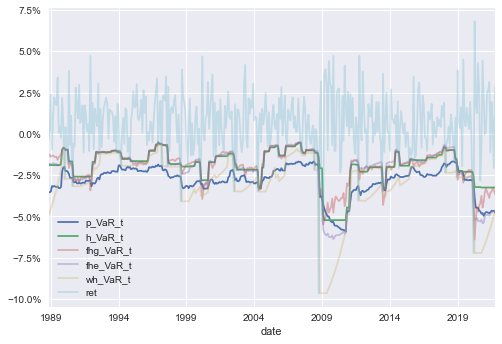

In [1562]:
ax = (df_eval_m_aug[['p_VaR_t','h_VaR_t']]*100).plot()
ax = (df_eval_m_aug['fhg_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m_aug['fhe_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m_aug['wh_VaR_t']*100).plot(alpha=0.4)
ax = (df_eval_m_aug['ret']*100).plot(alpha=0.3)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1563]:
VaR_t_m_aug=pd.DataFrame(index=df_eval_m_aug.index, columns= ['p_VaR_t','h_VaR_t','fhg_VaR_t','fhe_VaR_t','wh_VaR_t'])

VaR_t_m_aug['p_VaR_t']= df_eval_m_aug['ret']<df_eval_m_aug['p_VaR_t']
VaR_t_m_aug['h_VaR_t']= df_eval_m_aug['ret']<df_eval_m_aug['h_VaR_t']
VaR_t_m_aug['fhg_VaR_t']= df_eval_m_aug['ret']<df_eval_m_aug['fhg_VaR_t']
VaR_t_m_aug['fhe_VaR_t']= df_eval_m_aug['ret']<df_eval_m_aug['fhe_VaR_t']
VaR_t_m_aug['wh_VaR_t']= df_eval_m_aug['ret']<df_eval_m_aug['wh_VaR_t']

VaR_t_2_m_aug=VaR_t_m_aug.groupby(pd.Grouper(freq='Y')).sum()
pd.DataFrame(columns=['Average Number of Excedences per Year'],data=VaR_t_2_m_aug.mean().round(2))

,Average Number of Excedences per Year
p_VaR_t,0.50
h_VaR_t,0.97
fhg_VaR_t,1.00
fhe_VaR_t,1.00
wh_VaR_t,0.59


Text(0, 0.5, 'Average Number of Excedences per Year')

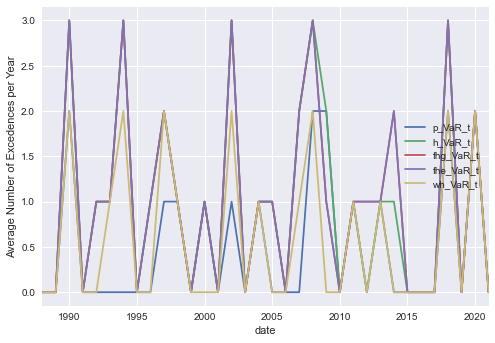

In [1564]:
ax = VaR_t_2_m_aug.plot()
plt.ylabel('Average Number of Excedences per Year')

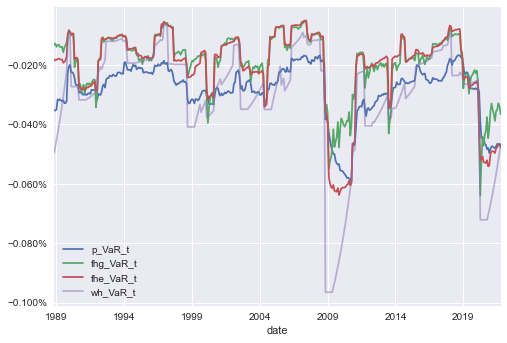

In [1565]:
ax = df_eval_m_aug[['p_VaR_t','fhg_VaR_t','fhe_VaR_t']].plot()
ax = df_eval_m_aug['wh_VaR_t'].plot(alpha=0.5)
plt.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ----------------------- Tracking Error ----------------------- 

In [1566]:
## Computing the Tracking Error - Comparision: After rebal and before rebal


# computing portf. returns before rebalancing
weights_init=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.5,0.25,0.05,0.12,0.5,0.03]])
portfolio_ret_m_init=pd.DataFrame(index=df_monthly_ret.index,columns=["ret"], data=np.dot(df_monthly_ret,weights_init.T))

# computing Tracking Error
tracking_error_month = pd.DataFrame(portfolio_ret_m_aug['ret'] - portfolio_ret_m_init['ret'])
tracking_error_month.columns = ['TE']

avg_TE_monthly = np.average(tracking_error_month)

avg_TE_monthly

-0.0023168928764488394

# ----------------------- Portfolio Decomposition ----------------------- 

In [1567]:
risk_contribution_default=erk.risk_contribution(np.array([0.5,0.25,0.05,0.12,0.05,0.03]),
                      erk.sample_cov(df_monthly_ret))

In [1568]:
risk_contribution_active=erk.risk_contribution(np.array([0.4,0.2,0.05,0.2,0.15,0]),
                      erk.sample_cov(df_monthly_ret))

In [1569]:
comparison=pd.DataFrame([risk_contribution_default,risk_contribution_active])*100
comparison.applymap('{:,.1f}%'.format)

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
0,93.2%,2.5%,1.7%,-2.5%,1.1%,4.0%
1,76.0%,4.1%,2.2%,5.6%,12.1%,0.0%


In [1570]:
wealth_index = 1000*(1+df_monthly_ret).cumprod()
previous_peaks=wealth_index.cummax()
drawdowns=(wealth_index - previous_peaks)/previous_peaks

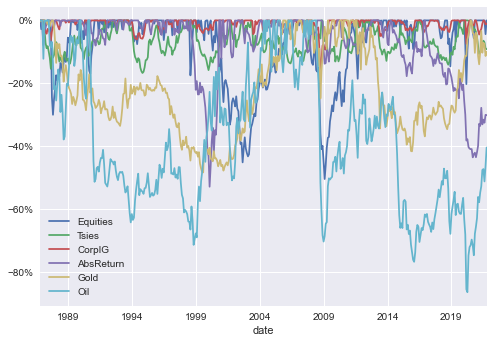

In [1571]:
ax = (drawdowns*100).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Drawdowns default portfolio

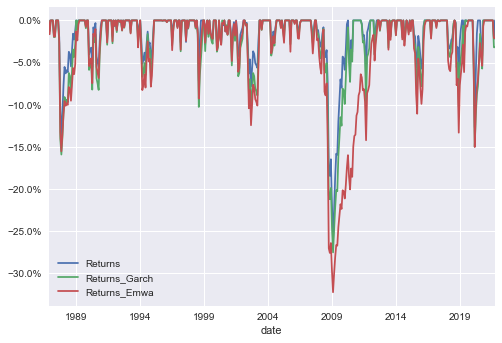

In [1572]:
wealth_index = 1000*(1+df_returns_m).cumprod()
previous_peaks=wealth_index.cummax()
drawdowns=(wealth_index - previous_peaks)/previous_peaks
ax = (drawdowns*100).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Drawdowns augmented portfolio

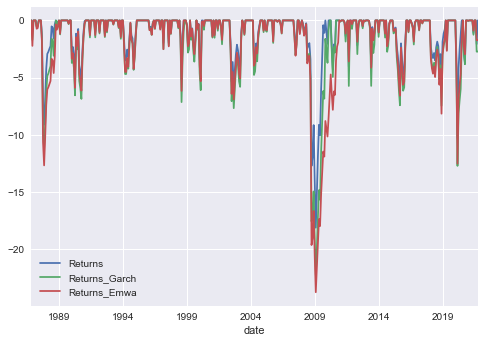

In [1573]:
wealth_index = 1000*(1+df_returns_m_aug).cumprod()
previous_peaks=wealth_index.cummax()
drawdowns=(wealth_index - previous_peaks)/previous_peaks
(drawdowns*100).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1574]:
erk.var_historic(df_monthly_ret,level=5)

Equities     0.07274
Tsies        0.03083
CorpIG       0.01584
AbsReturn    0.04470
Gold         0.06235
Oil          0.13371
dtype: float64

In [1575]:
erk.var_gaussian(df_monthly_ret,level=5)

Equities     0.06348
Tsies        0.03301
CorpIG       0.01937
AbsReturn    0.06208
Gold         0.06797
Oil          0.16303
dtype: float64

### Cornish Fisher Var

In [1576]:
erk.var_gaussian(df_monthly_ret,level=5,modified=True)

Equities     0.07110
Tsies        0.03185
CorpIG       0.02149
AbsReturn    0.03825
Gold         0.06510
Oil          0.10392
dtype: float64

In [1577]:
erk.cvar_historic(df_monthly_ret,level=5)

Equities     0.10320
Tsies        0.04294
CorpIG       0.03086
AbsReturn    0.08091
Gold         0.08587
Oil          0.20361
dtype: float64

### Weights and returns

In [1578]:
# computing weights, estimated VaR and portfolio rets

weights_init=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.5,0.25,0.05,0.12,0.05,0.03]])
weights_aug=pd.DataFrame(index=["weights"],columns=df.columns,data=[[0.4,0.20,0.05,0.2,0.15,0.0]])

port_var_init = var_25_fhist_g_m.copy()
port_var_aug =var_25_fhist_g_m_aug.copy()

portfolio_ret_init=pd.DataFrame(df_returns_m['Returns'])
portfolio_ret_aug=pd.DataFrame(df_returns_m_aug['Returns'])

### Before Rebalancing

In [1579]:
new_mat = df_monthly_ret.copy()
new_mat['port'] = portfolio_ret_init

varcov = pd.DataFrame(np.cov(new_mat, rowvar=False), index=new_mat.columns, columns=new_mat.columns)

beta_equities_init = (varcov.iloc[0,-1]/np.var(portfolio_ret_init))[0]
beta_Tsies_init = (varcov.iloc[1,-1]/np.var(portfolio_ret_init))[0]
beta_CorpIG_init = (varcov.iloc[2,-1]/np.var(portfolio_ret_init))[0]
beta_AbsReturn_init = (varcov.iloc[3,-1]/np.var(portfolio_ret_init))[0]
beta_Gold_init = (varcov.iloc[4,-1]/np.var(portfolio_ret_init))[0]
beta_Oil_init = (varcov.iloc[5,-1]/np.var(portfolio_ret_init))[0]

betas_init = pd.DataFrame(columns = ['betas'], index=['Equities', 'Tsies', 'CorpIG', 'AbsReturn', 'Gold', 'Oil'], data=[beta_equities_init, beta_Tsies_init, beta_CorpIG_init, beta_AbsReturn_init, beta_Gold_init, beta_Oil_init])
betas_init

,betas
Equities,1.86836
Tsies,0.09952
CorpIG,0.34603
AbsReturn,-0.21118
Gold,0.21967
Oil,1.34611


In [1580]:
marginal_var_init = betas_init*port_var_init

component_var_init= marginal_var_init['betas']*weights_init.T['weights']

portfolio_var_init = component_var_init.sum()

portfolio_var_init

-0.0545591677858468

In [1581]:
risk_share_var_init = pd.DataFrame(component_var_init, columns=['VaR Contribution Init']) / portfolio_var_init.sum()

(risk_share_var_init*100).applymap('{:,.2f}%'.format)

,VaR Contribution Init
Equities,93.20%
Tsies,2.48%
CorpIG,1.73%
AbsReturn,-2.53%
Gold,1.10%
Oil,4.03%


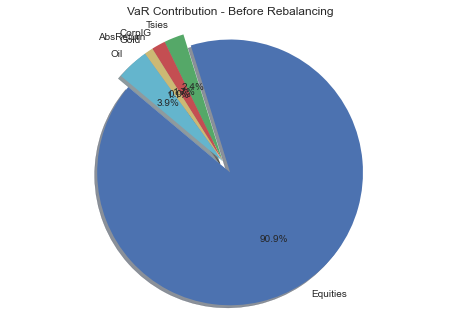

In [1582]:
labels = 'Equities', 'Tsies', 'CorpIG', 'AbsReturn', 'Gold', 'Oil'
sizes = [0.932, 0.0248, 0.0173, -0, 0.011, 0.0403]
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('VaR Contribution - Before Rebalancing')
plt.axis('equal')
plt.show()

### After Rebalancing

In [1583]:
new_mat_aug = df_monthly_ret.copy()
new_mat_aug['port'] = portfolio_ret_aug

varcov_aug = pd.DataFrame(np.cov(new_mat_aug, rowvar=False), index=new_mat_aug.columns, columns=new_mat_aug.columns)

beta_equities_aug = (varcov.iloc[0,-1]/np.var(portfolio_ret_aug))[0]
beta_Tsies_aug = (varcov.iloc[1,-1]/np.var(portfolio_ret_aug))[0]
beta_CorpIG_aug = (varcov.iloc[2,-1]/np.var(portfolio_ret_aug))[0]
beta_AbsReturn_aug = (varcov.iloc[3,-1]/np.var(portfolio_ret_aug))[0]
beta_Gold_aug = (varcov.iloc[4,-1]/np.var(portfolio_ret_aug))[0]
beta_Oil_aug = (varcov.iloc[5,-1]/np.var(portfolio_ret_aug))[0]

betas_aug = pd.DataFrame(columns = ['betas'], index=['Equities', 'Tsies', 'CorpIG', 'AbsReturn', 'Gold', 'Oil'], data=[beta_equities_aug, beta_Tsies_aug, beta_CorpIG_aug, beta_AbsReturn_aug, beta_Gold_aug, beta_Oil_aug])
betas_aug

,betas
Equities,2.72077
Tsies,0.14493
CorpIG,0.50391
AbsReturn,-0.30752
Gold,0.31989
Oil,1.96026


In [1584]:
marginal_var_aug = betas_aug*port_var_aug

component_var_aug= marginal_var_aug['betas']*weights_aug.T['weights']

portfolio_var_aug = component_var_aug.sum()

portfolio_var_aug

-0.04818864749314449

In [1585]:
risk_share_var_aug = pd.DataFrame(component_var_aug, columns=['VaR Contribution Init']) / portfolio_var_aug.sum()

(risk_share_var_aug*100).applymap('{:,.2f}%'.format)

,VaR Contribution Init
Equities,96.40%
Tsies,2.57%
CorpIG,2.23%
AbsReturn,-5.45%
Gold,4.25%
Oil,0.00%


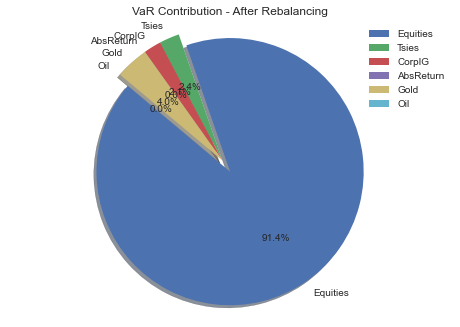

In [1586]:
labels = 'Equities', 'Tsies', 'CorpIG', 'AbsReturn', 'Gold', 'Oil'
sizes = [0.9640, 0.0257, 0.0223, -0, 0.0425, 0.00]
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('VaR Contribution - After Rebalancing')
plt.legend()
plt.axis('equal')
plt.show()

### Sharpe ratios

In [1587]:
pd.set_option('precision', 5)
from datetime import datetime
import pandas_datareader.data as web

In [1588]:
start=datetime(1986,10,30)
end=datetime(2021,10,31)
riskfree_3m_tbill=web.DataReader('TB3MS','fred',start=start,end=end)

### De-annualising and dividing by 100 for uniformity

In [1589]:
riskfree_3m_tbill=riskfree_3m_tbill/1200

In [1590]:
riskfree_3m_tbill.head()

,TB3MS
DATE,
1986-11-01,0.00446
1986-12-01,0.00461
1987-01-01,0.00452
1987-02-01,0.00466
1987-03-01,0.00466


In [1591]:
avg_excess_ret_equities=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_equities.append((df_monthly_ret.Equities.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_equities_df=pd.DataFrame(avg_excess_ret_equities,index=df_monthly_ret.index)

In [1592]:
avg_excess_ret_Tsies=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_Tsies.append((df_monthly_ret.Tsies.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_Tsies_df=pd.DataFrame(avg_excess_ret_Tsies,index=df_monthly_ret.index)

In [1593]:
avg_excess_ret_CorpIG=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_CorpIG.append((df_monthly_ret.CorpIG.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_CorpIG_df=pd.DataFrame(avg_excess_ret_CorpIG,index=df_monthly_ret.index)

In [1594]:
avg_excess_ret_AbsReturn=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_AbsReturn.append((df_monthly_ret.AbsReturn.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_AbsReturn_df=pd.DataFrame(avg_excess_ret_AbsReturn,index=df_monthly_ret.index)

In [1595]:
avg_excess_ret_Gold=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_Gold.append((df_monthly_ret.Gold.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_Gold_df=pd.DataFrame(avg_excess_ret_Gold,index=df_monthly_ret.index)

In [1596]:
avg_excess_ret_Oil=[]
for i in range(df_monthly_ret.shape[0]):
    avg_excess_ret_Oil.append((df_monthly_ret.Oil.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_Oil_df=pd.DataFrame(avg_excess_ret_Oil,index=df_monthly_ret.index)

In [1597]:
avg_excess_ret_Default=[]
for i in range(portfolio_ret_m.shape[0]):
    avg_excess_ret_Default.append((portfolio_ret_m.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_Default_df=pd.DataFrame(avg_excess_ret_Default,index=portfolio_ret_m.index)

In [1719]:
avg_excess_ret_Augmented=[]
for i in range(portfolio_ret_m_aug.shape[0]):
    avg_excess_ret_Augmented.append((portfolio_ret_m_aug.iloc[0:i].values-riskfree_3m_tbill[0:i].values).mean())
avg_excess_ret_Augmented_df=pd.DataFrame(avg_excess_ret_Augmented,index=portfolio_ret_m.index)

In [1720]:
avg_excess_ret_all=pd.concat([avg_excess_ret_equities_df,avg_excess_ret_Tsies_df,avg_excess_ret_CorpIG_df,
                            avg_excess_ret_AbsReturn_df,avg_excess_ret_Gold_df,avg_excess_ret_Oil_df,avg_excess_ret_Default_df,
                             avg_excess_ret_Augmented_df],axis=1)

In [1721]:
avg_excess_ret_all.columns=['Equities','Tsies','CorpIG','ABsReturn','Gold','Oil','Default_port','Augmented_port']

In [1722]:
model_garch_equities=arch_model(y=df_monthly_ret['Equities']*100, rescale=True, mean='Zero')
model_garch_tsies=arch_model(y=df_monthly_ret['Tsies']*100, rescale=True, mean='Zero')
model_garch_corpig=arch_model(y=df_monthly_ret['CorpIG']*100, rescale=True, mean='Zero')
model_garch_absreturn=arch_model(y=df_monthly_ret['AbsReturn']*100, rescale=True, mean='Zero')
model_garch_gold=arch_model(y=df_monthly_ret['Gold']*100, rescale=True, mean='Zero')
model_garch_oil=arch_model(y=df_monthly_ret['Oil']*100, rescale=True, mean='Zero')
model_garch_default_port=arch_model(y=portfolio_ret_m['ret']*100, rescale=True, mean='Zero')
model_garch_augmented_port=arch_model(y=portfolio_ret_m_aug['ret']*100, rescale=True, mean='Zero')

In [1723]:
res_garch_equities=model_garch_equities.fit(backcast=(df_monthly_ret['Equities'][0]*100)**2)
res_garch_tsies=model_garch_tsies.fit(backcast=(df_monthly_ret['Tsies'][0]*100)**2)
res_garch_corpig=model_garch_corpig.fit(backcast=(df_monthly_ret['CorpIG'][0]*100)**2)
res_garch_absreturn=model_garch_absreturn.fit(backcast=(df_monthly_ret['AbsReturn'][0]*100)**2)
res_garch_gold=model_garch_gold.fit(backcast=(df_monthly_ret['Gold'][0]*100)**2)
res_garch_oil=model_garch_oil.fit(backcast=(df_monthly_ret['Oil'][0]*100)**2)
res_garch_default_port=model_garch_default_port.fit(backcast=(portfolio_ret_m['ret'][0]*100)**2)
res_garch_augmented_port=model_garch_augmented_port.fit(backcast=(portfolio_ret_m_aug['ret'][0]*100)**2)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1263.8868640127855
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1258.8335173459093
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1307.072236512996
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1225.8473837315564
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1224.1519361633093
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1224.291679175627
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1223.8654800644686
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1223.8286529013
Iteration:      9,   Func. Count:     47,   Neg. LLF: 1223.8275306868645
Iteration:     10,   Func. Count:     51,   Neg. LLF: 1223.8274501942194
Iteration:     11,   Func. Count:     55,   Neg. LLF: 1223.8274345516372
Iteration:     12,   Func. Count:     59,   Neg. LLF: 1223.8274337178432
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1223.8274337178432
            Iteratio

In [1724]:
conditional_vol_garch_equities=(res_garch_equities.conditional_volatility**2/10000)**0.5

In [1725]:
conditional_vol_garch_tsies=(res_garch_tsies.conditional_volatility**2/10000)**0.5

In [1726]:
conditional_vol_garch_corpig=(res_garch_corpig.conditional_volatility**2/10000)**0.5

In [1727]:
conditional_vol_garch_absreturn=(res_garch_absreturn.conditional_volatility**2/10000)**0.5

In [1728]:
conditional_vol_garch_gold=(res_garch_gold.conditional_volatility**2/10000)**0.5

In [1729]:
conditional_vol_garch_oil=(res_garch_oil.conditional_volatility**2/10000)**0.5

In [1730]:
conditional_vol_garch_default_port=(res_garch_default_port.conditional_volatility**2/10000)**0.5

In [1731]:
conditional_vol_garch_aug_port=(res_garch_augmented_port.conditional_volatility**2/10000)**0.5

In [1732]:
conditional_vol_garch_all=pd.concat([conditional_vol_garch_equities,conditional_vol_garch_tsies,
                                    conditional_vol_garch_corpig,conditional_vol_garch_absreturn,conditional_vol_garch_gold,
                                    conditional_vol_garch_oil,conditional_vol_garch_default_port,conditional_vol_garch_aug_port],axis=1)

In [1733]:
conditional_vol_garch_all.columns=['Equities','Tsies','CorpIG','AbsReturn','Gold','Oil','Default_Port','Aug_port']

In [1734]:
sharpe_ratios=avg_excess_ret_all/conditional_vol_garch_all.values

In [1735]:
conditional_vol_garch_all

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil,Default_Port,Aug_port
date,,,,,,,,
1986-11-30,0.02489,0.01991,0.01681,0.01851,0.02969,0.04353,0.01675,0.01346
1986-12-31,0.02932,0.02021,0.01656,0.02010,0.03054,0.05275,0.01842,0.01541
1987-01-31,0.03319,0.01990,0.01564,0.02057,0.03019,0.12630,0.01853,0.01639
1987-02-28,0.06177,0.01984,0.01577,0.02329,0.03108,0.10502,0.03704,0.02498
1987-03-31,0.05719,0.01981,0.01488,0.03972,0.03090,0.11242,0.02876,0.02181
...,...,...,...,...,...,...,...,...
2021-06-30,0.04269,0.01992,0.01460,0.06913,0.04953,0.09139,0.02305,0.02192
2021-07-31,0.04147,0.02014,0.01542,0.06952,0.05154,0.10087,0.02074,0.02006
2021-08-31,0.03946,0.02067,0.01515,0.05665,0.05016,0.08497,0.02082,0.01979


In [1736]:
sharpe_ratios.head()

,Equities,Tsies,CorpIG,ABsReturn,Gold,Oil,Default_port,Augmented_port
date,,,,,,,,
1986-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-12-31,0.38627,0.44261,0.77597,0.55020,-1.08500,-0.39532,10.22423,12.06079
1987-01-31,-0.32108,-0.03328,0.62079,0.49014,-0.65708,0.67249,2.39980,0.61220
1987-02-28,0.55581,-0.03963,0.65107,-0.09651,-0.14982,0.66644,8.79048,12.16408
1987-03-31,0.64210,-0.09779,0.56135,-0.43340,-0.04265,0.18586,9.34645,11.72516


<AxesSubplot:xlabel='date'>

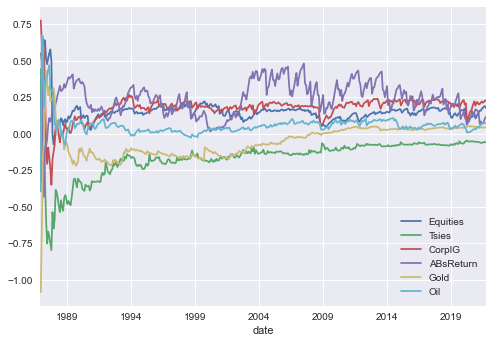

In [1737]:
sharpe_ratios.iloc[:,:-2].plot()

<AxesSubplot:xlabel='date'>

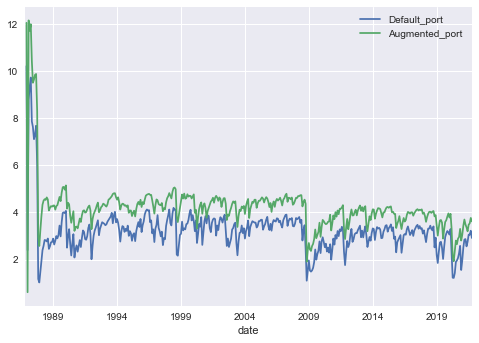

In [1742]:
sharpe_ratios.iloc[:,-2:].plot()

# -----------------------  Tail risk ----------------------- 

## Original Portfolio

In [1620]:
se_vol_m = 1/np.sqrt(len(df_25_m)*2)

In [1621]:
(vol_garch_for_m[0]*(1+2*se_vol_m),vol_garch_for_m[0]*(1-2*se_vol_m))

(0.034030074892463055, 0.01902409076876385)

In [1622]:
vol_garch_for_m[0]

0.026527082830613457

In [1623]:
se_var_m = np.sqrt((0.5*0.95)/(len(df_25_m)*(sp.norm.pdf(-sp.norm.ppf(0.05))**2)))

In [1624]:
((-sp.norm.ppf(0.05)+2*se_var_m)*(var_25_fhist_g_m/sp.norm.ppf(0.05)),(-sp.norm.ppf(0.05)-2*se_var_m)*(var_25_fhist_g_m/sp.norm.ppf(0.05)))

(0.14288036528501522, -0.034021835274206554)

In [1625]:
-var_25_fhist_g_m

0.05442926500540435

In [1626]:
cf_std_m = df_25_m['Returns'].std()
cf_skw_m = sp.skew(df_25_m['Returns'])
cf_kurt_m = sp.kurtosis(df_25_m['Returns'])

cf_z_m = sp.norm.ppf(0.05)+((sp.norm.ppf(0.05)**2)-1)*cf_skw_m/6+((sp.norm.ppf(0.05)**3)-3*sp.norm.ppf(0.05))*cf_kurt_m/24-(2*(sp.norm.ppf(0.05)**3)-5*sp.norm.ppf(0.05))*(cf_skw_m**2)/36
cf_z_m

-1.837452371726718

In [1627]:
cf_var_m = -cf_z_m*vol_garch_for_m[0]
cf_var_m

0.04874225126210179

In [1628]:
df_returns_crap_m = pd.DataFrame(df_returns_m['Returns'])
df_returns_crap_m['Abs Returns'] = np.abs(df_returns_m['Returns'])
df_returns_crap_m.sort_values('Abs Returns', inplace=True)
df_returns_crap_m['Cum Returns'] = df_returns_m['Returns']
df_returns_crap_m.reset_index(inplace=True)
df_returns_crap_m.drop(columns=['date'],inplace=True)

In [1629]:
for y in range(0, len(df_returns_crap_m)):
    if y==0:
        df_returns_crap_m.iloc[y, 2] = df_returns_crap_m.iloc[y, 0]
    else: df_returns_crap_m.iloc[y, 2] = df_returns_crap_m.iloc[y-1, 2] + df_returns_crap_m.iloc[y, 0]
        
df_returns_crap_m.tail(10)

,Returns,Abs Returns,Cum Returns
410,0.05828,0.05828,3.05480
411,-0.06067,0.06067,2.99413
412,0.06278,0.06278,3.05691
413,-0.06427,0.06427,2.99264
414,0.06625,0.06625,3.05888
415,0.07088,0.07088,3.12977
416,0.07372,0.07372,3.20349
417,-0.08825,0.08825,3.11524
418,-0.09016,0.09016,3.02508
419,-0.10831,0.10831,2.91676


<AxesSubplot:>

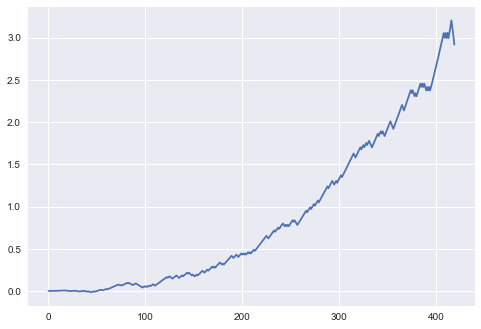

In [1630]:
df_returns_crap_m['Cum Returns'].plot()

In [1631]:
1-df_returns_crap_m[df_returns_crap_m['Cum Returns']==df_returns_crap_m['Cum Returns'].max()].index[0]/len(df_returns_crap_m['Cum Returns'])

0.00952380952380949

# Augmented Portfolio

In [1632]:
se_vol_m_aug = 1/np.sqrt(len(df_25_m_aug)*2)

In [1633]:
(vol_garch_for_m_aug[0]*(1+2*se_vol_m_aug),vol_garch_for_m_aug[0]*(1-2*se_vol_m_aug))

(0.026481188406051966, 0.014803979523801938)

In [1634]:
vol_garch_for_m_aug[0]

0.020642583964926953

In [1635]:
se_var_m_aug = np.sqrt((0.5*0.95)/(len(df_25_m_aug)*(sp.norm.pdf(-sp.norm.ppf(0.05))**2)))

In [1636]:
((-sp.norm.ppf(0.05)+2*se_var_m_aug)*(var_25_fhist_g_m_aug/sp.norm.ppf(0.05)),(-sp.norm.ppf(0.05)-2*se_var_m_aug)*(var_25_fhist_g_m_aug/sp.norm.ppf(0.05)))

(0.11204766524244356, -0.026680133425846225)

In [1637]:
-var_25_fhist_g_m_aug

0.04268376590829867

In [1638]:
cf_std_m_aug = df_25_m_aug['Returns'].std()
cf_skw_m_aug = sp.skew(df_25_m_aug['Returns'])
cf_kurt_m_aug = sp.kurtosis(df_25_m_aug['Returns'])

cf_z_m_aug = sp.norm.ppf(0.05)+((sp.norm.ppf(0.05)**2)-1)*cf_skw_m_aug/6+((sp.norm.ppf(0.05)**3)-3*sp.norm.ppf(0.05))*cf_kurt_m_aug/24-(2*(sp.norm.ppf(0.05)**3)-5*sp.norm.ppf(0.05))*(cf_skw_m_aug**2)/36
cf_z_m_aug

-1.8105286004289372

In [1639]:
cf_var_m_aug = -cf_z_m_aug*vol_garch_for_m_aug[0]
cf_var_m_aug

0.03737398865525602

In [1640]:
df_returns_crap_m_aug = pd.DataFrame(df_returns_m_aug['Returns'])
df_returns_crap_m_aug['Abs Returns'] = np.abs(df_returns_m_aug['Returns'])
df_returns_crap_m_aug.sort_values('Abs Returns', inplace=True)
df_returns_crap_m_aug['Cum Returns'] = df_returns_m_aug['Returns']
df_returns_crap_m_aug.reset_index(inplace=True)
df_returns_crap_m_aug.drop(columns=['date'],inplace=True)

In [1641]:
for y in range(0, len(df_returns_crap_m_aug)):
    if y==0:
        df_returns_crap_m_aug.iloc[y, 2] = df_returns_crap_m_aug.iloc[y, 0]
    else: df_returns_crap_m_aug.iloc[y, 2] = df_returns_crap_m_aug.iloc[y-1, 2] + df_returns_crap_m_aug.iloc[y, 0]
        
df_returns_crap_m_aug.tail(10)

,Returns,Abs Returns,Cum Returns
410,0.04716,0.04716,2.90941
411,0.04718,0.04718,2.95659
412,0.04735,0.04735,3.00393
413,-0.04829,0.04829,2.95565
414,-0.05293,0.05293,2.90271
415,0.05308,0.05308,2.95580
416,-0.05998,0.05998,2.89582
417,0.06810,0.06810,2.96392
418,-0.07214,0.07214,2.89179
419,-0.09650,0.09650,2.79528


<AxesSubplot:>

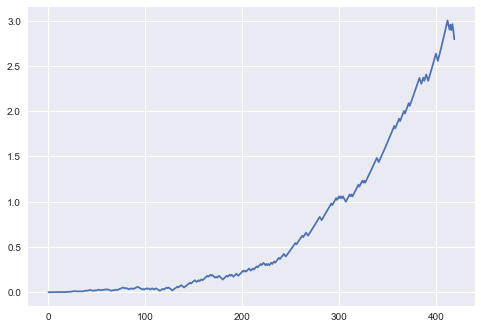

In [1642]:
df_returns_crap_m_aug['Cum Returns'].plot()

In [1643]:
1-df_returns_crap_m_aug[df_returns_crap_m_aug['Cum Returns']==df_returns_crap_m_aug['Cum Returns'].max()].index[0]/len(df_returns_crap_m_aug['Cum Returns'])

0.01904761904761909

### CCARP

In [1644]:
df_returns_ccrap_m = []
df_returns_ccrap_m = pd.DataFrame(df_returns_m['Returns'])
df_returns_ccrap_m['Returns Aug'] = pd.DataFrame(df_returns_m_aug['Returns'])
df_returns_ccrap_m['Abs Returns'] = np.abs(df_returns_m_aug['Returns'])
df_returns_ccrap_m.sort_values('Abs Returns', inplace=True)
df_returns_ccrap_m['Cum Returns'] = df_returns_m['Returns']
df_returns_ccrap_m['Cum Returns Aug'] = df_returns_m['Returns']
df_returns_ccrap_m.reset_index(inplace=True)
df_returns_ccrap_m.drop(columns=['date'],inplace=True)

In [1645]:
for y in range(0, len(df_returns_ccrap_m)):
    if y==0:
        df_returns_ccrap_m.iloc[y, 3] = df_returns_ccrap_m.iloc[y, 0]
        df_returns_ccrap_m.iloc[y, 4] = df_returns_ccrap_m.iloc[y, 1]
    else: 
        df_returns_ccrap_m.iloc[y, 3] = df_returns_ccrap_m.iloc[y-1, 3] + df_returns_ccrap_m.iloc[y, 0]
        df_returns_ccrap_m.iloc[y, 4] = df_returns_ccrap_m.iloc[y-1, 4] + df_returns_ccrap_m.iloc[y, 1]
        
df_returns_ccrap_m

,Returns,Returns Aug,Abs Returns,Cum Returns,Cum Returns Aug
0,0.00521,-6.72951e-06,6.72951e-06,0.00521,-6.72951e-06
1,0.00747,2.57571e-05,2.57571e-05,0.01268,1.90276e-05
2,-0.00657,-7.43859e-05,7.43859e-05,0.00611,-5.53583e-05
3,-0.00669,1.42505e-04,1.42505e-04,-0.00058,8.71467e-05
4,0.00363,2.33577e-04,2.33577e-04,0.00305,3.20723e-04
...,...,...,...,...,...
415,0.06625,5.30833e-02,5.30833e-02,3.12977,2.95580e+00
416,-0.08825,-5.99755e-02,5.99755e-02,3.04152,2.89582e+00
417,0.07372,6.81030e-02,6.81030e-02,3.11524,2.96392e+00
418,-0.09016,-7.21370e-02,7.21370e-02,3.02508,2.89179e+00


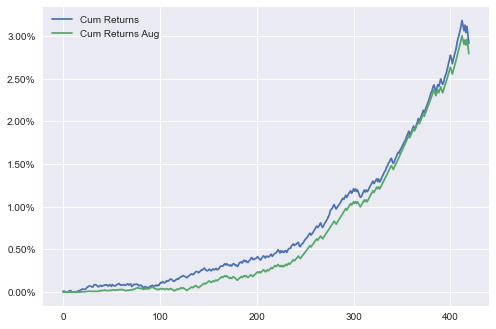

In [1646]:
ax = df_returns_ccrap_m[['Cum Returns','Cum Returns Aug']].plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1647]:
1-df_returns_ccrap_m[df_returns_ccrap_m['Cum Returns Aug']==df_returns_ccrap_m['Cum Returns Aug'].max()].index[0]/len(df_returns_ccrap_m['Cum Returns Aug'])

0.01904761904761909

In [1648]:
df_returns_ccrap_d = []
df_returns_ccrap_d = pd.DataFrame(df_returns['Returns'])
df_returns_ccrap_d['Returns Aug'] = pd.DataFrame(df_returns_aug['Returns'])
df_returns_ccrap_d['Abs Returns'] = np.abs(df_returns_aug['Returns'])
df_returns_ccrap_d.sort_values('Abs Returns', inplace=True)
df_returns_ccrap_d['Cum Returns'] = df_returns['Returns']
df_returns_ccrap_d['Cum Returns Aug'] = df_returns['Returns']
df_returns_ccrap_d.reset_index(inplace=True)
df_returns_ccrap_d.drop(columns=['date'],inplace=True)

In [1649]:
for y in range(0, len(df_returns_ccrap_d)):
    if y==0:
        df_returns_ccrap_d.iloc[y, 3] = df_returns_ccrap_d.iloc[y, 0]
        df_returns_ccrap_d.iloc[y, 4] = df_returns_ccrap_d.iloc[y, 1]
    else: 
        df_returns_ccrap_d.iloc[y, 3] = df_returns_ccrap_d.iloc[y-1, 3] + df_returns_ccrap_d.iloc[y, 0]
        df_returns_ccrap_d.iloc[y, 4] = df_returns_ccrap_d.iloc[y-1, 4] + df_returns_ccrap_d.iloc[y, 1]
        
df_returns_ccrap_d

,Returns,Returns Aug,Abs Returns,Cum Returns,Cum Returns Aug
0,-0.00087,2.66516e-07,2.66516e-07,-0.00087,2.66516e-07
1,0.00049,4.71029e-07,4.71029e-07,-0.00038,7.37545e-07
2,-0.00151,-8.36857e-07,8.36857e-07,-0.00188,-9.93120e-08
3,0.00005,1.93361e-06,1.93361e-06,-0.00183,1.83429e-06
4,0.00056,2.43638e-06,2.43638e-06,-0.00127,4.27068e-06
...,...,...,...,...,...
8815,-0.04699,-4.15287e-02,4.15287e-02,3.04393,2.94481e+00
8816,0.04756,4.85475e-02,4.85475e-02,3.09150,2.99335e+00
8817,-0.05899,-4.95639e-02,4.95639e-02,3.03251,2.94379e+00
8818,-0.05594,-5.05512e-02,5.05512e-02,2.97656,2.89324e+00


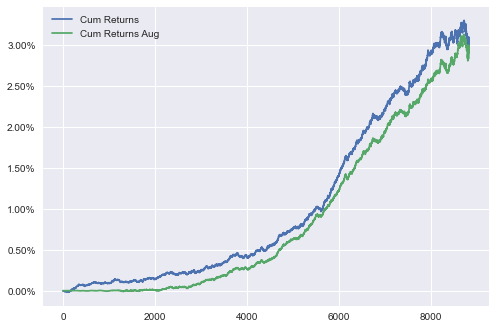

In [1650]:
ax = df_returns_ccrap_d[['Cum Returns','Cum Returns Aug']].plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [1651]:
1-df_returns_ccrap_d[df_returns_ccrap_d['Cum Returns Aug']==df_returns_ccrap_d['Cum Returns Aug'].max()].index[0]/len(df_returns_ccrap_d['Cum Returns Aug'])

0.011678004535147446

In [1652]:
df_d_ret
df_assets_ccrap_d = []
df_assets_ccrap_d = pd.DataFrame(df_d_ret)
df_assets_ccrap_d['Tsies'] = df_assets_ccrap_d['Tsies']*df_assets_ccrap_d['Equities'].mean()/df_assets_ccrap_d['Tsies'].mean()
df_assets_ccrap_d['CorpIG'] = df_assets_ccrap_d['CorpIG']*df_assets_ccrap_d['Equities'].mean()/df_assets_ccrap_d['CorpIG'].mean()
df_assets_ccrap_d['AbsReturn'] = df_assets_ccrap_d['AbsReturn']*df_assets_ccrap_d['Equities'].mean()/df_assets_ccrap_d['AbsReturn'].mean()
df_assets_ccrap_d['Gold'] = df_assets_ccrap_d['Gold']*df_assets_ccrap_d['Equities'].mean()/df_assets_ccrap_d['Gold'].mean()
df_assets_ccrap_d['Oil'] = df_assets_ccrap_d['Oil']*df_assets_ccrap_d['Equities'].mean()/df_assets_ccrap_d['Oil'].mean()
df_assets_ccrap_d[['Abs Equities']] = np.abs(df_d_ret['Equities'])
df_assets_ccrap_d[['Cum Equities','Cum Tsies','Cum CorpIG','Cum AbsReturn','Cum Gold','Cum Oil']] = df_d_ret
df_assets_ccrap_d.sort_values('Abs Equities', inplace=True)
df_assets_ccrap_d.reset_index(inplace=True)
df_assets_ccrap_d.drop(columns=['date'],inplace=True)

In [1653]:
for y in range(0, len(df_returns_ccrap_d)):
    if y==0:
        df_assets_ccrap_d.iloc[y, 7] = df_assets_ccrap_d.iloc[y, 0]
        df_assets_ccrap_d.iloc[y, 8] = df_assets_ccrap_d.iloc[y, 1]
        df_assets_ccrap_d.iloc[y, 9] = df_assets_ccrap_d.iloc[y, 2]
        df_assets_ccrap_d.iloc[y, 10] = df_assets_ccrap_d.iloc[y, 3]
        df_assets_ccrap_d.iloc[y, 11] = df_assets_ccrap_d.iloc[y, 4]
        df_assets_ccrap_d.iloc[y, 12] = df_assets_ccrap_d.iloc[y, 5]
    else: 
        df_assets_ccrap_d.iloc[y, 7] = df_assets_ccrap_d.iloc[y-1, 7] + df_assets_ccrap_d.iloc[y, 0]
        df_assets_ccrap_d.iloc[y, 8] = df_assets_ccrap_d.iloc[y-1, 8] + df_assets_ccrap_d.iloc[y, 1]
        df_assets_ccrap_d.iloc[y, 9] = df_assets_ccrap_d.iloc[y-1, 9] + df_assets_ccrap_d.iloc[y, 2]
        df_assets_ccrap_d.iloc[y, 10] = df_assets_ccrap_d.iloc[y-1, 10] + df_assets_ccrap_d.iloc[y, 3]
        df_assets_ccrap_d.iloc[y, 11] = df_assets_ccrap_d.iloc[y-1, 11] + df_assets_ccrap_d.iloc[y, 4]
        df_assets_ccrap_d.iloc[y, 12] = df_assets_ccrap_d.iloc[y-1, 12] + df_assets_ccrap_d.iloc[y, 5]

In [1654]:
df_assets_ccrap_d

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil,Abs Equities,Cum Equities,Cum Tsies,Cum CorpIG,Cum AbsReturn,Cum Gold,Cum Oil
0,0.00000,-0.01379,-0.00154,-0.00609,0.01271,0.03617,0.00000,0.00000,-0.01379,-0.00154,-0.00609,0.01271,0.03617
1,0.00000,0.06788,0.00901,-0.00889,0.00342,0.01202,0.00000,0.00000,0.05408,0.00747,-0.01498,0.01613,0.04819
2,0.00000,0.04384,0.00575,-0.00190,-0.02991,0.06286,0.00000,0.00000,0.09792,0.01321,-0.01688,-0.01378,0.11105
3,0.00000,0.05393,0.01010,0.00469,0.03398,-0.03752,0.00000,0.00000,0.15185,0.02331,-0.01219,0.02020,0.07353
4,0.00000,0.03598,0.00760,0.00967,-0.00780,0.00707,0.00000,0.00000,0.18783,0.03091,-0.00251,0.01241,0.08060
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,-0.09624,-0.04721,-0.03895,-0.01639,-0.11274,-0.16171,0.09624,4.37997,4.15756,4.31410,4.27842,4.50109,4.45546
8816,0.09774,-0.06770,-0.00739,0.01374,0.00000,0.04850,0.09774,4.47771,4.08986,4.30671,4.29216,4.50109,4.50396
8817,0.11354,0.00000,0.00108,-0.02212,-0.17202,0.16437,0.11354,4.59125,4.08986,4.30779,4.27004,4.32906,4.66833
8818,-0.11994,0.16652,-0.00061,0.01137,-0.10788,-0.29693,0.11994,4.47131,4.25638,4.30718,4.28141,4.22118,4.37140


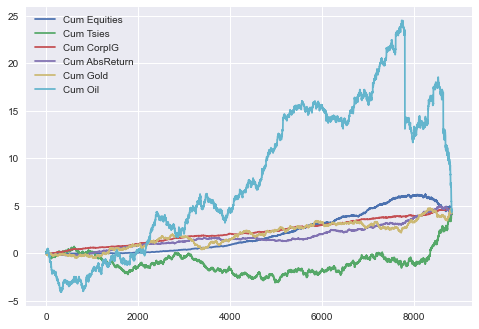

In [1655]:
ax = df_assets_ccrap_d[['Cum Equities','Cum Tsies','Cum CorpIG','Cum AbsReturn','Cum Gold','Cum Oil']].plot()

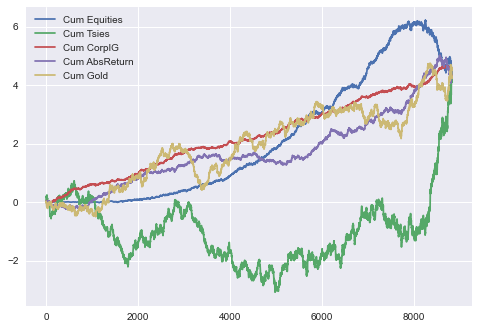

In [1656]:
ax = df_assets_ccrap_d[['Cum Equities','Cum Tsies','Cum CorpIG','Cum AbsReturn','Cum Gold']].plot()

In [1657]:
1-df_assets_ccrap_d[df_assets_ccrap_d['Cum Equities']==df_assets_ccrap_d['Cum Equities'].max()].index[0]/len(df_assets_ccrap_d['Cum Equities'])

0.06473922902494333

# ----------------------- Stress Scenarios ----------------------- 

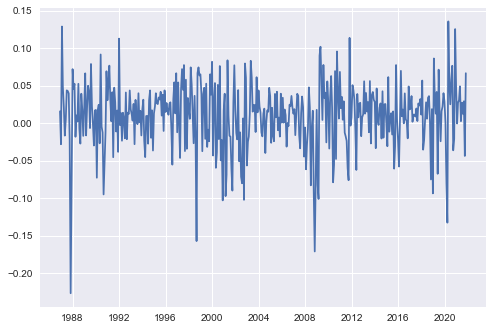

In [1658]:
# Equities
plt.plot(df_monthly_ret.index.values,df_monthly_ret.iloc[:,0])

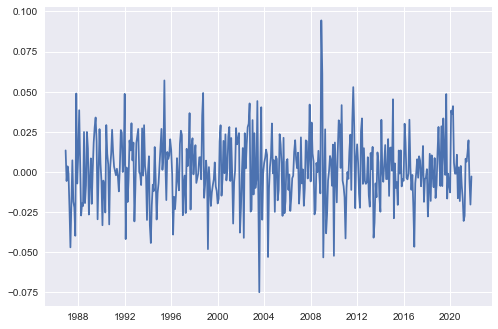

In [1659]:
# Treasuries
plt.plot(df_monthly_ret.index.values,df_monthly_ret.iloc[:,1])

In [1660]:
pd.DataFrame(data=np.array(df_monthly_ret.loc['2012-01-31':'2020-01-31',:]),columns=df_monthly_ret.loc['2012-01-31':'2020-01-31',:].columns,index=df_monthly_ret.loc['2012-01-31':'2020-01-31',:].index).sort_values('Tsies')

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
date,,,,,,
2016-11-30,0.04893,-0.04658,-0.02679,0.07765,-0.07382,0.05509
2013-05-31,0.02823,-0.04092,-0.02281,-0.00161,-0.05071,-0.01384
2013-06-30,-0.01203,-0.03155,-0.02784,-0.00145,-0.14521,0.04819
2015-02-28,0.06140,-0.02881,-0.00868,-0.03172,-0.03670,0.04290
2018-01-31,0.05681,-0.02771,-0.00914,-0.01959,0.04187,0.07211
...,...,...,...,...,...,...
2019-05-31,-0.06741,0.03332,0.01434,-0.00836,0.01033,-0.16199
2012-05-31,-0.06228,0.03333,0.00579,0.02375,-0.05647,-0.17514
2020-01-31,0.00030,0.03817,0.02376,-0.06638,0.04585,-0.15636


In [1743]:
hist_stress_scen= df_monthly_ret.loc[['1987-10-31','2008-09-30','2020-03-31','2013-05-31','2016-11-30','2021-10-31']]

In [1744]:
new_index = []
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<hist_stress_scen.index[0]].index.values[-1])
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<hist_stress_scen.index[1]].index.values[-1])
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<hist_stress_scen.index[2]].index.values[-1])
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<hist_stress_scen.index[3]].index.values[-1])
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<hist_stress_scen.index[4]].index.values[-1])
new_index.append(df_monthly_ret.loc[df_monthly_ret.index<=hist_stress_scen.index[5]].index.values[-1])
new_index

[numpy.datetime64('1987-09-30T00:00:00.000000000'),
 numpy.datetime64('2008-08-31T00:00:00.000000000'),
 numpy.datetime64('2020-02-29T00:00:00.000000000'),
 numpy.datetime64('2013-04-30T00:00:00.000000000'),
 numpy.datetime64('2016-10-31T00:00:00.000000000'),
 numpy.datetime64('2021-10-31T00:00:00.000000000')]

In [1745]:
hist_stress_scen['Port ret'] = np.dot(hist_stress_scen, weights.T)

In [1746]:
hist_stress_scen.index=['Black Monday','Global Financial Crisis','Covid','Taper Tantrum','Treasury Prices Crash 2016', 'Today']
hist_stress_scen

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil,Port ret
Black Monday,-0.22659,0.04885,0.02943,0.08191,0.02024,0.01733,-0.08825
Global Financial Crisis,-0.09211,-0.00209,-0.07322,0.08579,0.06182,-0.12852,-0.04071
Covid,-0.13255,0.04099,-0.07456,-0.11752,-0.00056,-0.54249,-0.09016
Taper Tantrum,0.02823,-0.04092,-0.02281,-0.00161,-0.05071,-0.01384,-0.00040
Treasury Prices Crash 2016,0.04893,-0.04658,-0.02679,0.07765,-0.07382,0.05509,0.01876
Today,0.06659,-0.00283,0.00241,-0.00095,0.01512,0.11008,0.03666


In [1747]:
hist_stress_scen['Port ret aug'] = np.dot(hist_stress_scen.iloc[:,:-1], weights_aug.T)

In [1748]:
(hist_stress_scen*100).applymap('{:,.2f}%'.format)

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil,Port ret,Port ret aug
Black Monday,-22.66%,4.89%,2.94%,8.19%,2.02%,1.73%,-8.82%,-6.00%
Global Financial Crisis,-9.21%,-0.21%,-7.32%,8.58%,6.18%,-12.85%,-4.07%,-1.45%
Covid,-13.25%,4.10%,-7.46%,-11.75%,-0.06%,-54.25%,-9.02%,-7.21%
Taper Tantrum,2.82%,-4.09%,-2.28%,-0.16%,-5.07%,-1.38%,-0.04%,-0.60%
Treasury Prices Crash 2016,4.89%,-4.66%,-2.68%,7.76%,-7.38%,5.51%,1.88%,1.34%
Today,6.66%,-0.28%,0.24%,-0.09%,1.51%,11.01%,3.67%,2.83%


In [1749]:
varcov = df_monthly_ret.rolling(12).cov()

In [1750]:
stress_varcov = varcov.loc[new_index]
stress_varcov

Equities    Tsies       CorpIG    AbsReturn     Gold  \
date                                                                            
1987-09-30 Equities           NaN      NaN          NaN          NaN      NaN   
           Tsies              NaN      NaN          NaN          NaN      NaN   
           CorpIG             NaN      NaN          NaN          NaN      NaN   
           AbsReturn          NaN      NaN          NaN          NaN      NaN   
           Gold               NaN      NaN          NaN          NaN      NaN   
           Oil                NaN      NaN          NaN          NaN      NaN   
2008-08-31 Equities   1.59285e-03 -0.00051  6.78511e-06 -6.13497e-04 -0.00085   
           Tsies     -5.08398e-04  0.00038  7.23845e-05  2.49019e-04  0.00021   
           CorpIG     6.78511e-06  0.00007  7.09126e-05 -3.77826e-06  0.00013   
           AbsReturn -6.13497e-04  0.00025 -3.77826e-06  7.56173e-04 -0.00022   
           Gold      -8.49737e-04  0.00021  1.30136e-04 -2.21175e-04  0.00421   
           Oil        1.09484e-03 -0.00099  3.32328e-05 -1.96358e-03  0.00221   
2020-02-29 Equities   1.95015e-03 -0.00067 -1.04223e-04  6.65238e-04  0.00004   
           Tsies     -6.67595e-04  0.00054  2.25137e-04 -6.91256e-04  0.00040   
           CorpIG    -1.04223e-04  0.00023  1.24248e-04 -3.04722e-04  0.00027   
           AbsReturn  6.65238e-04 -0.00069 -3.04722e-04  1.65138e-03 -0.00046   
           Gold       4.20214e-05  0.00040  2.68586e-04 -4.62050e-04  0.00143   
           Oil        3.43516e-03 -0.00141 -2.75382e-04  1.44226e-03 -0.00052   
2013-04-30 Equities   9.31904e-04 -0.00033 -9.23149e-05 -2.28764e-04  0.00067   
           Tsies     -3.31560e-04  0.00024  6.90035e-05  2.69760e-05 -0.00031   
           CorpIG    -9.23149e-05  0.00007  8.78813e-05  2.16484e-05 -0.00006   
           AbsReturn -2.28764e-04  0.00003  2.16484e-05  1.26685e-04 -0.00018   
           Gold       6.71135e-04 -0.00031 -5.77814e-05 -1.75631e-04  0.00188   
           Oil        1.73747e-03 -0.00070 -1.73006e-04 -4.74280e-04  0.00133   
2016-10-31 Equities   9.92031e-04 -0.00015  2.16731e-04 -4.10192e-04 -0.00028   
           Tsies     -1.46800e-04  0.00026  8.10249e-05  1.57368e-04  0.00067   
           CorpIG     2.16731e-04  0.00008  1.31422e-04  6.13602e-05  0.00032   
           AbsReturn -4.10192e-04  0.00016  6.13602e-05  8.28936e-04  0.00081   
           Gold      -2.75395e-04  0.00067  3.18550e-04  8.10862e-04  0.00305   
           Oil        1.26738e-03 -0.00051  4.10532e-04 -4.30418e-05  0.00026   
2021-10-31 Equities   1.67733e-03  0.00017  3.33438e-04 -5.61341e-04 -0.00023   
           Tsies      1.69723e-04  0.00026  1.96615e-04 -3.64487e-04  0.00031   
           CorpIG     3.33438e-04  0.00020  1.95954e-04 -3.41721e-04  0.00012   
           AbsReturn -5.61341e-04 -0.00036 -3.41721e-04  2.50837e-03  0.00029   
           Gold      -2.25233e-04  0.00031  1.20577e-04  2.86182e-04  0.00273   
           Oil        1.76537e-03 -0.00002  3.72418e-04 -1.07590e-03 -0.00208   

                          Oil  
date                           
1987-09-30 Equities       NaN  
           Tsies          NaN  
           CorpIG         NaN  
           AbsReturn      NaN  
           Gold           NaN  
           Oil            NaN  
2008-08-31 Equities   0.00109  
           Tsies     -0.00099  
           CorpIG     0.00003  
           AbsReturn -0.00196  
           Gold       0.00221  
           Oil        0.00854  
2020-02-29 Equities   0.00344  
           Tsies     -0.00141  
           CorpIG    -0.00028  
           AbsReturn  0.00144  
           Gold      -0.00052  
           Oil        0.00828  
2013-04-30 Equities   0.00174  
           Tsies     -0.00070  
           CorpIG    -0.00017  
           AbsReturn -0.00047  
           Gold       0.00133  
           Oil        0.00556  
2016-10-31 Equities   0.00127  
           Tsies     -0.00051  
           CorpIG     0.00041  
           AbsRetu

In [1751]:
BM_Cov = df_monthly_ret.rolling(11).cov().xs('1987-09-30')
BM_Cov

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
Equities,1.94484e-03,0.00043,0.00037,-5.12486e-04,6.45559e-06,-0.00086
Tsies,4.33206e-04,0.00037,0.00031,-1.09972e-04,-3.46022e-04,0.00005
CorpIG,3.74792e-04,0.00031,0.00027,-7.15755e-05,-2.77867e-04,0.00024
AbsReturn,-5.12486e-04,-0.00011,-0.00007,7.99822e-04,-5.08425e-06,0.00168
Gold,6.45559e-06,-0.00035,-0.00028,-5.08425e-06,9.17422e-04,0.00041
Oil,-8.58318e-04,0.00005,0.00024,1.67851e-03,4.11736e-04,0.00808


In [1781]:
returns_shocked_black_monday=hist_stress_scen.iloc[0,:6].values*(stress_varcov.xs('2021-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2021-10-31'][0]**2)/(BM_Cov.iloc[0,:].values/conditional_vol_garch_all.loc['1987-09-30'][0]**2)

In [1782]:
returns_shocked_gfc=hist_stress_scen.iloc[1,:6].values*(stress_varcov.xs('2021-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2021-10-31'][0]**2)/(stress_varcov.xs('2008-08-31').iloc[0,:].values/conditional_vol_garch_all.loc['2008-08-31'][0]**2)

In [1783]:
returns_shocked_covid=hist_stress_scen.iloc[2,:6].values*(stress_varcov.xs('2021-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2021-10-31'][0]**2)/(stress_varcov.xs('2020-02-29').iloc[0,:].values/conditional_vol_garch_all.loc['2020-02-29'][0]**2)

In [1784]:
returns_shocked_2003=hist_stress_scen.iloc[3,:6].values*(stress_varcov.xs('2021-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2021-10-31'][1]**2)/(stress_varcov.xs('2013-04-30').iloc[0,:].values/conditional_vol_garch_all.loc['2013-04-30'][1]**2)

In [1785]:
returns_shocked_2016=hist_stress_scen.iloc[4,:6].values*(stress_varcov.xs('2021-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2021-10-31'][1]**2)/(stress_varcov.xs('2016-10-31').iloc[0,:].values/conditional_vol_garch_all.loc['2016-10-31'][1]**2)

In [1792]:
shocked_ret=pd.DataFrame(data=[returns_shocked_black_monday,returns_shocked_gfc,returns_shocked_covid,returns_shocked_2003,returns_shocked_2016],index=['Black Monday','Global Financial Crisis','Covid','Taper Tantrum','Treasury Prices Crash 2016'],columns=['Equities','Tsies','CorpIG','AbsReturn','Gold','Oil'])

In [1793]:
(shocked_ret*100).applymap('{:,.2f}%'.format)

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil
Black Monday,-21.74%,2.13%,2.91%,9.98%,-78.56%,-3.97%
Global Financial Crisis,-11.81%,0.08%,-438.08%,9.56%,2.00%,-25.23%
Covid,-9.89%,-0.90%,20.70%,8.61%,0.26%,-24.20%
Taper Tantrum,4.66%,1.92%,7.56%,-0.36%,1.56%,-1.29%
Treasury Prices Crash 2016,7.59%,4.94%,-3.78%,9.74%,-5.54%,7.04%


In [1794]:
Default_Port=np.dot(shocked_ret,weights.T)

In [1795]:
Augmented_Port=np.dot(shocked_ret,weights_aug.T)

In [1796]:
shocked_ret['Default_Port']=Default_Port
shocked_ret['Augmented_Port']=Augmented_Port

In [1797]:
(shocked_ret*100).applymap('{:,.2f}%'.format)

,Equities,Tsies,CorpIG,AbsReturn,Gold,Oil,Default_Port,Augmented_Port
Black Monday,-21.74%,2.13%,2.91%,9.98%,-78.56%,-3.97%,-13.04%,-17.91%
Global Financial Crisis,-11.81%,0.08%,-438.08%,9.56%,2.00%,-25.23%,-27.30%,-24.40%
Covid,-9.89%,-0.90%,20.70%,8.61%,0.26%,-24.20%,-3.82%,-1.34%
Taper Tantrum,4.66%,1.92%,7.56%,-0.36%,1.56%,-1.29%,3.18%,2.79%
Treasury Prices Crash 2016,7.59%,4.94%,-3.78%,9.74%,-5.54%,7.04%,5.94%,4.95%
